# **Statistical Rethinking: A Bayesian course with examples in Python**
# **Ch 4 - Geocentric Models (Part 2)**

In [1]:
import re
import math
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc as pm
import seaborn as sns
import scipy.stats as stats
import plotly.graph_objects as go
import plotly.figure_factory as ff
import plotly.graph_objs as go
import plotly.express as px
from plotly.subplots import make_subplots
from patsy import dmatrix

from scipy.interpolate import griddata

In [2]:
%config InlineBackend.figure_format = 'retina'
RANDOM_SEED = 8927
rng = np.random.default_rng(RANDOM_SEED)
az.style.use("arviz-darkgrid")
az.rcParams["stats.hdi_prob"] = 0.89  # sets default credible interval used by arviz

## *Section 4.4* - Linear Prediction

So far, what we've done is create a Gaussian model of height in a population of adults. Now, what we can focus on is modelling how an outcome is related to some other variable which we can call a **predictor variable.** If a predictor variable, such as age or weight in this instance, has any statistical association with the outcome variable, which in this case is still height, then we can use it to the outcome we're looking for. And when we build a predictor variable inside our pre-existing model in a particular way, then we'll have generated a Linear Regression model.

First, let's start off by plotting the relationship between one of our predictor variables, weight, with our outcome variable, height:

#### Code 4.37

In [3]:
path = "https://raw.githubusercontent.com/pymc-devs/pymc-resources/main/Rethinking_2/Data/Howell1.csv"
d = pd.read_csv(path, sep=";", header=0)
d2 = d[d.age >= 18]

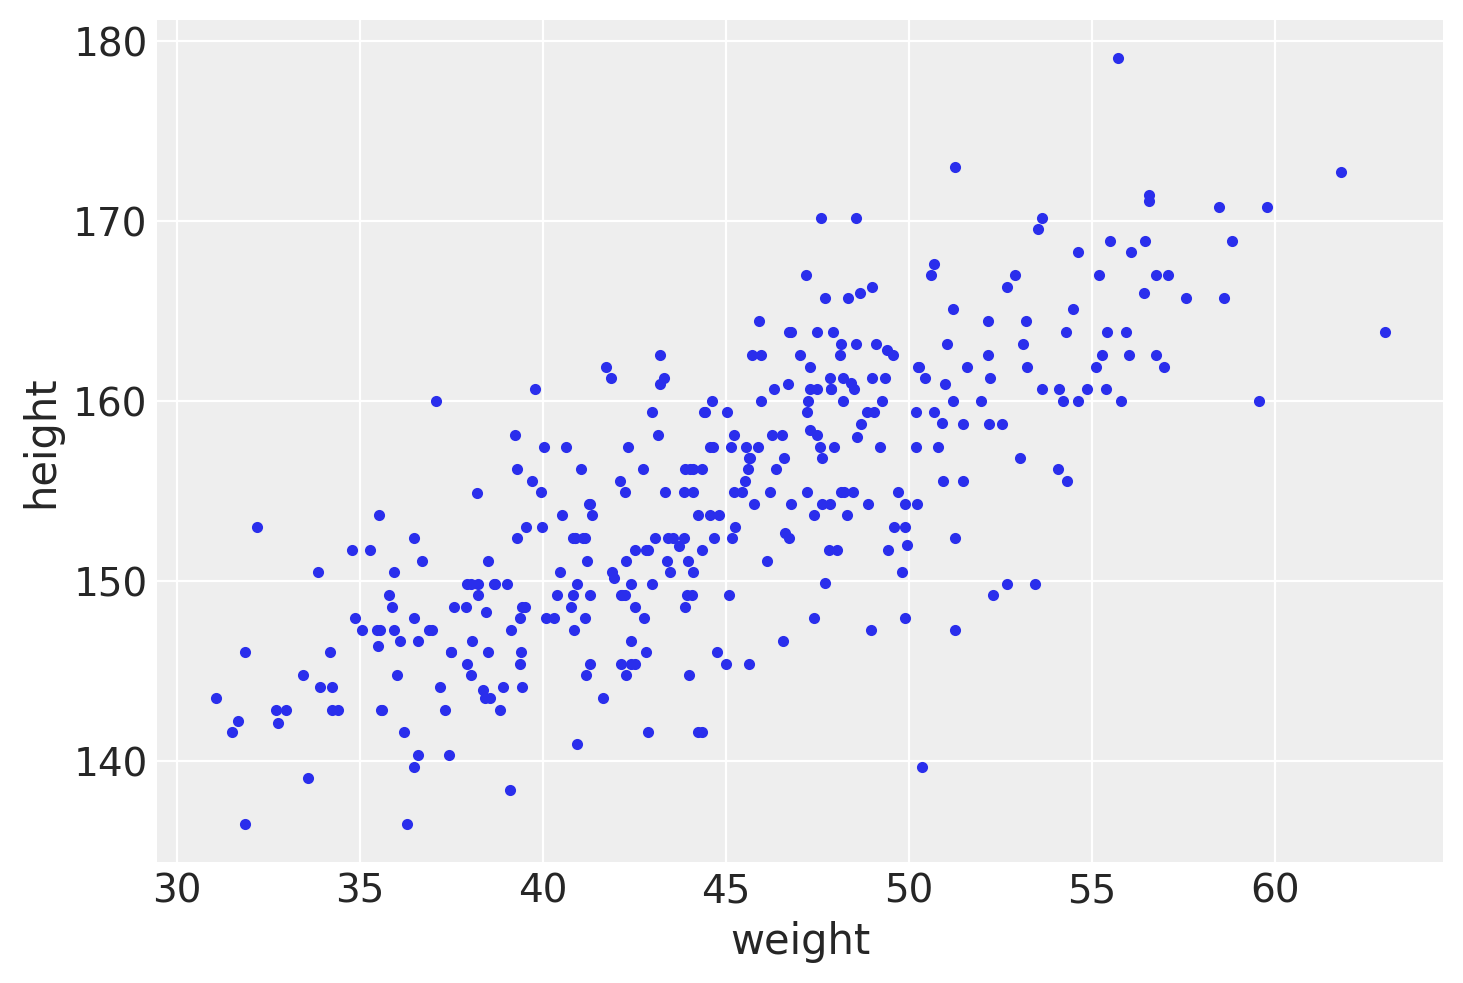

In [4]:
plt.plot(d2.weight, d2.height, ".")
plt.ylabel("height")
plt.xlabel("weight");

#### Rethinking: What is "regression"?

The term "regression" has come to mean using one or more predictor variables to model the distribution of one or more outcome variables. However, the term's original use seems to have come from anthropologist Francis Galton's (1822-1911) observation that the sons of tall men tended to be more similar to the population mean, hence the *regression to the mean.*

One of the causal explanations for height arises statistically whenever individual measurements are assigned a standard distribution, leading to a *shrinkage* where each measurement informs the other. In the context of height data, rather than predicting a son's height based on his father's, it's better to use the *population* of fathers. This means that we can expect a son's height to be similar to his father's but "shrink" it slightly towards the population mean. This same regression/shrinkage phenomenon applies at higher levels of abstraction in the multilevel modelling we'll see in Chapter 13 and is an idea that's also a foundation of population genetics.

From the plot, we can see that there's some relationship between the two variables in that knowing a person's weight may help you determine height. However, to transform this vague information into a quantitative model that relates values of `weight` to plausable values of `height`, we need to ask ourselves the question: *How do we incorporate predictor varaibles to our Gaussian model from previous sections?*

### 4.4.1. The Linear Model strategy.



One strategy we can explore for incorporating predictor variables into our previously built Gaussian models is by turning the mean distribution parameter ($\mu$) into a linear function of the predictor variable, along with any new parameters we decide to include. This strategy is called a **Linear Model** where our golem considers every combination of *parameter values* to compute the posterior distribution, representing the outcome's relative plausibility given the model and the data.

> However, one of the key differences with a linear model is that some of the parameters now represent the *strength of the association* between the mean of the outcome $\mu$ and the value of other parameters. As a result, the posterior distribution represents a ranking of various combinations of paramter values by their logical plausability as well as the strength of the relationship/association.

  One key assumption that our golem makes during this process is that our predictor variable (weight) has a *constant and additive relationship* with the mean of the outcome variable (height). In building our assumptions into a program, we're essentially asking the golem to: "*Consider all the lines that relate one variable to the other variable and then rank all these lines by their given plausibility, given the data.*" The result of this process will be a **posterior distribution of a Linear Model**. Recall the model we built earlier:

$ h_i \sim \text{Normal}(\mu, \sigma) $

$ \mu \sim \text{Normal}(178, 20) $

$ \sigma \sim \text{Uniform}(0, 50) $

<p><p><p>

Now, let's add two extra lines and a few changes in our variables to include our `weight` predictor variable into our Gaussian model of height:

$ h_i \sim \text{Normal}(\mu_i, \sigma) $ \[the likelihood \]

$ \mu_i = \alpha + \beta(w_i - \bar{w}) $ \[the linear model \]

$ \alpha \sim \text{Normal}(178, 20) $ \[the $\alpha$ prior \]

$ \beta \sim \text{Normal}(0, 10) $ \[the $\beta$ prior \]

$ \sigma \sim \text{Uniform}(0, 50) $ \[the $\sigma$ prior \]

$Where$:

- $w$ represents the column of our `d2['weight']` data which will have the same measurements as our height data.
- $\bar{w}$ represents the average value of our weight data which is about 45 kgs.
- $\mu_i$ is an individual value of height.
- $\alpha$ is equivalent to a linear regression's y-intercept.
- $\beta$ is equivalent to a linear regression's slope.

#### 4.4.1.1 *Probability of the data*/Likelihood.

Let's now break down each line of the model, starting with the first one: $ h_i \sim \text{Normal}(\mu_i, \sigma) $

As you can see, the first line is nearly identical to our first iteration of the model, except now we have $i$ attached to $\mu$ and $h$, which represent a little index or an individual value within these two parameter distributions. So if we see both $x_i$ and $h_i$ within the same line of the model, just now that we're referring to the same person's weight and height. Now, we can read these first lines as:

> "*An individual's height is distributed normally with the individual's population mean as well as the distribution's overall standard deviation.*"

What's important to emphasize here is that instead of extrapolating for a posterior distribution from a prior distribution, we're instead looking for a posterior distribution of an <u>individual's</u> height based on a single mean parameter value which was calculated from our linear model.  

**NOTE:** *Besides substituting $\mu$ for $\mu_i$ in the 1st line of our model, other changes we've made for the original include substituting our $\mu$ parameter for $\alpha$ in the 2nd and 3rd line (which we'll go over why in the next section, 4.4.1.2), and adding another $\beta$ parameter in the 4th line of the model.*

#### 4.4.1.2 *Linear Model*.

In the second line of the model, the mean $\mu$ is no longer a parameter to be estimated. Instead, it's now an $i$ndividual value for average height $\mu_i$ that can now be constructed from other variables ($\alpha$, $\beta$,  $\sigma$) that it now has a deterministic relationship with, as indicated by our use of "$=$" to link the two sides together rather than "$\sim$" which is used for stochastic relationships. In other words, if we know what $\alpha$, $\beta$, and $\sigma$ are, then we'll deterministically know what $\mu_i$ is with certainty.

Now, in terms of understanding what our new $\alpha$ and $\beta$ parameters are, let's just say we've made them up to allow us to manipulate our average height $\mu$ on a case-by-case basis with our given data. Let's revisit the equation for conducting linear regression and its similarity with our linear model:

$y = mx + b$ \[A Simple Linear Regression Equation \]

$ \mu_i = \alpha + \beta(w_i - \bar{w}) $ \[Our Linear Model \]

With this regression model we've just built, we're now asking it two questions about our data?

1. What is a person's expected height when their weight equals the population's average weight ($w_i = \bar{w}$)? In other words, what is the value of $\alpha$ when $\beta(0)$ is cancelled out? Thus, it becomes our **intercept** for this *regression* model.

2. What is a person's expected change in height when their weight ($w_i$) changes by 1 unit? This is just another way of asking what is the **slope** of the regression line which essentially represents a rate of change in expectation.

With these questions and new parameter values to represent their outcome, we're now essentially asking our golem to:

A) Fit a line that relates weight ($w$) to height ($h$),

B) Passes through the model's intercept value ($\alpha$) when $w_i = \bar{w}$,  

C) And has a slope of $\beta$.

#### Rethinking: There's nothing special or natural about Linear Models.

If you wanted to, you could choose a different definition for $\mu_i$ to express the relationship between it and $\alpha$ and $\beta$ such as:

$$ \mu_i = \alpha \exp(- \beta x_i) $$

The equation above does not represent a linear regression but rather, a regression model. In fields like ecology and demography, it is common to use functional forms of $\mu$ that come from theory rather than the geocentrism of linear models.

#### Overthinking: Units and regression models.

One thing to keep in mind while we're constructing our regression model is that our predictor variables come with different units, which in this case are *cm* and *kg*. For example, here's our formalized prior with their associated unit and without the priors:

$ h_i \text{cm} \sim \text{Normal}(\mu_i \text{cm}, \sigma \text{cm}) $

$ \mu_i \text{cm} = \alpha \text{cm} + \beta \frac{\text{cm}}{\text{kg}}(x_i \text{kg} - \bar{x}\text{kg}) $

One way to get around this is through **dimensionless analysis** which advocates constructing variables so that they are unit-less ratios to make things more natural and general. For example, in this case, we might consider dividing height by a reference height to remove its scales.

#### 4.4.1.3 *Priors*.

Going back to our updated model, lines 3-5 define the distributions for the unobserved variables (i.e. our parameters - $\alpha$, $\beta$, and $\sigma$).

$ \alpha \sim \text{Normal}(178, 20) $. Again, our $\alpha$ represents the model's intercept with the same distribution shape as $\mu$ in our previous iteration of the model.

$ \beta \sim \text{Normal}(0, 10) $. On the other hand, $\beta$ is a little stranger as it represents a Gaussian prior with a mean of 0 and a standard deviation of 10? All this prior tells us is that there is just as much probability that the slope $\beta$ can be above 0 as it can be below 0. And when the slope $\beta = 0$, it means that weight has no relationship to height. To figure out what this prior implies, we have to simulate the prior predictive distribution.

With that said, our goal for Code 4.38, 4.39, and 4.40 is to simulate heights from the model, using only the priors. We'll first consider the range of weight values to simulate over. Then, we need to simulate a bunch of lines which implies the priors for $\alpha$ and $\beta$.

#### Code 4.38

In [5]:
# This gives us 100 values each of the 'a' and 'b' distribution
height_rng = np.random.default_rng(2971)

N = 100  # 100 lines
a = stats.norm.rvs(178, 20, N)
b = stats.norm.rvs(0, 10, N)

Simulating the density of our Gaussian distribution of our beta prior.

array([[<Axes: title={'center': 'x'}>]], dtype=object)

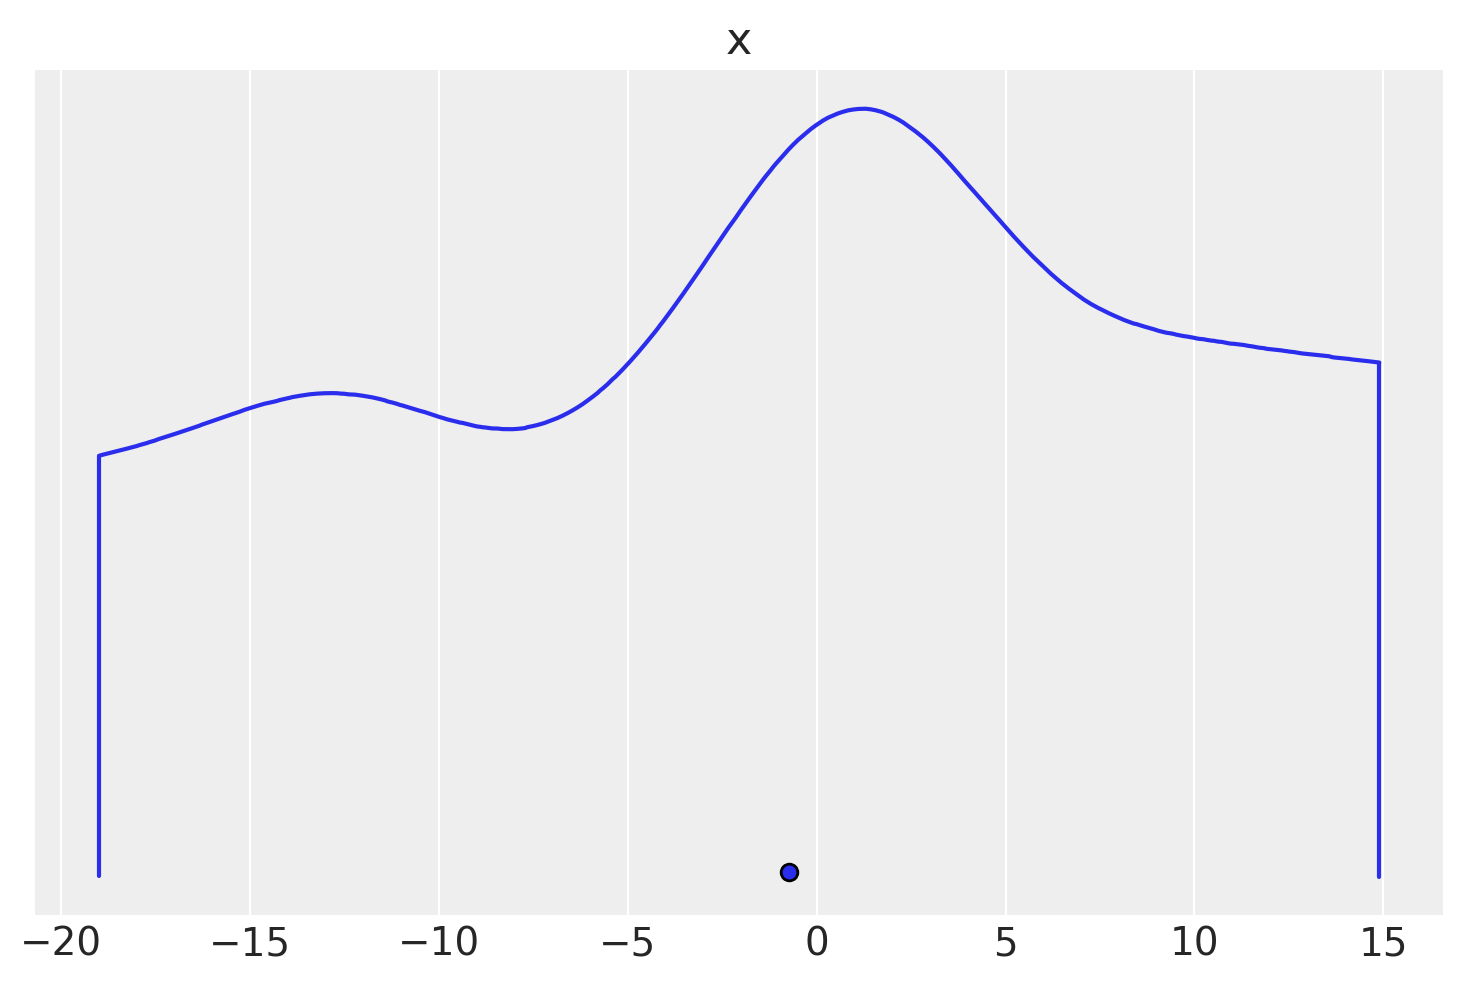

In [6]:
az.plot_density(b)

And of our alpha ($\alpha$) prior:

array([[<Axes: title={'center': 'x'}>]], dtype=object)

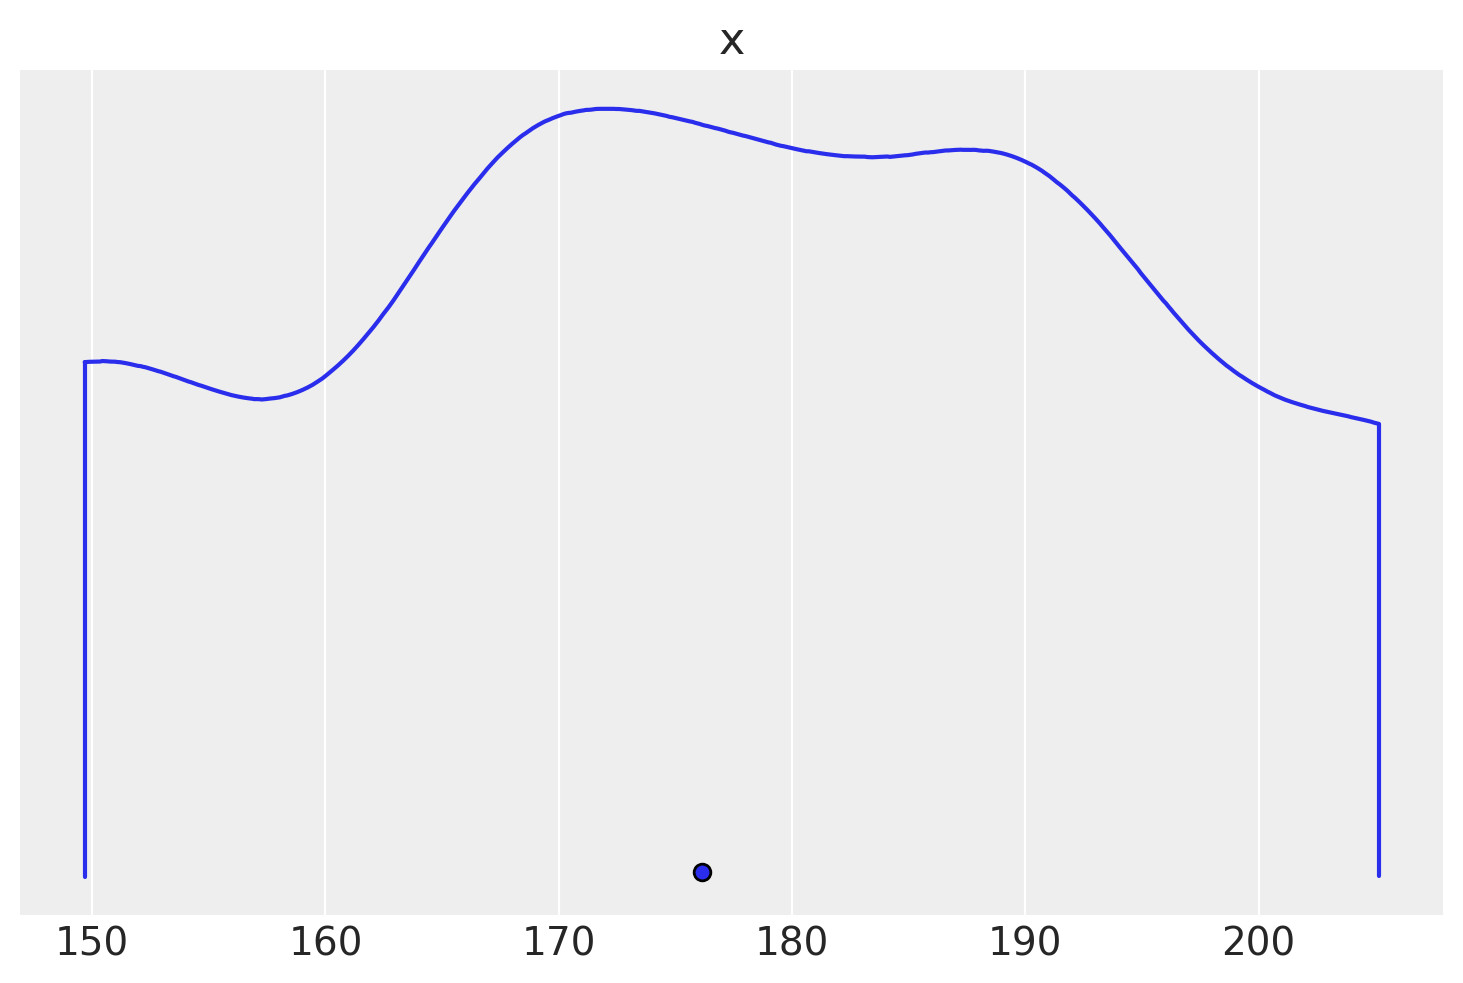

In [7]:
az.plot_density(a)

#### Code 4.39 and 4.41

##### Figure 4.5 Prior predictive simulation for height and weight.

Text(0.375, -0.05, 'Figure 4.5. Prior predictive simulation for the height and weight model. \n     Left: Simulation using the $ B \\sim Normal(0, 10)$ prior \n     Right: Simulation using a more sensible $ log(B) \\sim Normal(0, 1) $ prior.')

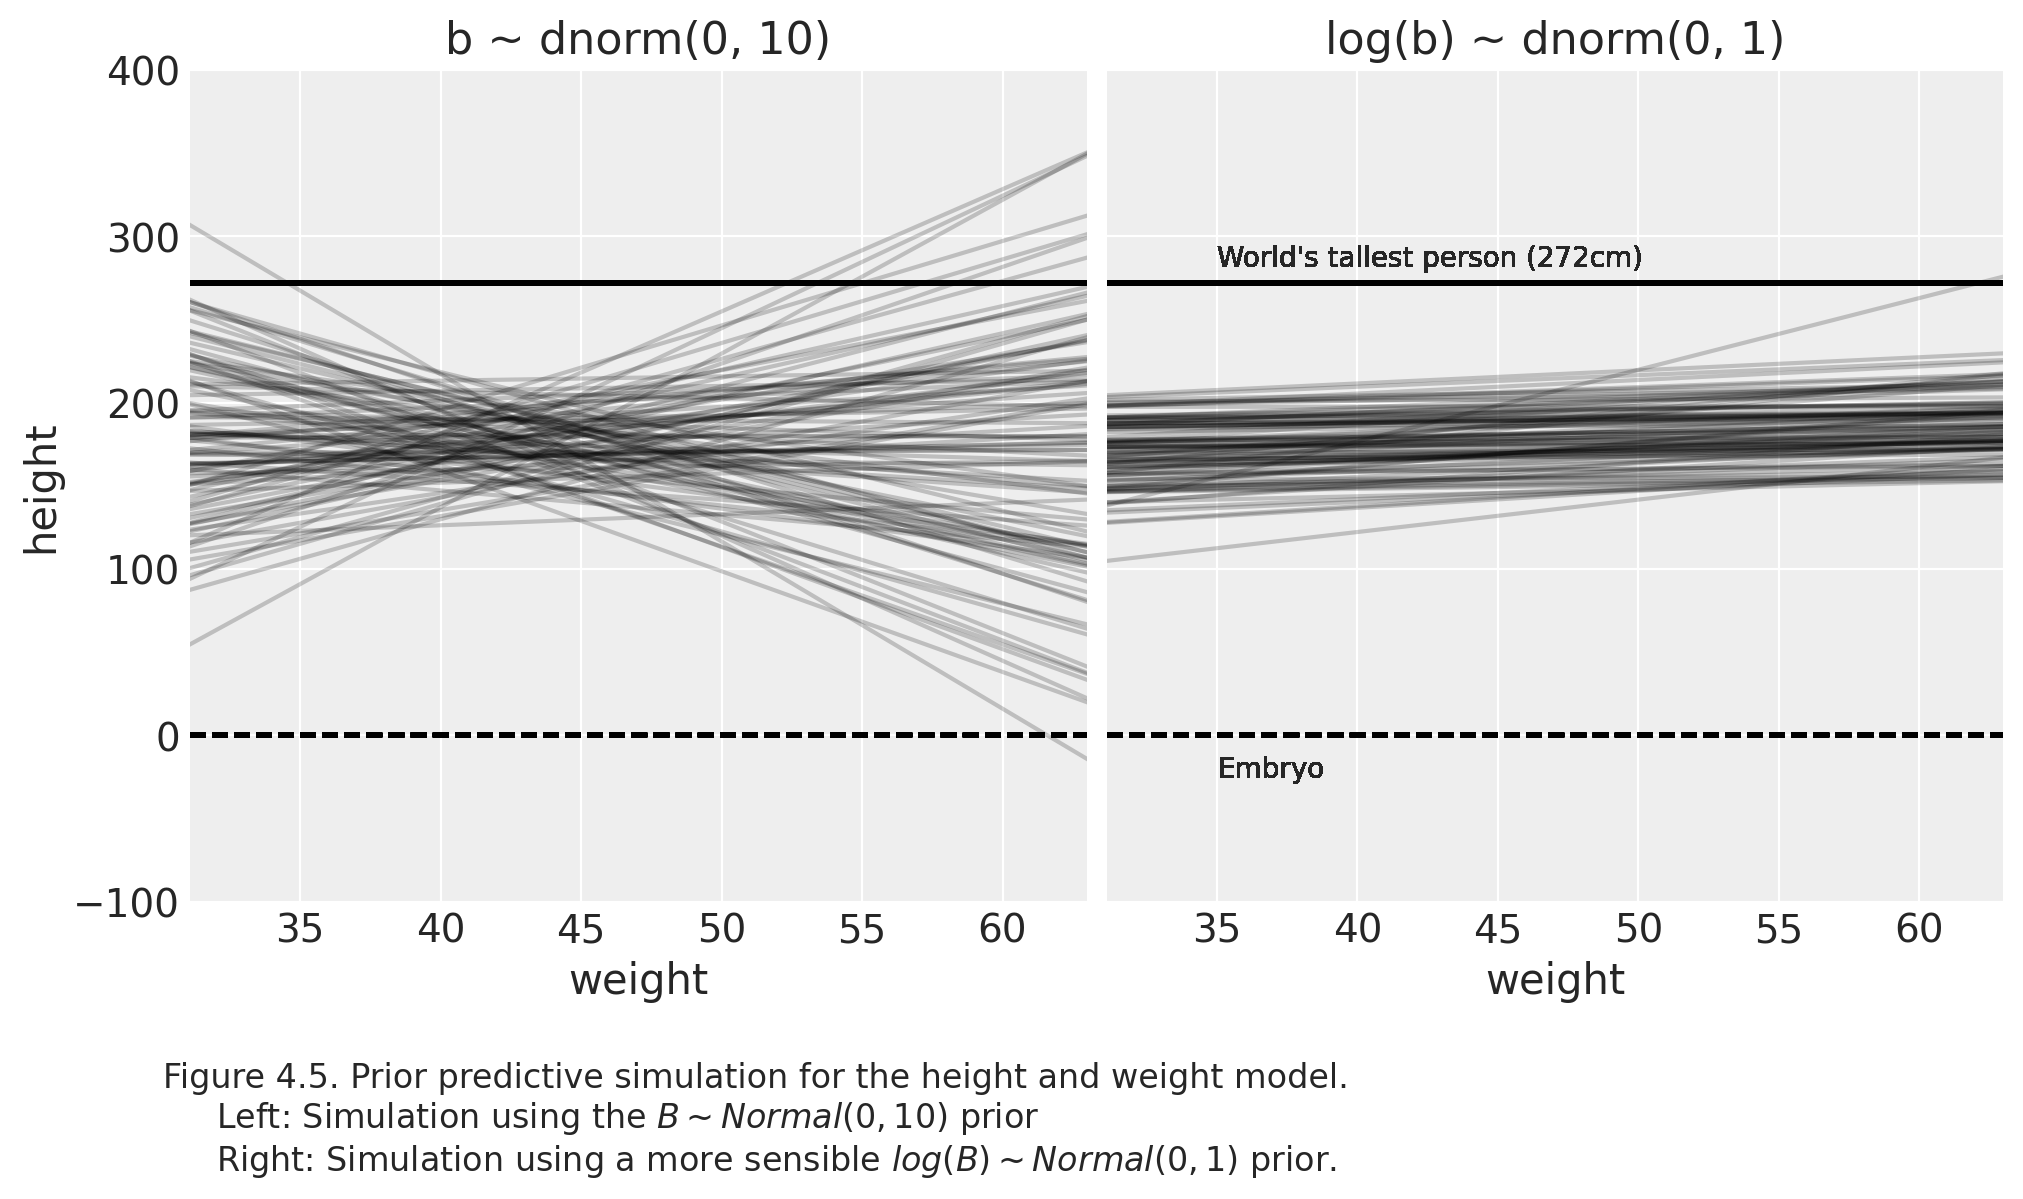

In [8]:
_, ax = plt.subplots(1, 2, sharey=True, figsize=(10, 5))

### Code 4.39 ###
xbar = d2.weight.mean()
x = np.linspace(d2.weight.min(), d2.weight.max(), N)
for i in range(N):
    ax[0].plot(a[i] + b[i] * (x - xbar), "k", alpha=0.2)
    ax[0].set_xlim(d2.weight.min(), d2.weight.max())
    ax[0].set_ylim(-100, 400)
    ax[0].axhline(0, c="k", ls="--")
    ax[0].axhline(272, c="k")
    ax[0].set_xlabel("weight")
    ax[0].set_ylabel("height")
    ax[0].set_title("b ~ dnorm(0, 10)")

### Code 4.41 ###
b_new = stats.lognorm.rvs(s=1, scale=1, size=100)
for i in range(N):
    ax[1].plot(a[i] + b_new[i] * (x - xbar), "k", alpha=0.2)
    ax[1].set_xlim(d2.weight.min(), d2.weight.max())
    ax[1].set_ylim(-100, 400)
    ax[1].axhline(0, c="k", ls="--", label="embryo")
    ax[1].axhline(272, c="k")
    ax[1].set_xlabel("weight")
    ax[1].text(x=35, y=282, s="World's tallest person (272cm)")
    ax[1].text(x=35, y=-25, s="Embryo")
    ax[1].set_title("log(b) ~ dnorm(0, 1)")

plt.suptitle(
    x=0.375,
    y=-0.05,
    t="Figure 4.5. Prior predictive simulation for the height and weight model. \n \
    Left: Simulation using the $ B \sim Normal(0, 10)$ prior \n \
    Right: Simulation using a more sensible $ log(B) \sim Normal(0, 1) $ prior.",
    ma="left"
  )

Our graph to the left gives us a prior that says that the relationship between weight and height could be absurdly positive or negative before it's seen the data. This isn't the greatest model because the pattern between weight and height doesn't look anything like the human population.

One way we can do better is by restricting this relationship to produce positive-only values. This is where we can introduce prior knowledge because we know there is some relationship between height and weight. All things being equal, the taller a person is, the more mass they should have in their body to make up that height. The way we can ensure that all our values are positive is by defining the prior as a Log-Normal distribution instead. Therefore, we can define our new prior for $\beta$ as:

$$ \beta \sim \text{Log-Normal}(0, 10)$$

#### Code 4.40

Let's also simulate the density for our new Log-Normal distribution using `scipy.stats.lognorm.rvs()` to get a sense of our $\beta$ prior. Also note, the probability density function for [`lognorm`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.lognorm.html) is the following formula:

$$ f(x, s) = \frac{1}{sx \sqrt{2 \pi}}\text{exp}(-\frac{\text{log}^2(x)}{2s^2}) $$

array([[<Axes: title={'center': 'x'}>]], dtype=object)

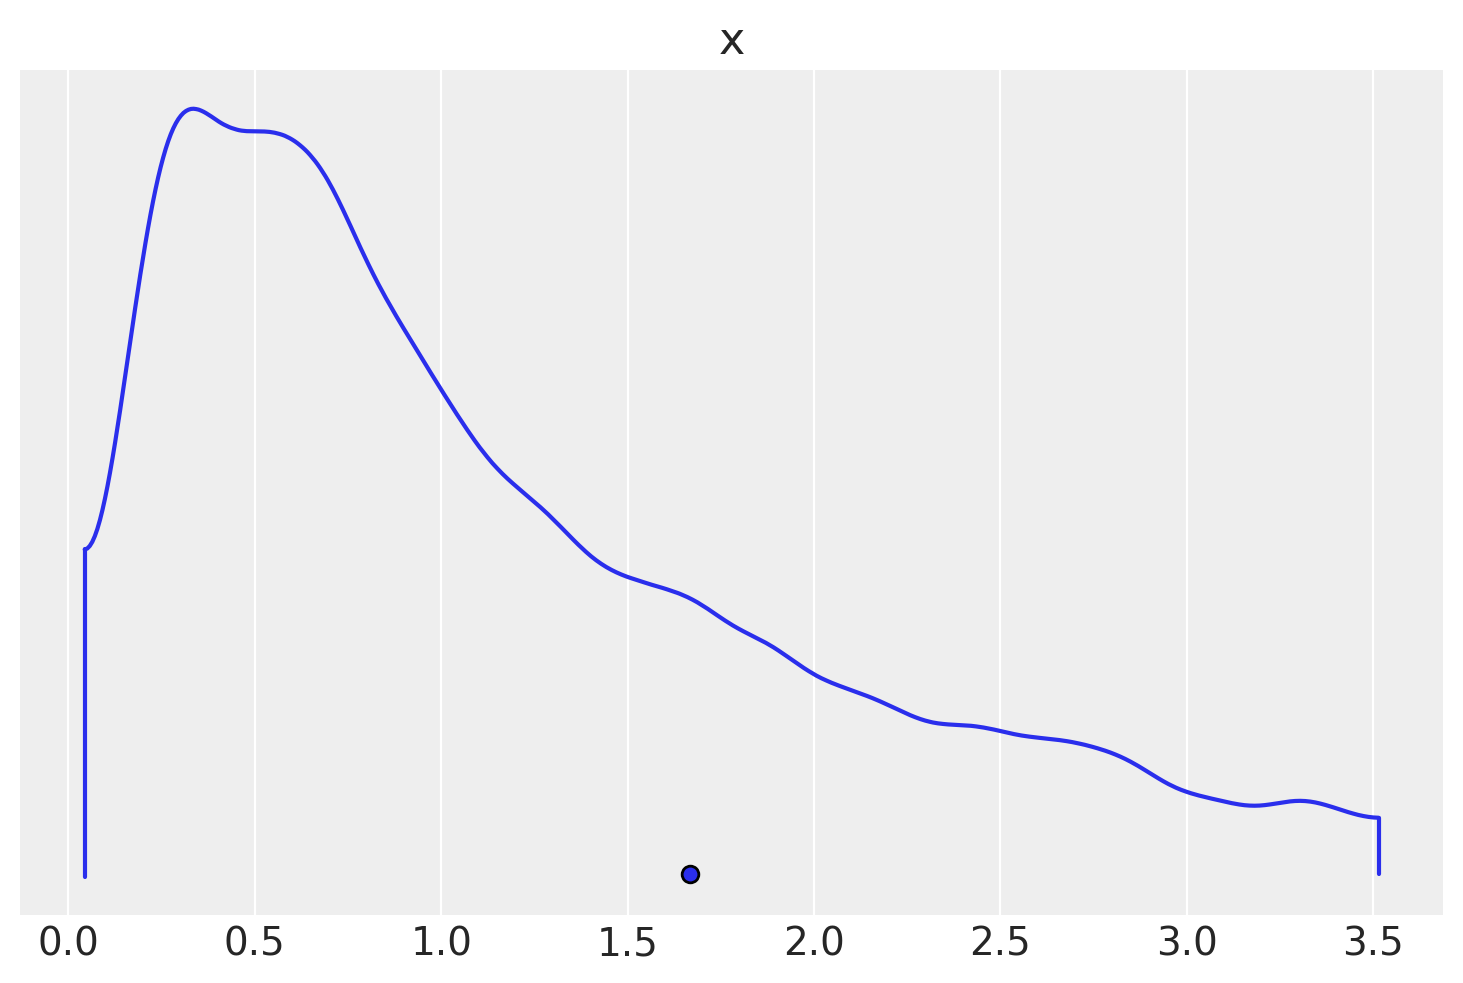

In [9]:
# Just another way of generating the log of the distribution
b_new2 = stats.lognorm.rvs(s=1, scale=np.exp(0), size=int(1e4))
az.plot_density(b_new2)

Now that we've produced a more sensible $\beta$ prior, all the regression lines on the right-hand plot in *Figure 4.5* now fall within human reason. Although we have enough data in our example so that the priors don't matter as much, there are oftentimes many analyses where no amount of data makes the priors irrelevant. Also, thinking about the priors help us develop better models, possibly ones that go beyond the inherent geocentrism that's a feature of regression models.

#### Rethinking: What's the correct prior?

People often make the mistake of assuming that for any given dataset, there is a uniquely correct prior that must be used, or else the analysis will fail. However, this is not the case! Priors can be wrong in the sense that we can select the wrong hammer from which to build a table.

Priors encode information before seeing the data, allowing us to see the consequences of integrating different information in our model. And when we have good prior information about our analysis that discounts the plausibility of some parameter values, such as the fact that we can't have negative associations between height or weight values, we can encode that information in our statistical golem. Even if we don't have much information, we at least know the range of plausible values that we can build into our priors.

Also, various *reasonable* priors can often lead to the same insights or inferences we get from the model.

> There's an illusion sometimes that default procedures are more objective than procedures that require a user's choice, such as choosing priors. If that's true, then all "objective" means is that everyone does the same things. It carries no guarantees of *realism or accuracy* (McElreath, 2020, p.97).

#### Rethinking: Prior predictive simulation and *p*-hacking.

One of the severe problems currently plaguing academic literature is known as "*p*-hacking," where practitioners adjust the model and the data to achieve a desired result which is usually a *p*-value of less than 5%. The problem with this is that when the model is adjusted based on the observed data, then the p-value no longer has any meaning and will therefore lead to false results. Although we don't focus on *p*-values in this book, there's still a similar danger in Bayesian statistics where a practitioner might choose priors based on the observed data. Remember that when we were building prior predictive simulations and choosing our priors, we're basing this decision <u>before</u> having seen the data and from our prior knowledge about the problem we're trying to solve of the underlying variables such as their constraints, ranges, or any theoretical relationships between them.

### 4.4.2.Finding the posterior distribution.

With all that said, let's encapsulate this change in the $\beta$ prior using the `pymc.Lognormal()` function instead, resulting in the updated model definition, `m4_3`, to help us build a posterior approximation:

$ \alpha \sim \text{Normal}(178, 20) $ \[the $\alpha$ prior / the y-intercept \]

$ \beta \sim \text{Log-Normal}(0, 10) $ \[the $\beta$ prior / the slope \]

$ \sigma \sim \text{Uniform}(0, 50) $ \[the $\sigma$ prior / the distribution of standard deviations \]

$ \mu_i = \alpha + \beta(w_i - \bar{w}) $ \[the linear model \]

$ h_i \sim \text{Normal}(\mu_i, \sigma) $ \[the likelihood \]


$Where$:

- $w$ represents the column of our `d2['weight']` data which will have the same measurements as our height data.
- $\bar{w}$ represents the average value of our weight data which is about 45 kgs.
- $\mu_i$ is an individual value of height.
- $\alpha$ is equivalent to a linear regression's y-intercept
- $\beta$ is equivalent to a linear regression's slope
- $h_i$ is the likelihood of an individual's height given the data.

#### Code 4.42

In [10]:
with pm.Model() as m4_3:
    a = pm.Normal("a", mu=178, sigma=20)
    b = pm.Lognormal("b", mu=0, sigma=1)
    sigma = pm.Uniform("sigma", 0, 50)
    mu = a + b * (d2.weight.values - xbar)
    height = pm.Normal("height", mu=mu, sigma=sigma, observed=d2.height.values)
    trace_4_3 = pm.sample(1000, tune=1000)

#### Rethinking: Everything that depends upon parameters has a posterior distribution.

To recap, with our current model, the average height $\mu$ is no longer a parameter as it has become a function of $\alpha$ and $\beta$. However, since $\alpha$ and $\beta$ have a joint posterior, so does $\mu$.

This is important:

> Everything that depends on parameters has uncertainty since parameters also carry a level of uncertainty. However, when we sample from the posterior, we <u>account for the uncertainty</u> in the distribution at any scale by computing the appropriate quantity of samples for each sample that reflects the posterior distribution.

#### Overthinking: Logs and exps, oh my.

As a recap, remember that when looking for something like the log of x, we're trying to identify what exponent $y$ of Euler's number $e$ will lead to the value of $x$. In NumPy, we can use the `np.log()` function to find the value of Euler's $e$ exponent ($y$), given $x$. For example, we're using $ y = \text{log}(x) $ to solve for the value of $y$ which is Euler's exponent: $$ e^y = x $$

On the other hand, the function `np.exp()` does the opposite of evaluating the value of $e$ to the power of $y$ to get us the value for $x$. For example, below we're solving for $x$:

$x = \text{exp}(y) $

In [11]:
y = 2
x = math.e**y

print(f"Euler's number, e: {math.e}^y = x \n")
print(f"Finding x by raising Euler's number to the power of y: x = exp(y) = {np.exp(y)} \n")
print(f"Finding y which is the value of the Euler exponent that leads to result of x: y = log(x) = {np.log(x)} ")

Euler's number, e: 2.718281828459045^y = x 

Finding x by raising Euler's number to the power of y: x = exp(y) = 7.38905609893065 

Finding y which is the value of the Euler exponent that leads to result of x: y = log(x) = 2.0 


#### Code 4.43

In Code 4.43, we can also achieve the same results as model `m4_3` by assigning a `pm.Normal` distribution to our $\beta$ prior and then manually converting the distribution into a `Lognormal` one within the `mu` line (4th) where we're building the linear model. We do this by evaluating the value of Euler's number $e$ to the power of each individual value $y$ in the $\beta$ prior's Normal distribution, using the function `np.exp()`. Although this slight change should result in the same predictions, nonetheless, we can reflect this change in the procedure by renaming our new model, `m4_3b`. Remember, we've already done this with the previous text box when we found the value of $x$ by raising Euler's number $e$ to the power of $y$.

And let's quickly compare these values from the `trace_4_3b` model where we manually converted the values from the $\beta$ distribution as a $\text{Log-Normal}(0, 1)$ one.

In [12]:
# What's interesting is that we get vastly different mean values for the
# slope of beta and it shows a negative relationship?

# ERROR - The original code generates a negative slope value in beta
with pm.Model() as m4_3b:
    a = pm.Normal("a", mu=178, sigma=20)
    b = pm.Normal("b", mu=0, sigma=1)
    sigma = pm.Uniform("sigma", 0, 50)
    mu = a + np.exp(b) * (d2.weight.values - xbar)
    height = pm.Normal("height", mu=mu, sigma=sigma, observed=d2.height.values)
    trace_4_3b = pm.sample(1000, tune=1000)

az.summary(trace_4_3b, kind="stats")

mean     sd  hdi_5.5%  hdi_94.5%
a      154.603  0.268   154.210    155.059
b       -0.105  0.047    -0.180     -0.032
sigma    5.102  0.189     4.806      5.396

In [13]:
##############
# CORRECTION #
##############

with pm.Model() as m4_3b:
    a = pm.Normal("a", mu=178, sigma=20)
    b_old = pm.Normal("b_old", mu=0, sigma=1)
    b = pm.Deterministic("b", pm.math.exp(b_old))
    sigma = pm.Uniform("sigma", 0, 50)
    mu = a + b * (d2.weight.values - xbar)
    height = pm.Normal("height", mu=mu, sigma=sigma, observed=d2.height.values)
    trace_4_3b = pm.sample(1000, tune=1000)

az.summary(trace_4_3b, kind="stats")

mean     sd  hdi_5.5%  hdi_94.5%
a      154.610  0.273   154.177    155.040
b_old   -0.104  0.046    -0.184     -0.035
sigma    5.111  0.188     4.821      5.403
b        0.903  0.041     0.832      0.965

A quick reminder on the difference between `np.log()` and `np.exp()`:

An important difference to highlight is that with `np.log(b)` and `np.exp(b)`, and with respect to generating a log-normal distribution, `np.log(b)` generates a normal distribution on a <u>logarithmic scale</u>, whereas `np.exp(b)` generates a <u>"log-normal" distribution</u>. For example: $ \{ e^{-5} = 0.007,.. e^0 = 1,... e^5 = 148.413\}$

In [14]:
for i in range(-2, 3, 1):
  print(f"e^y = {i} | y = {np.log(i)} (Doesn't make sense to convert to log-normal using `np.log()`)")

print("\n")

for i in range(-5, 6, 1):
  print(f"e^{i} = x | x = {np.exp(i)}")

e^y = -2 | y = nan (Doesn't make sense to convert to log-normal using `np.log()`)
e^y = -1 | y = nan (Doesn't make sense to convert to log-normal using `np.log()`)
e^y = 0 | y = -inf (Doesn't make sense to convert to log-normal using `np.log()`)
e^y = 1 | y = 0.0 (Doesn't make sense to convert to log-normal using `np.log()`)
e^y = 2 | y = 0.6931471805599453 (Doesn't make sense to convert to log-normal using `np.log()`)


e^-5 = x | x = 0.006737946999085467
e^-4 = x | x = 0.01831563888873418
e^-3 = x | x = 0.049787068367863944
e^-2 = x | x = 0.1353352832366127
e^-1 = x | x = 0.36787944117144233
e^0 = x | x = 1.0
e^1 = x | x = 2.718281828459045
e^2 = x | x = 7.38905609893065
e^3 = x | x = 20.085536923187668
e^4 = x | x = 54.598150033144236
e^5 = x | x = 148.4131591025766


<ipython-input-14-aa6b0ee563e2>:2: RuntimeWarning: invalid value encountered in log
  print(f"e^y = {i} | y = {np.log(i)} (Doesn't make sense to convert to log-normal using `np.log()`)")
<ipython-input-14-aa6b0ee563e2>:2: RuntimeWarning: divide by zero encountered in log
  print(f"e^y = {i} | y = {np.log(i)} (Doesn't make sense to convert to log-normal using `np.log()`)")


### 4.4.3. Interpreting the posterior distribution.

At this stage, although we've fit a model based on our research question, the model can only output a posterior distribution which means it's up to us to interpret this answer and make sense of it. The two main ways we accomplish this: Either by building a summary table OR plotting the simulation.

For some research questions, it's possible to learn a lot by generating tables of marginal values. However, it also becomes challenging to garner insights from tables alone when, for example, we have a decent amount of parameters so it's hard to ascertain which ones had a significant influence on the model's prediction. This is partly why it's important to simulate priors at the beginning of your analysis so we can understand their effect on the model's predictive power.

With all this being said, it's necessary to emphasize the importance of plotting posterior distributions and their predictions rather than interpreting what could potentially be a complex data table. Here are a few more reasons why it's essential to plot the implications of our model:

1. Plotting will help us determine whether or not the golem's fitting procedures worked correctly,
2. Plotting helps us understand the *absolute*, rather than the *relative*, magnitude of the relationship between our predictor variables and the outcome,
3. Plotting helps us understand the uncertainty surrounding an average relationship,
4. And lastly, plotting also helps us understand the uncertainty of the model's predictions which are distinct from the uncertainty that comes with our parameters.

#### Rethinking: What do parameters mean?

A fundamental issue with interpreting model-based estimates (i.e. predictions) is that it's often difficult to understand or interpret the meaning of the model's underlying parameters. If you work with a team of researchers, you may find there is often no consensus on what the parameters mean because everyone has differing opinions about the probability, the model, and the predictions they make.

The common Bayesian perspective we'll take in this book is that *posterior probabilities of parameter values describe the relative compatibility of the model's different states of the (small) world with the data.* Reasonable people may disagree with the model's views of the large world and the context in which it's making these predictions. However, this disagreement is actually productive as it leads us to scrutinize the model and make necessary revisions.

#### 4.4.3.1. Tables of marginal distributions.

#### Code 4.44

With the Linear Model we've built on the !Kung San data, let's inspect the *marginal posterior distributions* of the parameters:

In [15]:
az.summary(trace_4_3, kind="stats")

mean     sd  hdi_5.5%  hdi_94.5%
a      154.592  0.265   154.159    155.005
b        0.904  0.041     0.843      0.972
sigma    5.104  0.195     4.783      5.395

Each row in the table is the Markov-Chain Monte Carlo (MCMC) approximation for the parameters ($\alpha \text{, } \beta \text{, & } \sigma$).

Let's try to make sense of them now. Since $\beta$ is the slope with a mean value of 0.903, we can interpret this figure in a way that as *a person gets 1 kg heavier, we expect them to also be 0.903 cm taller*. From the mean, we can also gather that 89% of the probability distribution falls between slope values of 0.839 (`hdi_5.5%`) and 0.971 (`hdi_5.5%`). Of course, these are consistent with these **high-density interval (hdi)** values since the distribution also has a standard deviation of 0.042$\frac{cm}{kg}$ so therefore, any values that fall outside of this hdi range is highly implausible.

$Note:$ Just because we've successfully generated a linear model does not necessarily mean there is truly a linear relationship between `weight` and `height`. However, IF THERE IS a relationship between the two variables, then a linear model with a slope of 0.903 is HIGHLY PLAUSIBLE.

In [16]:
az.summary(trace_4_3b, kind="stats")

mean     sd  hdi_5.5%  hdi_94.5%
a      154.610  0.273   154.177    155.040
b_old   -0.104  0.046    -0.184     -0.035
sigma    5.111  0.188     4.821      5.403
b        0.903  0.041     0.832      0.965

#### Code 4.45

Let's also build a **variance-covariance matrix** to understand and visualize the relationships between each of the parameter distributions. You'll find that there is very little covariation between each of the parameters in this case.

In [17]:
trace_4_3_df = trace_4_3.posterior.to_dataframe()
trace_4_3_df.cov().round(3)

a      b  sigma
a      0.070  0.000  0.002
b      0.000  0.002  0.000
sigma  0.002  0.000  0.038

<Axes: >

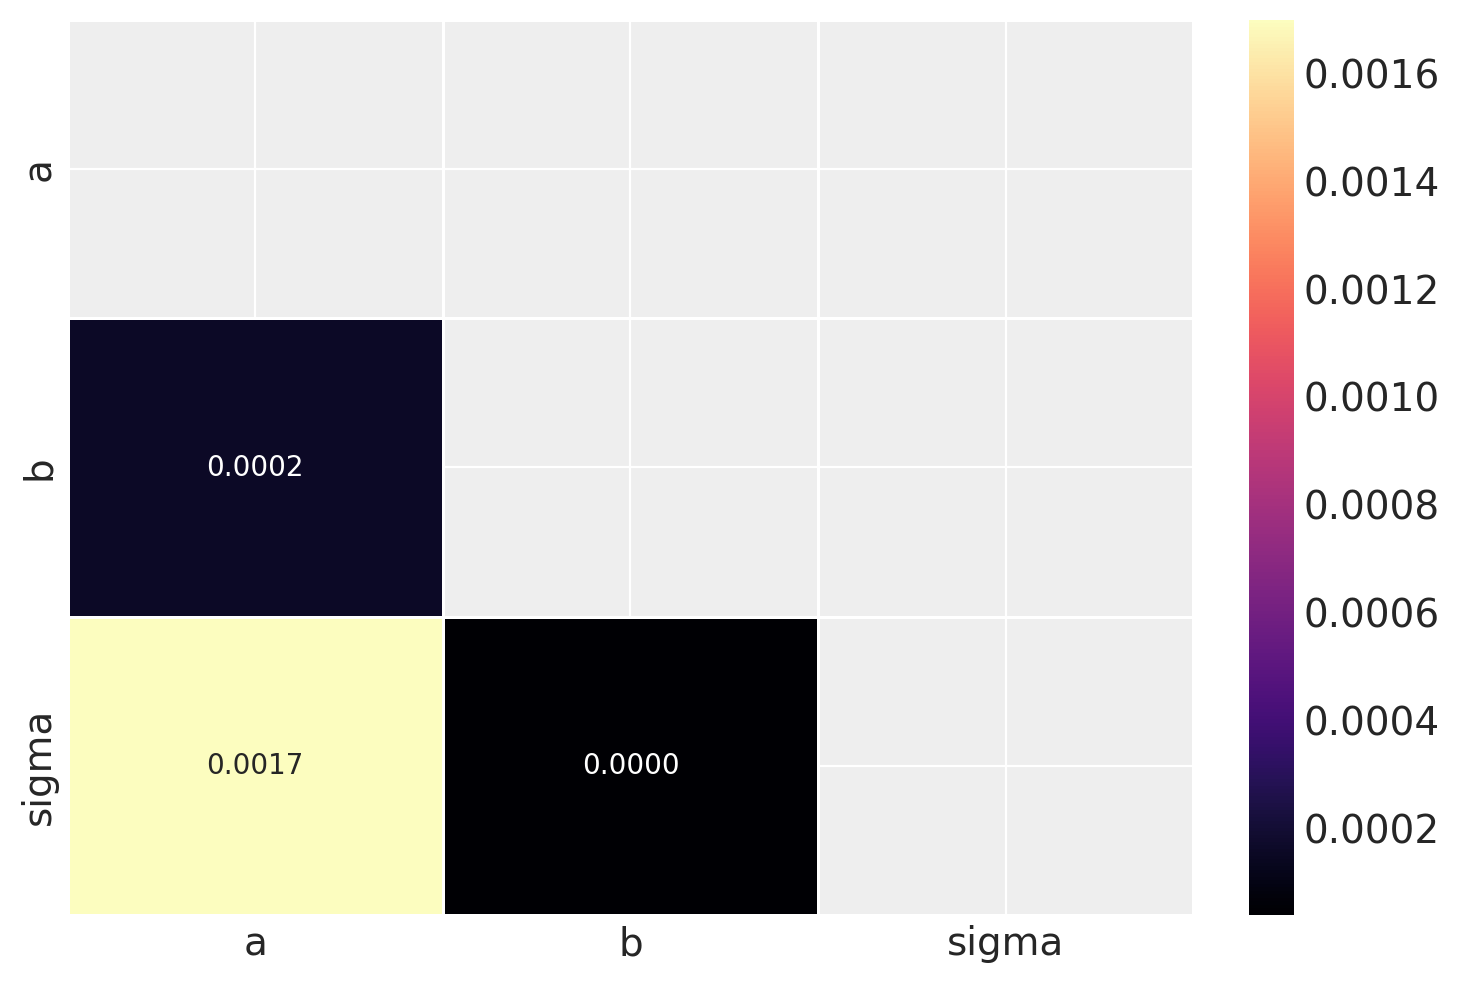

In [18]:
t43_cov = trace_4_3_df.cov()
trimask = np.triu(np.ones_like(t43_cov, dtype=bool))
sns.heatmap(t43_cov, annot=True, fmt=".4f", linewidth=.5, cmap='magma', mask=trimask)

#### 4.4.3.2. Plotting posterior inference against the data.

As we've iterated at the beginning of 4.43, it's always more useful to plot the posterior inference against the data. Not only does potting help in interpreting the posterior, but it also provides an informal check on model assumptions. If the model's predictions don't come close to the observations or patterns in the plotted data, then we can suspect that the model either did not fit with the data correctly OR that it was badly specified.

#### Code 4.46

Let's start with a simple plot by superimposing the posterior's mean values over the height and weight data. The code below first plots the raw data, then computes the posterior mean values for $\alpha$ and $\beta$, before drawing the implied regression line:

Text(0.5, -0.05, 'Figure 4.6. Height in centimeters (y-axis) \n     plotted against weight in kilograms (x-axis), \n     with the line at the posterior mean plotted in black.')

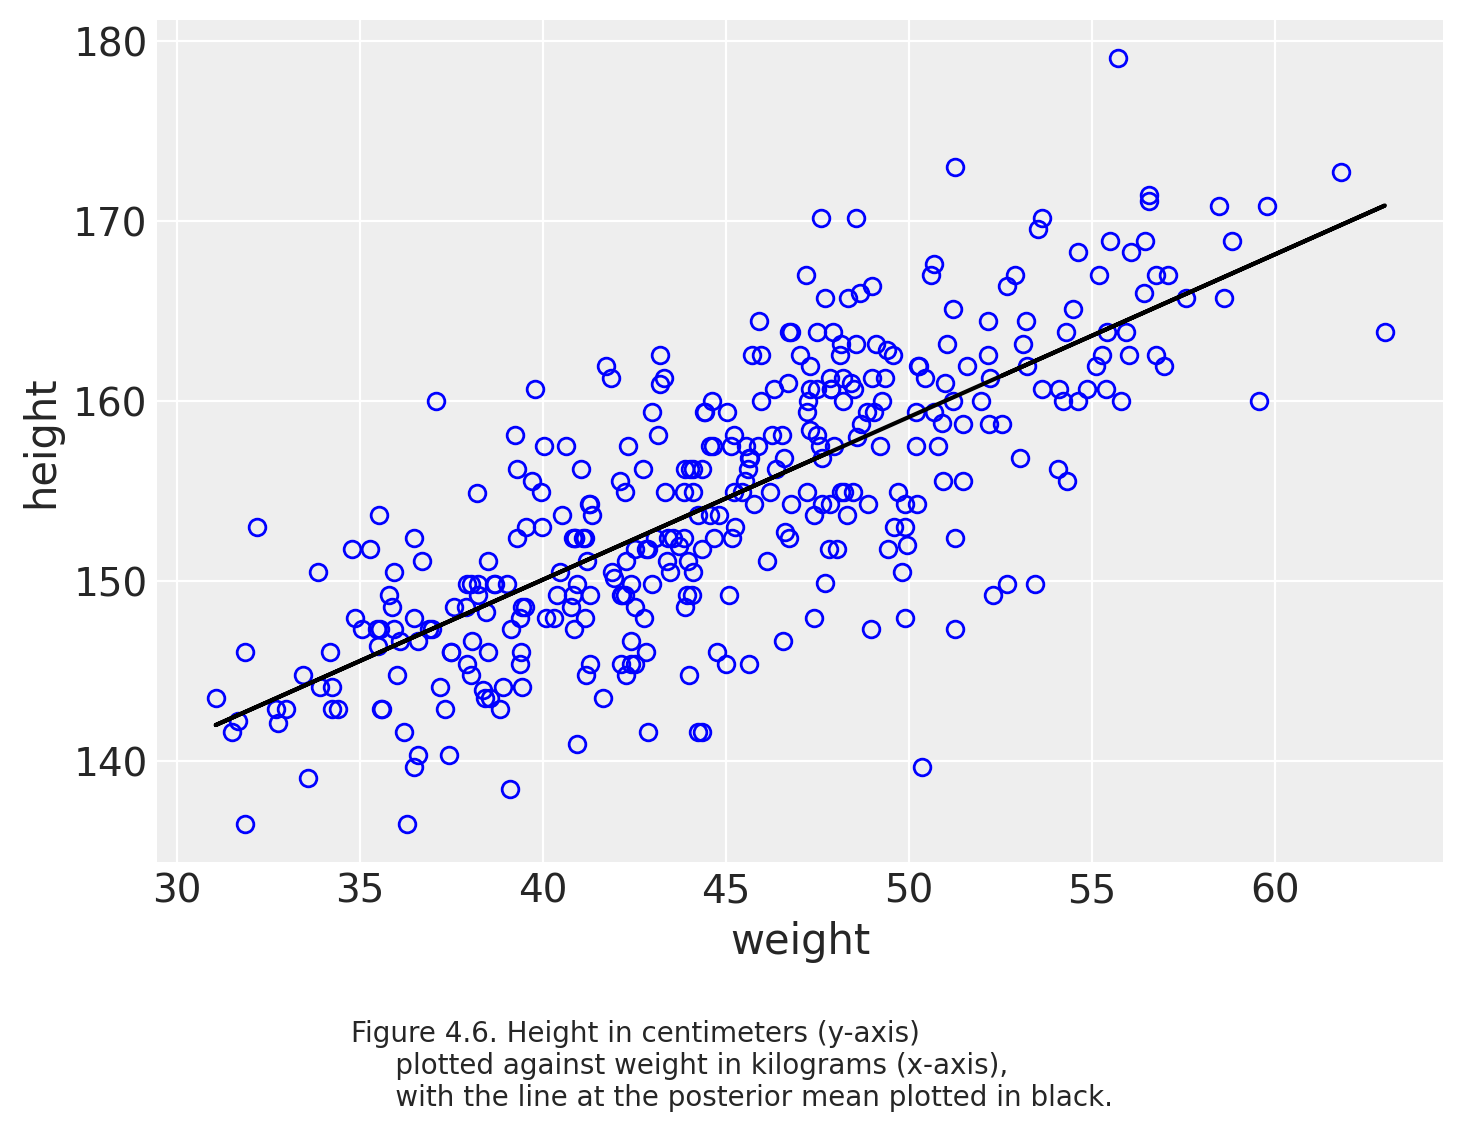

In [19]:
plt.plot(d2.weight, d2.height, marker="o", color="none", markeredgecolor="blue") # The scatterplot of original data
plt.plot(
    # The x-axis
    d2.weight,

    # The y-axis (i.e result of each value in the linear model): y = a + b(w - avg(w))
    trace_4_3.posterior["a"].mean().item(0)  # The y-intercept: a = 154.603 + ...
    + trace_4_3.posterior["b"].mean().item(0) * (d2.weight - xbar), # slope(b) x (each value - its avg)
    # = The predicted height and weight value

    c="black"
)
plt.xlabel(d2.columns[1])
plt.ylabel(d2.columns[0])
plt.suptitle(
    x=0.5,
    y=-0.05,
    t="Figure 4.6. Height in centimeters (y-axis) \n \
    plotted against weight in kilograms (x-axis), \n \
    with the line at the posterior mean plotted in black.",
    ma="left",
    fontsize="medium"
  )

After we've built our first regression model, we can slowly add more information to the prediction plots until we've used the entire posterior distribution. So far, our regression in **Figure 4.6** looks highly plausible.

However, we can draw an infinite number of other highly plausible lines which we'll do from `Code 4.47 - 4.49`:

Now let's see what happens when we use the sampled posterior from `trace_4_3b`:

Text(0.5, -0.05, 'Alternate Figure 4.6.')

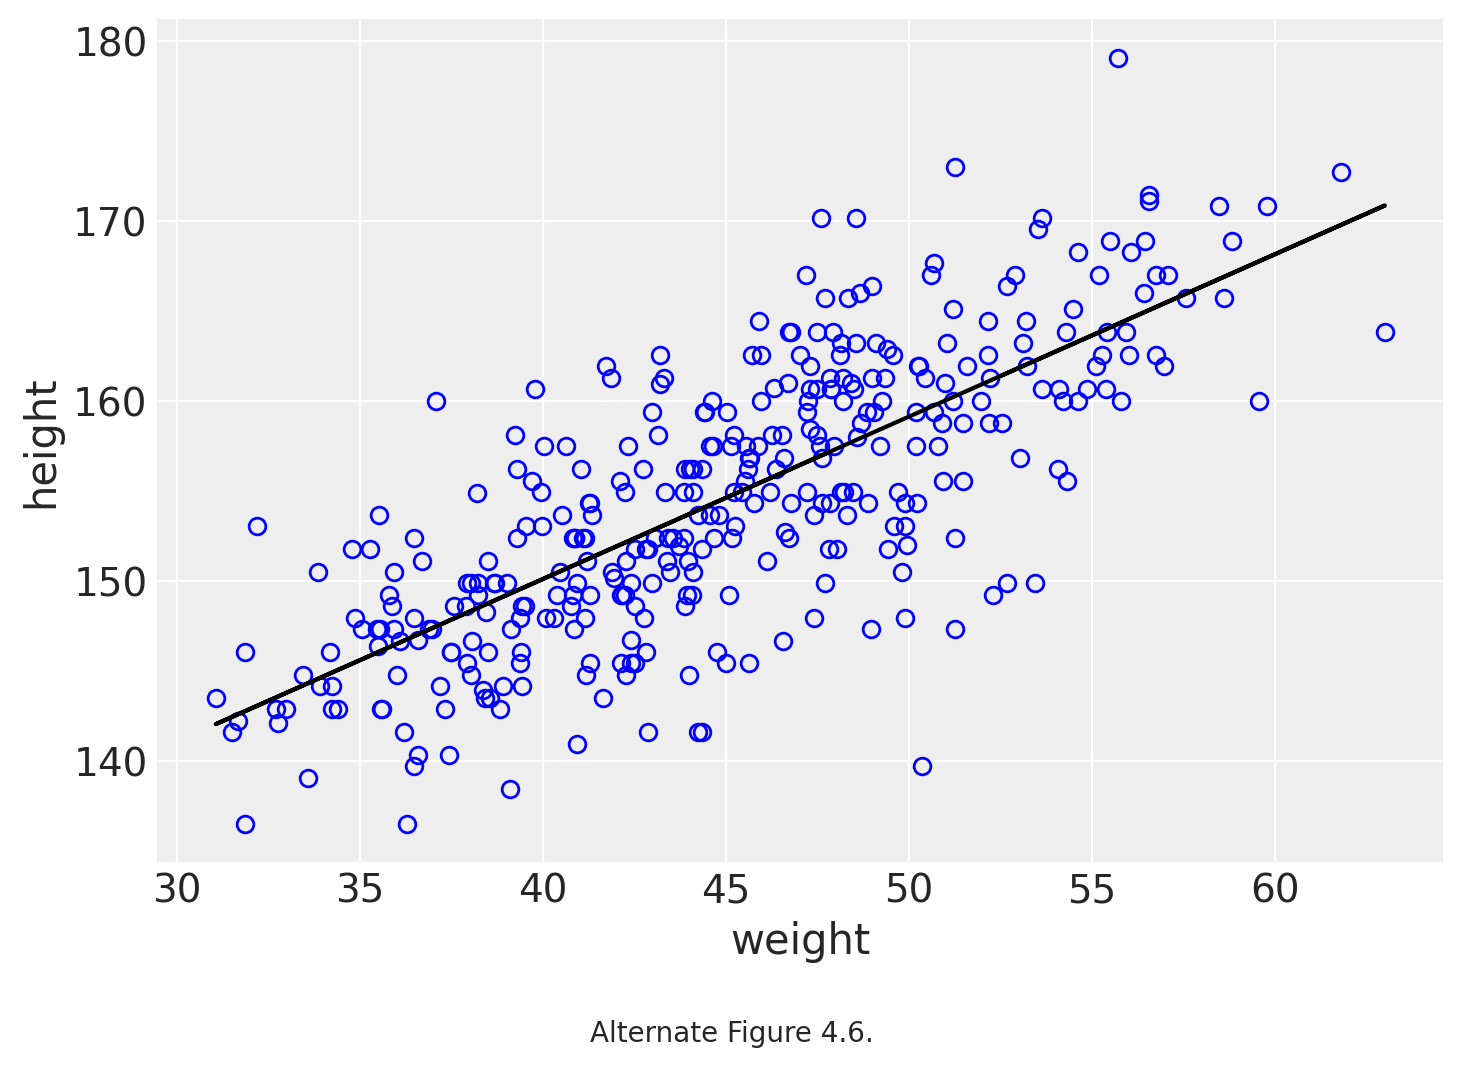

In [20]:
plt.plot(d2.weight, d2.height, marker="o", color="none", markeredgecolor="blue") # The scatterplot of original data
plt.plot(
    # The x-axis
    d2.weight,

    # The y-axis (i.e result of each value in the linear model): y = a + b(w - avg(w))
    trace_4_3b.posterior["a"].mean().item(0)  # The y-intercept: a = 154.603 + ...
    + trace_4_3b.posterior["b"].mean().item(0) * (d2.weight - xbar), # slope(b) x (each value - its avg)
    # = The predicted height and weight value

    c="black"
)
plt.xlabel(d2.columns[1])
plt.ylabel(d2.columns[0])
plt.suptitle(
    x=0.5,
    y=-0.05,
    t="Alternate Figure 4.6.",
    ma="left",
    fontsize="medium"
  )

#### 4.4.3.3. Adding uncertainty around the mean.

We must remember that the linear regression line is just the posterior mean - the most plausible line in the infinite universe of lines in the posterior distribution, such as the one we have in **Figure 4.6**. Plots of the average line are useful for understanding the estimated impact of a variable (again, `weights` in this instance), but they do a poor job of communicating uncertainty.

As a reminder, the posterior distribution assigns a relative plausibility to every possible regression line connecting height to weight (so basically every combination of the $\alpha$ and the $\beta$ priors).

We could see situations where there are many lines with similar posterior probabilities as the average line. We might also find a narrow posterior distribution near the average line, meaning there is more variance in this distribution.  

One way to account for this uncertainty in the variance between the posterior parameter values is by sampling them and then plotting the resulting lines to visualize the regression relationship.

#### Code 4.47

In [21]:
trace_4_3_df.head(5)

a         b     sigma
chain draw                                
0     0     154.832114  0.981736  5.206196
      1     154.247863  0.831690  4.975119
      2     154.524644  0.860730  4.978532
      3     154.692634  0.959367  4.995296
      4     154.501764  0.871973  4.957740

Each row in our `trace_4_3.posterior` DataFrame is a posterior MCMC estimate of each parameter value in our regression model. We generated our initial "average line" partly through the mean of the resulting $\alpha$ and $\beta$ values in the DataFrame. In the following plot, we're investigating the variance around the average because it helps inform our confidence and understanding of the relationship between the predictor and the outcome.

#### Code 4.48

First, let's display what the regression model looks like if we only use the first 10 rows in our `d2` dataset so that we can visualize how adding more data changes the scatter lines.

In [22]:
N = [10, 50, 150, 352][0]
dN = d2[:N] # Displays only the first 10 values in the dataset
with pm.Model() as m_N:
    a = pm.Normal("a", mu=178, sigma=100)
    b = pm.Lognormal("b", mu=0, sigma=1)
    sigma = pm.Uniform("sigma", 0, 50)

    # Rather than manually inputting our Linear Model each time:
    ### mu = (mean(a) = 154.603) + (mean(b) = 0.903) * (d2.weight - xbar) ###
    # We can use `pymc.Deterministic()` instead which produces our
    # predictions from our linear model
    mu = pm.Deterministic("mu", a + b * (dN.weight.values - dN.weight.mean()))
    height = pm.Normal("height", mu=mu, sigma=sigma, observed=dN.height.values)
    chain_N = pm.sample(1000, tune=1000)

trace_N = az.extract_dataset(chain_N)

<ipython-input-22-3464ce91fdee>:16: FutureWarning: extract_dataset has been deprecated, please use extract
  trace_N = az.extract_dataset(chain_N)


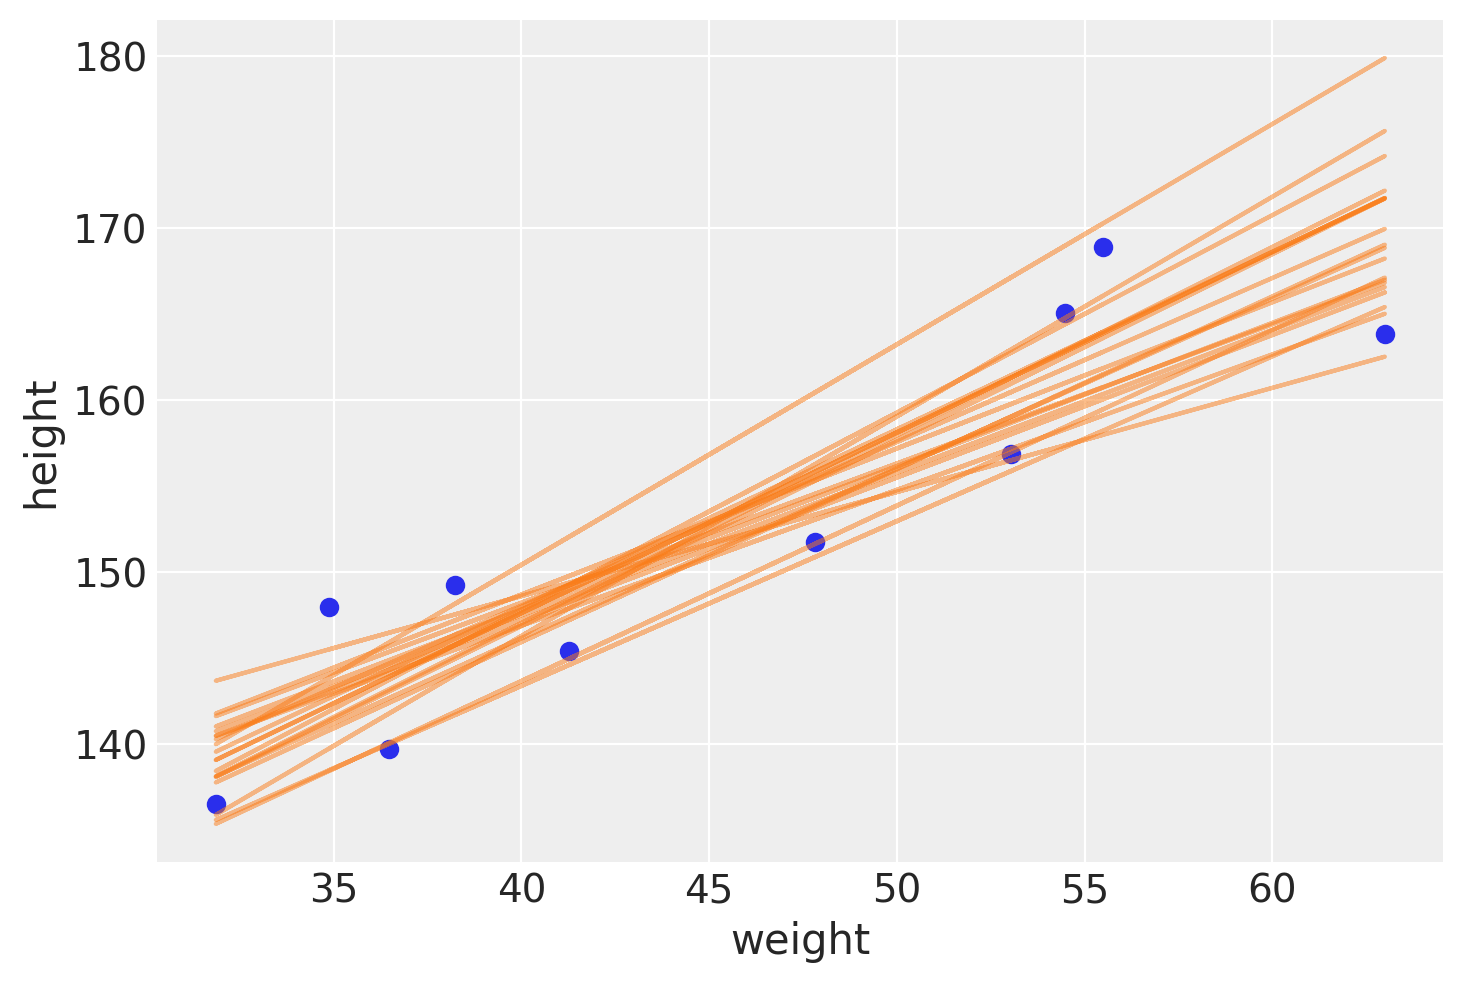

In [23]:
plt.plot(dN.weight, dN.height, "C0o") # Plots only the first 10 rows in the dataset.
nb_samples = trace_N.sizes["sample"] #2000
idxs = height_rng.integers(nb_samples, size=20) # 20 random integers between 0-2000
for idx in idxs: # Plots regression lines from each of the 20 values sampled in the a & b param.
    plt.plot(
        dN.weight,
        trace_N["a"].item(idx) + trace_N["b"].item(idx) * (dN.weight - dN.weight.mean()),
        "C1-",
        alpha=0.5,
    )
plt.xlabel(d2.columns[1])
plt.ylabel(d2.columns[0]);

Alternative we can directly use the deterministic `mu` variable

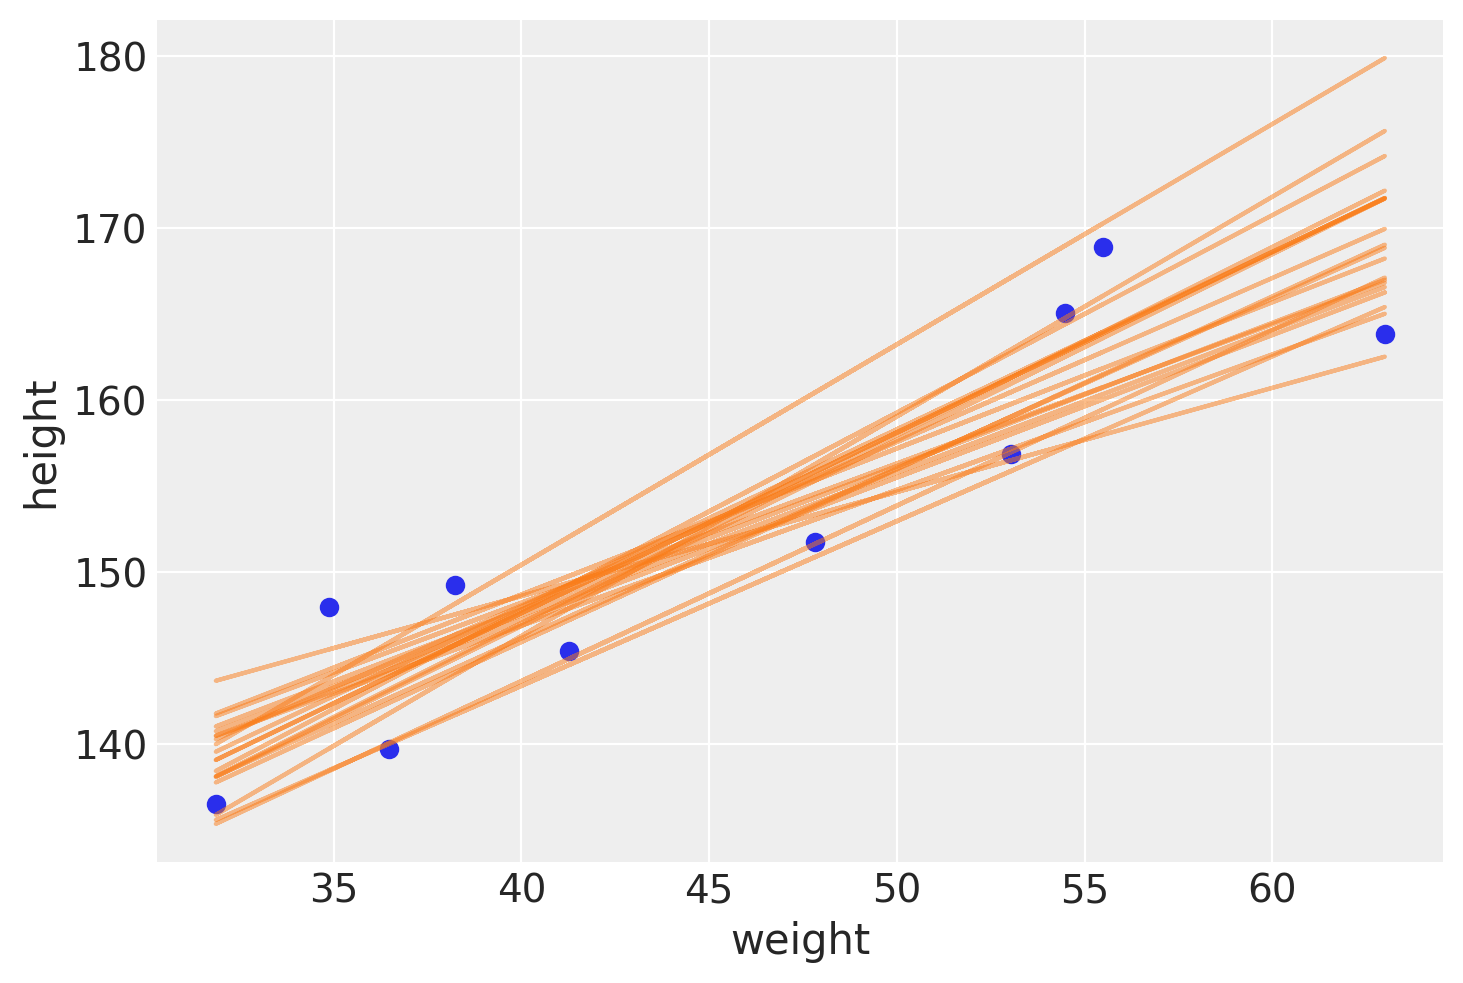

In [24]:
plt.plot(dN.weight, dN.height, "C0o")
for idx in idxs:
    plt.plot(d2.weight[:N], trace_N["mu"][:, idx], "C1-", alpha=0.5)
plt.xlabel(d2.columns[1])
plt.ylabel(d2.columns[0]);

#### Code 4.49

Now let's plot 20 regression lines sampled from the posterior parameters values to visualize the model's uncertainty, especially as we add more data for our model to fit.

In [25]:
N = [10, 50, 150, 352]

data = [] # Stores the first 10, 50, 150, and 352 rows of our orig. dataset.
traces = [] # Stores the sampled posterior dist from each variation of fitted data.
for n in N:
    dN = d2[:n]
    with pm.Model() as m_N:
        a = pm.Normal("a", mu=178, sigma=100)
        b = pm.Lognormal("b", mu=0, sigma=1)
        sigma = pm.Uniform("sigma", 0, 50)
        mu = pm.Deterministic("mu", a + b * (dN.weight.values - dN.weight.mean()))
        height = pm.Normal("height", mu=mu, sigma=sigma, observed=dN.height.values)
        traces.append(pm.sample(1000, tune=1000, progressbar=True))
        data.append(dN)

<ipython-input-26-32edeb4dea69>:5: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "C0o" (-> marker='o'). The keyword argument will take precedence.
  ax[cords[i]].plot(
<ipython-input-26-32edeb4dea69>:5: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "C0o" (-> color=(0.16470588235294117, 0.1803921568627451, 0.9254901960784314, 1.0)). The keyword argument will take precedence.
  ax[cords[i]].plot(
<ipython-input-26-32edeb4dea69>:19: FutureWarning: extract_dataset has been deprecated, please use extract
  az.extract_dataset(traces[i])["mu"][:, idx],
<ipython-input-26-32edeb4dea69>:17: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "C1-" (-> color=(0.9803921568627451, 0.48627450980392156, 0.09019607843137255, 1.0)). The keyword argument will take precedence.
  ax[cords[i]].plot(


Text(0.375, -0.05, 'Figure 4.7. Samples from the MCMC approximate posterior distribution \n     for the height/weight model, m_N, with increasing amounts of data. \n     In each plot, 20 lines sampled from the posterior distribution, \n      showing the uncertainty in the regression relationship')

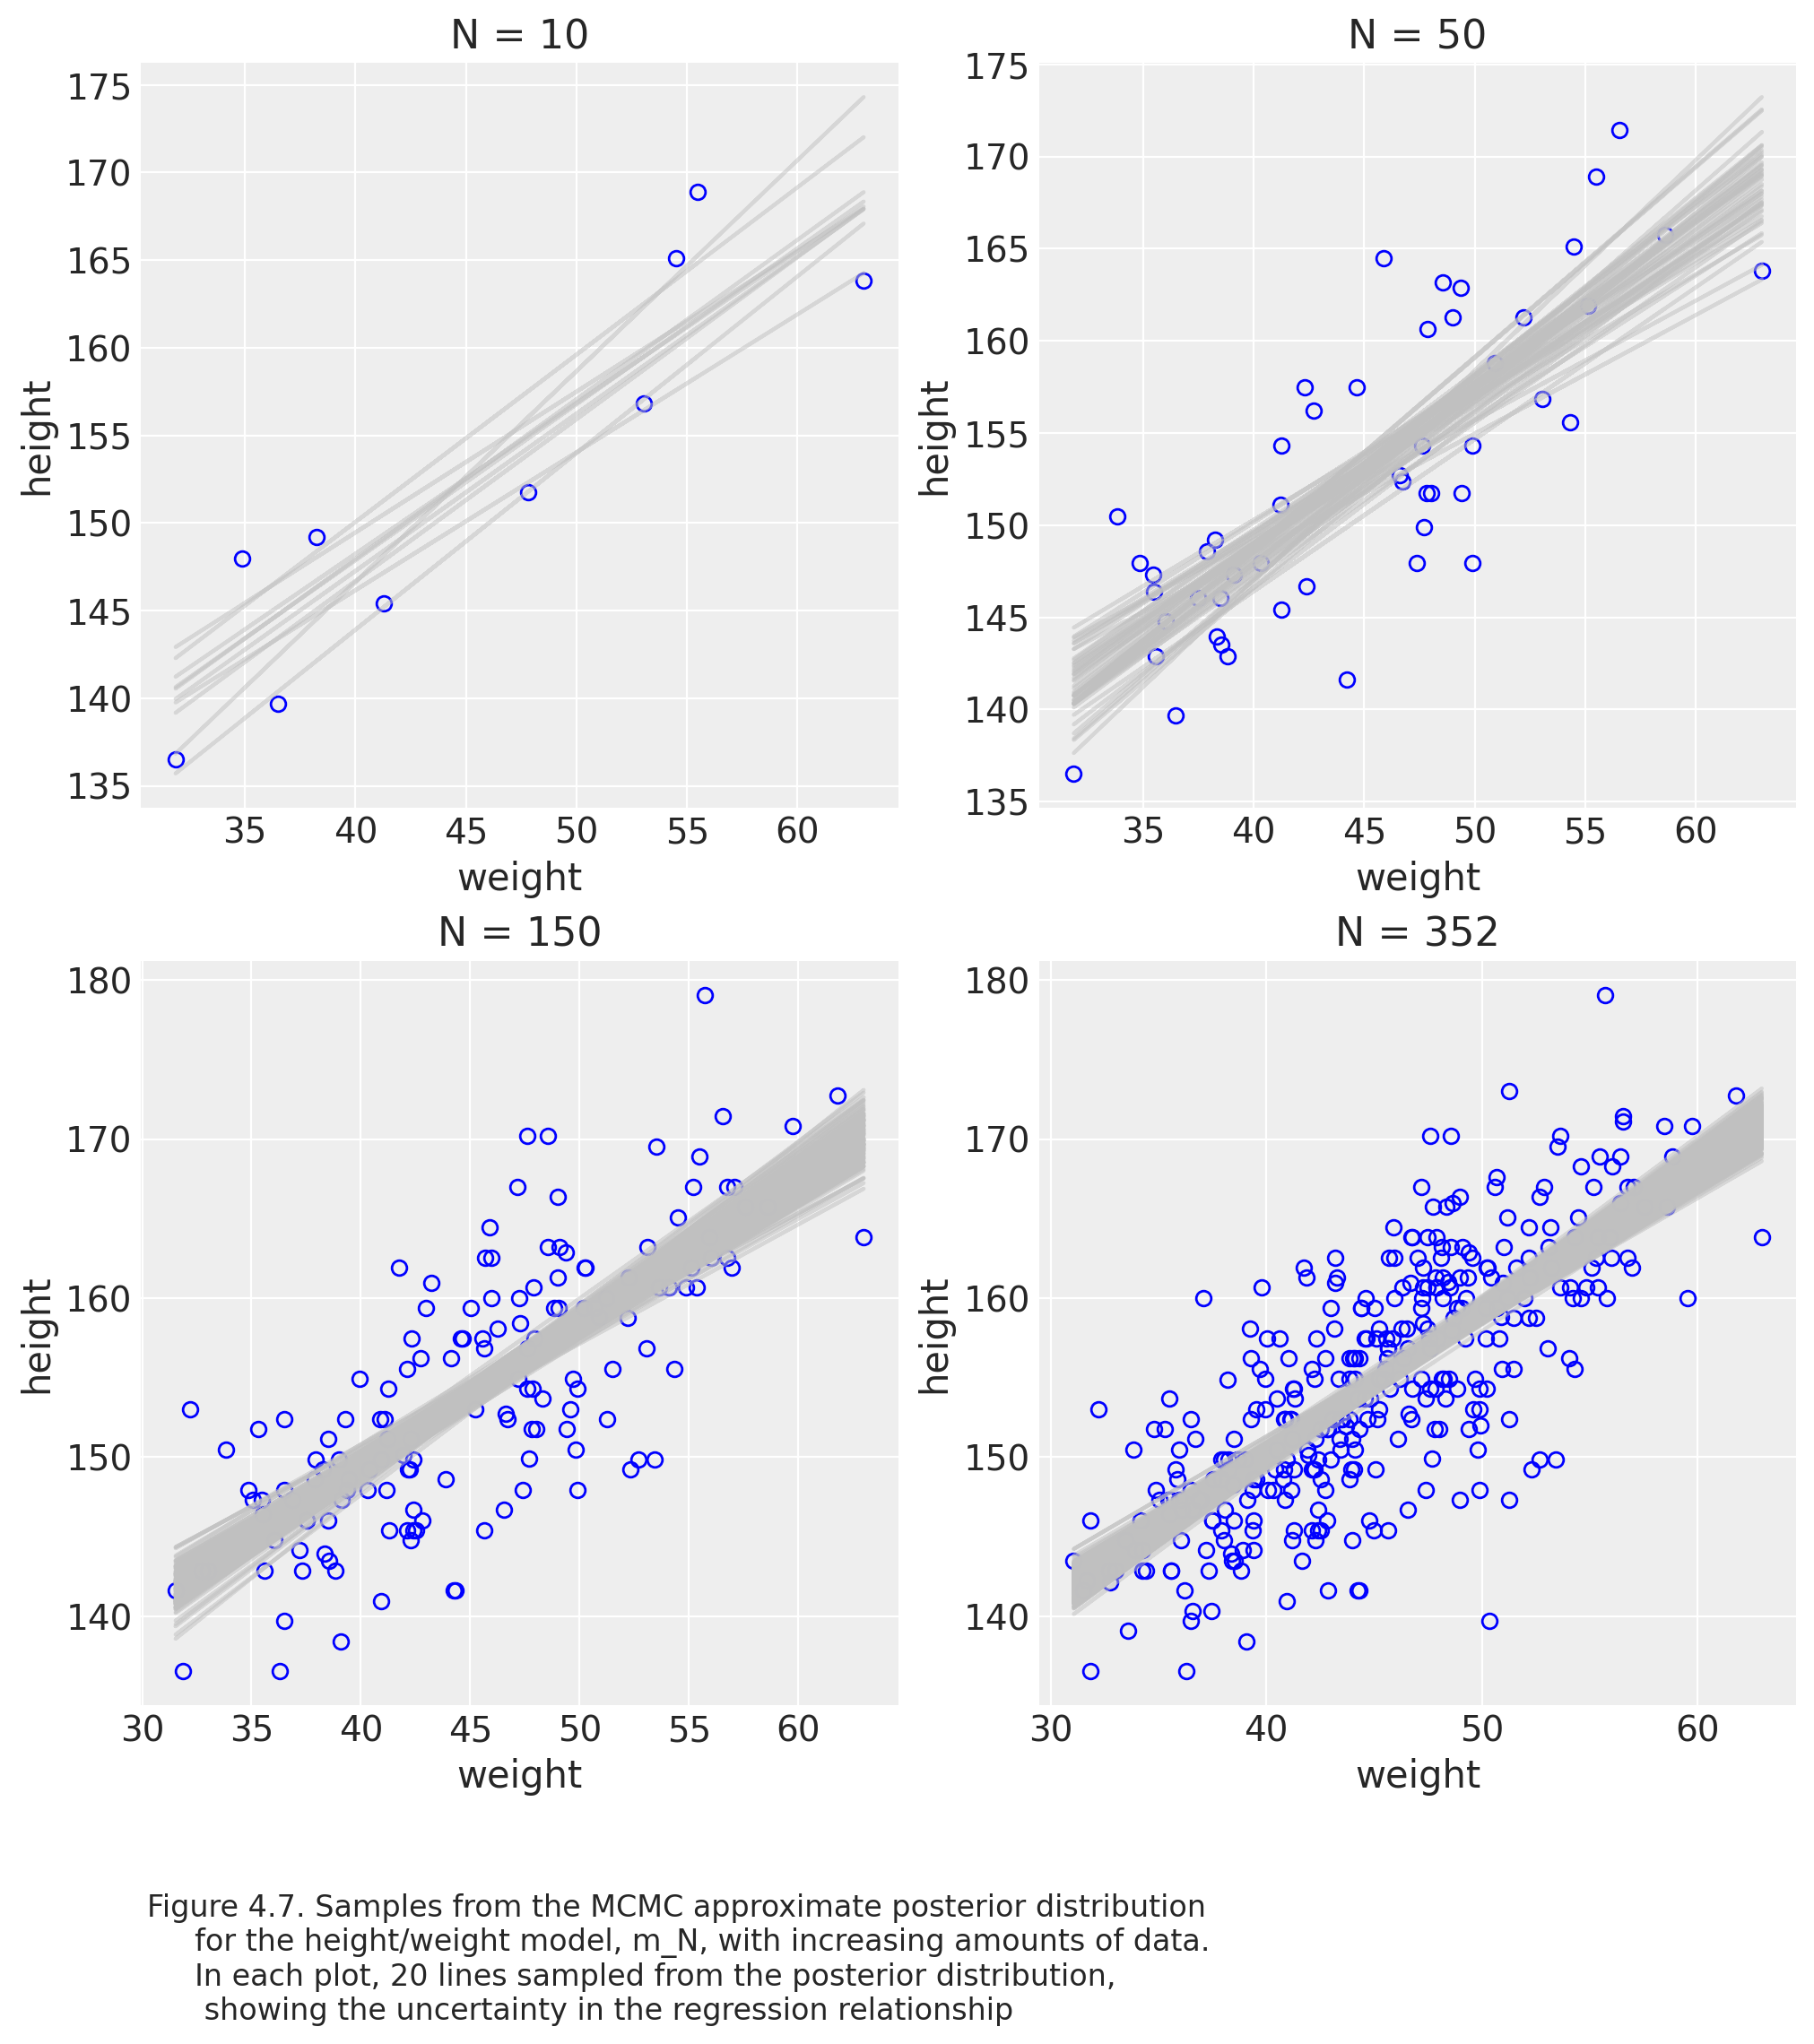

In [26]:
fig, ax = plt.subplots(2, 2, figsize=(10, 10))
cords = [(0, 0), (0, 1), (1, 0), (1, 1)]
for i in range(len(data)):
    idxs = height_rng.integers(nb_samples, size=N[i])
    ax[cords[i]].plot(
        data[i].weight,
        data[i].height,
        "C0o",
        marker="o",
        color="none",
        markeredgecolor="blue")
    ax[cords[i]].set_title(f"N = {len(data[i])}")
    ax[cords[i]].set_xlabel(d2.columns[1])
    ax[cords[i]].set_ylabel(d2.columns[0])

    for idx in idxs:
        ax[cords[i]].plot(
            data[i].weight,
            az.extract_dataset(traces[i])["mu"][:, idx],
            "C1-",
            alpha=0.5,
            color="silver"
        )

plt.suptitle(
    x=0.375,
    y=-0.05,
    t="Figure 4.7. Samples from the MCMC approximate posterior distribution \n \
    for the height/weight model, m_N, with increasing amounts of data. \n \
    In each plot, 20 lines sampled from the posterior distribution, \n \
     showing the uncertainty in the regression relationship",
    ma="left"
  )

By plotting multiple regression lines sampled from the posterior, we can see the highly confident aspects of the relationship between the 2 variables and the less confident aspects. We'll find that the cloud of regression lines display greater uncertainty at the extreme end values for weight. In plain English, there's more uncertainty when predicting height for people that weigh closer to 30 kg or 60 kg, both representing our extreme values.

What's also interesting about our model is that the cloud of regression lines grows more compact as we increase our sample size, meaning that our model is more confident about finding the location of the mean.


#### 4.4.3.4. *Plotting regression intervals and contours*

What we have in **Figure 4.7** is an appealing display of the uncertainty in the linear relationship between our two variables. However, it's much more common, and often more clearer, to display this uncertainty in an interval or a contour around the average regression line.

#### Code 4.50

To illustrate this concept, let's compute an arbitrary interval of height predictions surrounding a single weight value, say a single `weight` value of 50 kilograms. From our chosen weight value, we can sample a list of 2,000 values from our distribution of intercept $\alpha$ and slope $\beta$ values that would result from the posterior and then generate a list of predicted mean height values from our Linear Model:

$ \mu_i = \alpha + \beta(x_i - \bar{x}) $

$Where:$
- $x_i = 50$

Note that the maximum amount of samples we can draw is 2,000 values since we restricted our sample and tuning sample arguments to 1,000 each from our `pm.sample()` function earlier. Since the joint $\alpha$ and $\beta$ went into computing each predicted mean, their variation in the values incorporates the uncertainty and correlation between both parameters.

In [27]:
arbitraty_val = 50
data_4_3 = az.extract_dataset(trace_4_3, num_samples=10000)
mu_at_50 = data_4_3["a"] + data_4_3["b"] * (arbitraty_val - d2.weight.mean())

<ipython-input-27-5705ced12707>:2: FutureWarning: extract_dataset has been deprecated, please use extract
  data_4_3 = az.extract_dataset(trace_4_3, num_samples=10000)


#### Code 4.51

Now, let's go ahead and plot the density for our sampled vector of mean height values:

Text(0.5, -0.05, 'Figure 4.8. The MCMC approximate posterior distribution \n     of the mean heights, $\\mu$, when our weight is 50 kg. \n     This distribution represents the relative plausibility \n     of different values of the mean.')

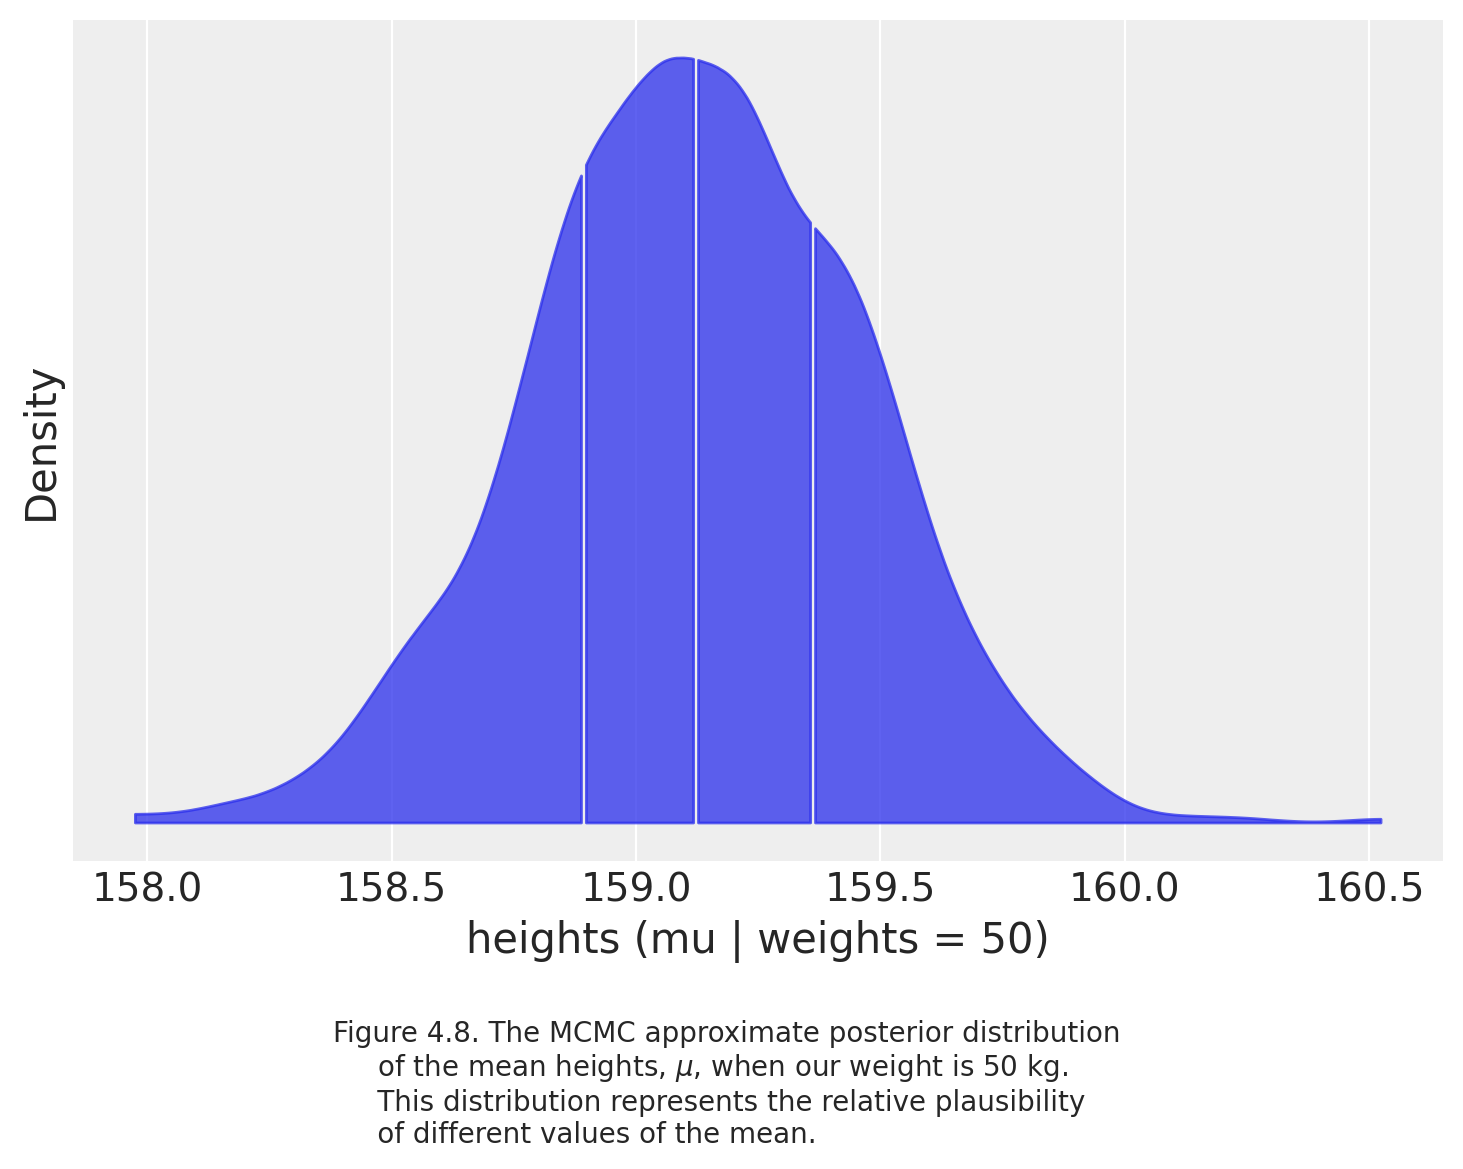

In [28]:
az.plot_kde(mu_at_50.values, quantiles=[.25, .5, .75])
plt.xlabel("heights (mu | weights = 50)")
plt.ylabel("Density")
plt.yticks([])
plt.suptitle(
    x=0.5,
    y=-0.05,
    t="Figure 4.8. The MCMC approximate posterior distribution \n \
    of the mean heights, $\mu$, when our weight is 50 kg. \n \
    This distribution represents the relative plausibility \n \
    of different values of the mean.",
    ma="left",
    fontsize="medium"
  )

Remember, this density plot only represents the uncertainty in the model's ability to predict height at a single weight value of 50. What this means is that each value of weight comes with its own Gaussian distribution of uncertainty.

#### Code 4.52

And if we generate 89% compatibility interval of the generated average heights $\mu$ at 50 kg, we'll find that 89% of the plausible predicted height fall between 158.58 and 159.62 cm.

In [29]:
az.hdi(mu_at_50.values, hdi_prod=0.89)

array([158.6027613, 159.6769816])

#### Overthinking: How `link` works.
#### Code 4.58

In the textbook, the function `link()` is used in **R** to compute the value of our Linear Model over each sample in our MCMC-approximated posterior distribution. In Code 4.58, we'll try to recreate the `link()` function from Prof McElreath's `rethinking` [package](https://github.com/rmcelreath/rethinking). And in Code 4.53 and 4.54, we'll test our custom-built `link()` function on our model `trace_4_3` in Code 4.42.

In 4.53, if we set our `hdi` parameter to `True`, we'll get the results of our model's distribution of predicted mean heights, as well as the compatibility interval, for a given `weight` value that we've inputted in the `w` variable in line 6 of our `mu_pred_link[i]` Linear Model equation.

In [30]:
def link(pymc_trace, val_range=list, x_col=None, y_col=None, dataset=None, hdi=False, hdi_ci=0.89, prior_1=str, prior_2=str):
  trace_N = az.extract_dataset(pymc_trace)
  n_samples = trace_N.sizes["sample"]
  mu_pred_link = np.zeros((len(val_range), n_samples))

  for i, w in enumerate(val_range):
    mu_pred_link[i] = trace_N[prior_1] + trace_N[prior_2] * (w - x_col.mean())

  if hdi is True:
    hdi_array = []
    for each_row in mu_pred_link:
      ci = az.hdi(each_row, hdi_prod=hdi_ci)
      hdi_array.append(ci)

    while True:
      print(f"Input a row number between 0 and {mu_pred_link.shape[0] - 1} to display its compatibility interval: ")
      number = int(input())
      try:
        row_n = int(number)
        if row_n < mu_pred_link.shape[0]:
          print("\n")
          print(f"The distribution of values calculated for the input variable ({val_range[row_n]:.2f}) on row {row_n} are the following: \n {mu_pred_link[row_n]} \n")
          print(f"{(hdi_ci * 100):.0f}% of the plausible values in the distribution calculated from the input {val_range[row_n]:.2f} fall between {hdi_array[row_n][0]:.2f} and {hdi_array[row_n][1]:.2f}. \n")
          return mu_pred_link
          break
        else:
          print(f"The value is larger than the size of the dataset used to train the model. \
          Please input a value that is less than {mu_pred_link.shape[0]}.")
      except ValueError:
        print("Invalid input. Please enter a valid integer.")

  else:
    return mu_pred_link

#### Code 4.53



So, in short, `link()` takes an MCMC-approximated posterior distribution as well as a range of input values which represent plausible values from one of our predictor variables, in this case - `weight`, samples from the posterior, and computes a predicted distribution of average heights $\mu$ for the given input values.

The returning object from the function should yield an `ndarray` that could easily fit within a standard DataFrame, with each row representing a distribution of plausible average heights for each given input/`weight` value.

In [31]:
# Testing results of hdi = True
equal_spacing = np.linspace(d2["weight"].min(), d2["weight"].max(), num=352)
mu_link = link(
    pymc_trace=trace_4_3,
    x_col=d2["weight"],
    val_range=equal_spacing,
    hdi=True,
    prior_1="a",
    prior_2="b"
  )
print(mu_link.shape, '\n')

<ipython-input-30-d1b92278d474>:2: FutureWarning: extract_dataset has been deprecated, please use extract
  trace_N = az.extract_dataset(pymc_trace)


Input a row number between 0 and 351 to display its compatibility interval: 
1


The distribution of values calculated for the input variable (31.16) on row 1 are the following: 
 [141.25619515 142.7468462  142.62204872 ... 142.26808457 141.40414813
 142.25480262] 

89% of the plausible values in the distribution calculated from the input 31.16 fall between 141.08 and 143.05. 

(352, 2000) 



In [32]:
# Testing results of hdi = False
mu_link_noHDI = link(trace_4_3, x_col=d2["weight"], val_range=equal_spacing, hdi=False, prior_1="a", prior_2="b")
print(mu_link_noHDI.shape, '\n')
print(mu_link_noHDI[111], '\n')

<ipython-input-30-d1b92278d474>:2: FutureWarning: extract_dataset has been deprecated, please use extract
  trace_N = az.extract_dataset(pymc_trace)


(352, 2000) 

[151.0773795  151.06699113 151.23270595 ... 151.30647988 150.84031299
 151.35143179] 



#### Code 4.54

Now in Code 4.54, we're going to examine the distribution of mean height values for a range of theoretical height values between 25 to 71 kg.

In [33]:
az.summary(trace_4_3, hdi_prob=0.89, round_to=2)

mean    sd  hdi_5.5%  hdi_94.5%  mcse_mean  mcse_sd  ess_bulk  \
a      154.59  0.26    154.16     155.01       0.01      0.0   2780.21   
b        0.90  0.04      0.84       0.97       0.00      0.0   3002.27   
sigma    5.10  0.19      4.78       5.39       0.00      0.0   2814.86   

       ess_tail  r_hat  
a       1543.02    1.0  
b       1407.66    1.0  
sigma   1628.59    1.0

In [34]:
weight_seq = np.arange(25, 71)
mu_pred = link(trace_4_3, x_col=d2["weight"], hdi=True, val_range=weight_seq, prior_1="a", prior_2="b")
print(mu_pred.shape, '\n')

<ipython-input-30-d1b92278d474>:2: FutureWarning: extract_dataset has been deprecated, please use extract
  trace_N = az.extract_dataset(pymc_trace)


Input a row number between 0 and 45 to display its compatibility interval: 
10


The distribution of values calculated for the input variable (35.00) on row 10 are the following: 
 [145.02409943 145.93887565 145.92553342 ... 145.73567128 145.02433941
 145.7447308 ] 

89% of the plausible values in the distribution calculated from the input 35.00 fall between 144.78 and 146.32. 

(46, 2000) 



#### Code 4.53 and 4.54

What we are doing _manually_ in the book is done using the `link` function. In the book on code 4.58 the following operations are performed _manually_.

The following code creates a 46-by-200 multidimensional array of predicted mean height values for inputted weight values between 25-70. Therefore each of the 46 rows in this array contains a list of 200 values representing the model's uncertainty at predicting height for each value of weight.

In [35]:
# # Returns a range of integers between 25-70 (inclusive)
# weight_seq = np.arange(25, 71)

# # Given that we have a lot of samples we can use less of them for plotting (or we can use all!)
# # Returns the integer 2,000 from the samples generated from the 10 data values in Code 4.48
# nb_samples = trace_N.sizes["sample"]

# # Systematically generates 200 samples from the extracted dataset of the trace we generated in Code 4.42
# trace_4_3_thinned = data_4_3.isel(sample=range(0, nb_samples, 10))

# # Returns an integer of 200
# nb_samples_thinned = trace_4_3_thinned.sizes["sample"]

# # Returns a 46x200 multi-dimensional array of zeroes
# mu_pred = np.zeros((len(weight_seq), nb_samples_thinned))

# for i, w in enumerate(weight_seq):
#     mu_pred[i] = trace_4_3_thinned["a"] + trace_4_3_thinned["b"] * (w - d2.weight.mean())

#### Code 4.55

And in Code 4.55, we will visualize the distribution of $\mu$ for each given height. From the scatterplot, we can see that the points for each weight value are a Gaussian distribution, similar to what we saw in **Figure 4.8**. In addition, the uncertainty within the distribution of $\mu$ values depends heavily on the `weight` value.

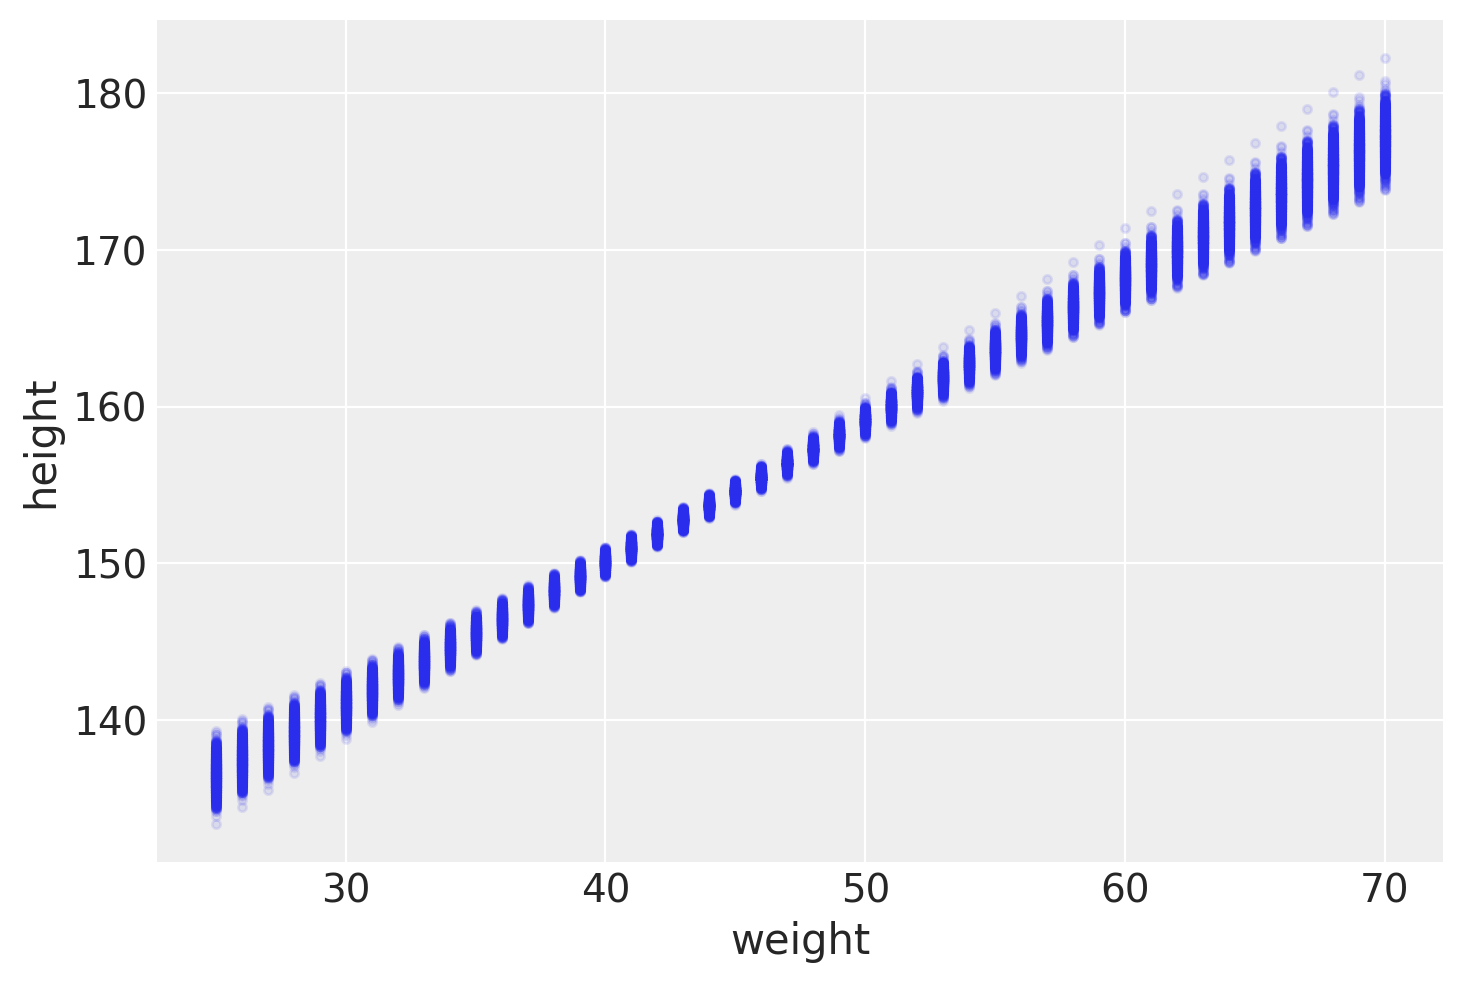

In [36]:
plt.plot(weight_seq, mu_pred, "C0.", alpha=0.1)
plt.xlabel("weight")
plt.ylabel("height");

#### Code 4.56

Next, we'll calculate the distribution of average means for each `weight` value which we'll use to plot as a black line plot in **Figure 4.9**. Since there were 46 input values in our `link()` function, we should expect 46 output values from our `mu_mean` object as a result of the average of each distribution. The same goes for 46 pairs of upper and lower bounds for 89% of each distribution stored in our `mu_hdi` object.

In [37]:
mu_mean = mu_pred.mean(axis=1)
mu_hdi = az.hdi(mu_pred.T)

<ipython-input-37-4f4f7b5b0cc4>:2: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  mu_hdi = az.hdi(mu_pred.T)


In [38]:
print(mu_mean.shape)
print(mu_hdi.shape)
mu_hdi[0]

(46,)
(46, 2)


array([135.23290415, 137.92087257])

#### Code 4.57

And if we look at the right-hand plot in Figure 4.9, we can see the result of all the work we did so far with our `m4_3` model in terms of plotting the original weight and height values from our `d2` dataset, the average of the distribution of predicted mean height values for every value of weight as indicated by the black regression line, and the faint orange scatterplot hugging the regression line which communicates the uncertainty around the predicted $\mu$ values.

#### Figure 4.9: Combining Code 4.55 & 4.57

/usr/local/lib/python3.10/dist-packages/arviz/plots/hdiplot.py:156: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  hdi_data = hdi(y, hdi_prob=hdi_prob, circular=circular, multimodal=False, **hdi_kwargs)


Text(0.375, -0.05, 'Figure 4.9. Left: The distribution of average height for weight values \n     between 25-71 kg. Right: The !Kung San height data again, now with a \n     89% compatibility interval of the mean indicated by the shaded region. \n     Compare this region to the distribution of blue points on the left.')

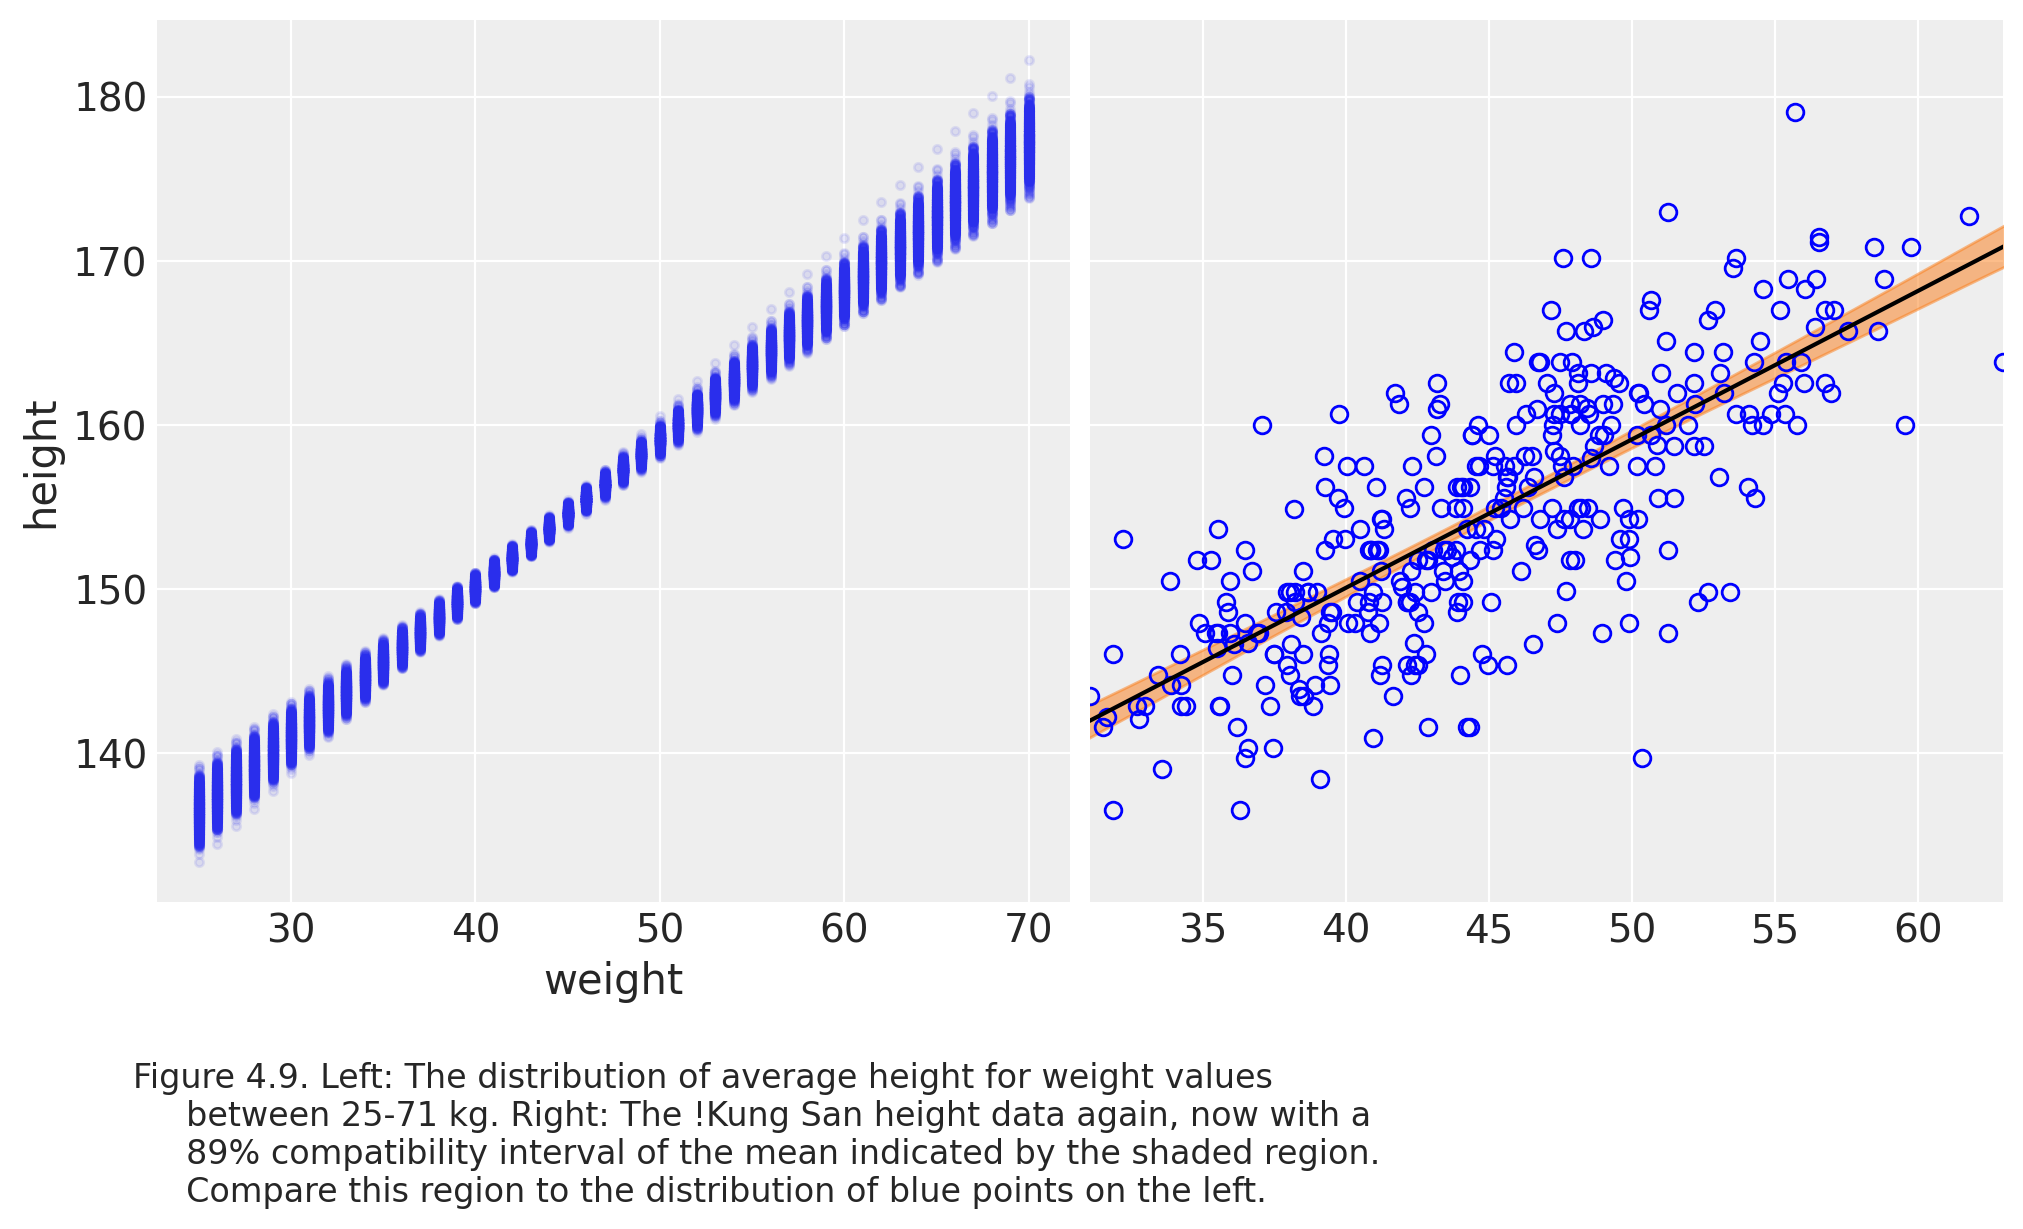

In [39]:
_, ax = plt.subplots(1, 2, sharey=True, figsize=(10, 5))
ax[0].plot(weight_seq, mu_pred, "C0.", alpha=0.1)
ax[0].set_xlabel("weight")
ax[0].set_ylabel("height")

az.plot_hdi(weight_seq, mu_pred.T, ax=ax[1])
ax[1].plot(d2.weight, d2.height, marker="o", color="none", markeredgecolor="blue")
ax[1].plot(weight_seq, mu_mean, "k")
ax[1].set_xlim(d2.weight.min(), d2.weight.max())

plt.suptitle(
    x=0.375,
    y=-0.05,
    t="Figure 4.9. Left: The distribution of average height for weight values \n \
    between 25-71 kg. Right: The !Kung San height data again, now with a \n \
    89% compatibility interval of the mean indicated by the shaded region. \n \
    Compare this region to the distribution of blue points on the left.",
    ma="left"
  )

#### 4.4.3.5 Prediction Intervals.

Now that we've generated 89% prediction intervals for *average* heights, let's now shift our focus to generating prediction intervals for <u><i>actual</i></u> heights. This means we'll also incorporate the standard deviation $\sigma$ and its uncertainty. Let's review the first line of our statistical model:

$h_i \sim \text{Normal}(\mu_i , \sigma)$

So far, all we've done is sample the posterior to visualize the uncertainty with each individual average height $\mu_i$ generated through our linear model. However, the actual predictions themselves will also depend on the kind of distribution we specify on the first line, which states that our observed heights *should* be distributed around the mean $\mu$ with the standard deviation $\sigma$ governing the spread of the distribution. Therefore, we must also incorporate the distribution of standard deviations $\sigma$ when generating our prediction intervals for actual heights.

To do so, we need to simulate a prediction of heights for each unique weight value that we sample from our Gaussian distribution. This sample will be centred around an average height $\mu$ and a standard deviation $\sigma$, which, in turn, have been sampled from a posterior distribution.

#### Code 4.59

Now we are going to use `sample_posterior_predictive()` from PyMC. This function gives us a posterior predictive sample; that is, for each value of the input variable, we get a sample (from the posterior) of the output variable. Thus in the following example, the shape of `height_pred['height'].shape is (200, 352)`.

In [40]:
samp_size = 100
slice_rate = int(len(trace_4_3["posterior"]["draw"]) / samp_size)

# Samples every 10 values from the original 1000 posterior samples
# so that we have a sample with only 100 values.
thin_data = trace_4_3.sel(draw=slice(None, None, slice_rate))

with m4_3:
    height_pred = pm.sample_posterior_predictive(thin_data)

In [41]:
height_pred["posterior_predictive"]['height'].shape

(2, 100, 352)

`height_pred["posterior_predictive"]['height']` produces two multidimensional  arrays with predicted height values (rather than a distribution of plausible average height values) that are 100 by 352 each within one so that  the shape is (2, 100, 352)

#### Code 4.60

We can also genearte an 89% posterior prediction interval of predicted heights for each input weight value using the `az.hdi()` function

In [42]:
height_pred_hdi = az.hdi(height_pred["posterior_predictive"]["height"], hdi_prob=0.89)
height_pred_hdi["height"][0]

<xarray.DataArray 'height' (hdi: 2)>
array([149.87012727, 165.71085313])
Coordinates:
    height_dim_2  int64 0
  * hdi           (hdi) <U6 'lower' 'higher'

#### Code 4.61 / Figure 4.10

Now, let's bring everything we've just done together in a graph that plots:
1. Our original height and weight values from the `d2` dataset, indicated by the blue scatterplot.
2. Our mean regression line which captures the average from each distribution of plausible mean values for every weight value, indicated by the black line.
3. The thinner, shaded orange region hugging the regression line which captures the boundaries of 89% of our posterior distribution for mean heights $\mu$.
4. And lastly, the more-expansive grey boundaries which capture the simulated heights that our model expects from 89% of the actual heights in the population at each weight value.

As a reminder, there's nothing special about 89% here. We can just as easily plot the boundaries for 67% or 97% (both prime numbers) of the population by changing our `hdi_prob` parameter from the `az.hdi()` function.

/usr/local/lib/python3.10/dist-packages/arviz/plots/hdiplot.py:156: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  hdi_data = hdi(y, hdi_prob=hdi_prob, circular=circular, multimodal=False, **hdi_kwargs)


Text(1.55, 0.75, 'Figure 4.10. 89% prediction interval for \n     height, as a function of weight. The solid line \n     is the average line for the mean height at each \n     weight. The two shaded regions show different \n     plausible regions. The narrow shaded interval \n     around the line is the distribution of $\\mu$. \n     The wider shaded region represents the region \n     within which the model expects to find 89%  \n     of actual heights in the population, at each \n     weight.')

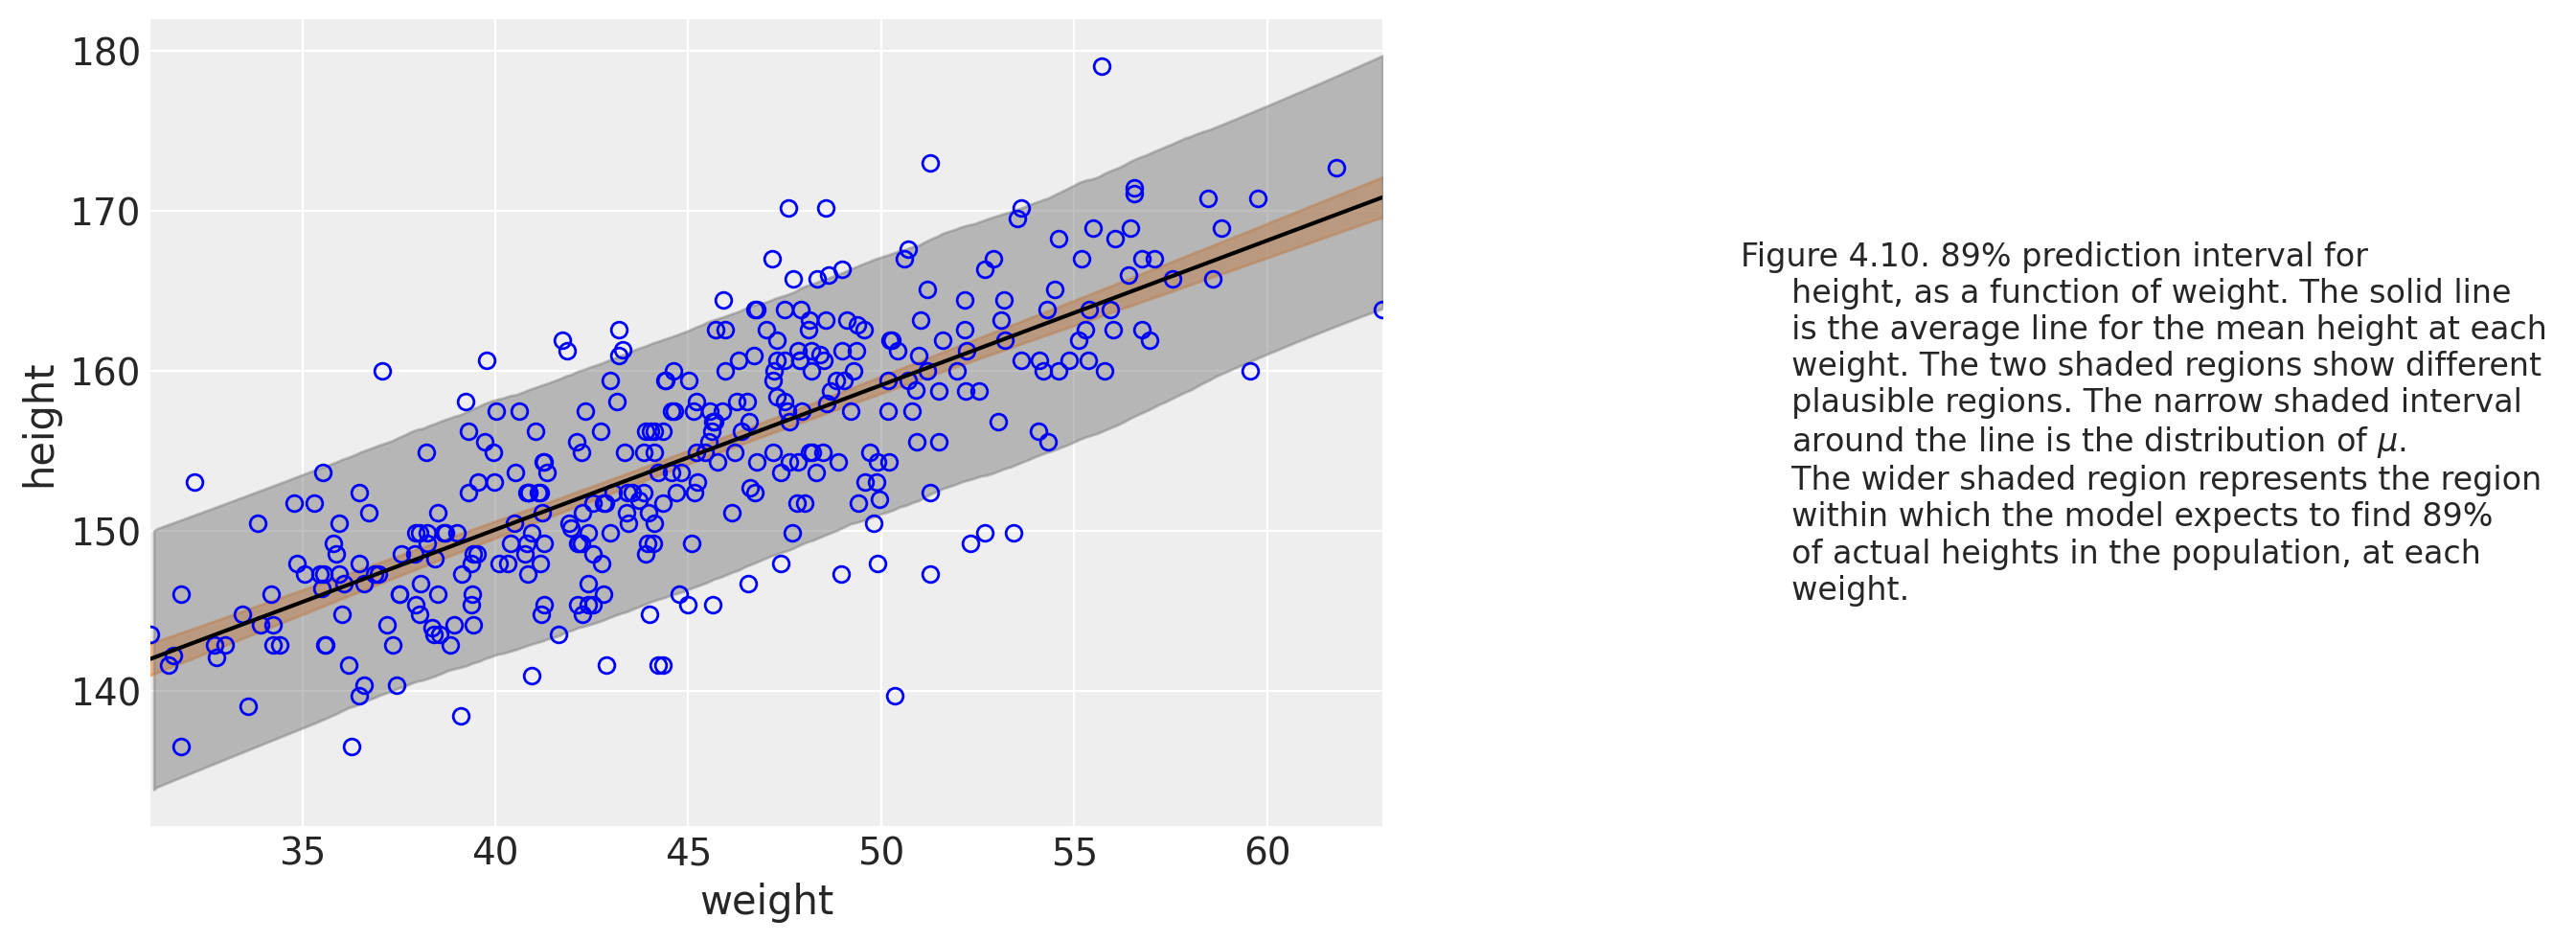

In [43]:
ax = az.plot_hdi(weight_seq, mu_pred.T, hdi_prob=0.89) #3
az.plot_hdi(d2.weight, height_pred["posterior_predictive"]["height"], ax=ax, hdi_prob=0.89, color="grey") #4
plt.plot(d2.weight, d2.height, marker="o", color="none", markeredgecolor="blue") # 1
plt.plot(weight_seq, mu_mean, "k") #2
plt.xlabel("weight")
plt.ylabel("height")
plt.xlim(d2.weight.min(), d2.weight.max())
plt.suptitle(
    x=1.55,
    y=0.75,
    t="Figure 4.10. 89% prediction interval for \n \
    height, as a function of weight. The solid line \n \
    is the average line for the mean height at each \n \
    weight. The two shaded regions show different \n \
    plausible regions. The narrow shaded interval \n \
    around the line is the distribution of $\mu$. \n \
    The wider shaded region represents the region \n \
    within which the model expects to find 89%  \n \
    of actual heights in the population, at each \n \
    weight.",
    ma="left"
  )

#### Code 4.62

And if we wanted to smoothen the shaded grey interval, as it was a little rough in **Figure 4.10**, we only need to increase the number of samples from the posterior distribution. In the code below, we'll use all the samples from `trace_4_3` that we generated from the posterior distribution rather than the slice of 100 values from `thin_data` that we did earlier:

(2, 1000, 352)


/usr/local/lib/python3.10/dist-packages/arviz/plots/hdiplot.py:156: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  hdi_data = hdi(y, hdi_prob=hdi_prob, circular=circular, multimodal=False, **hdi_kwargs)


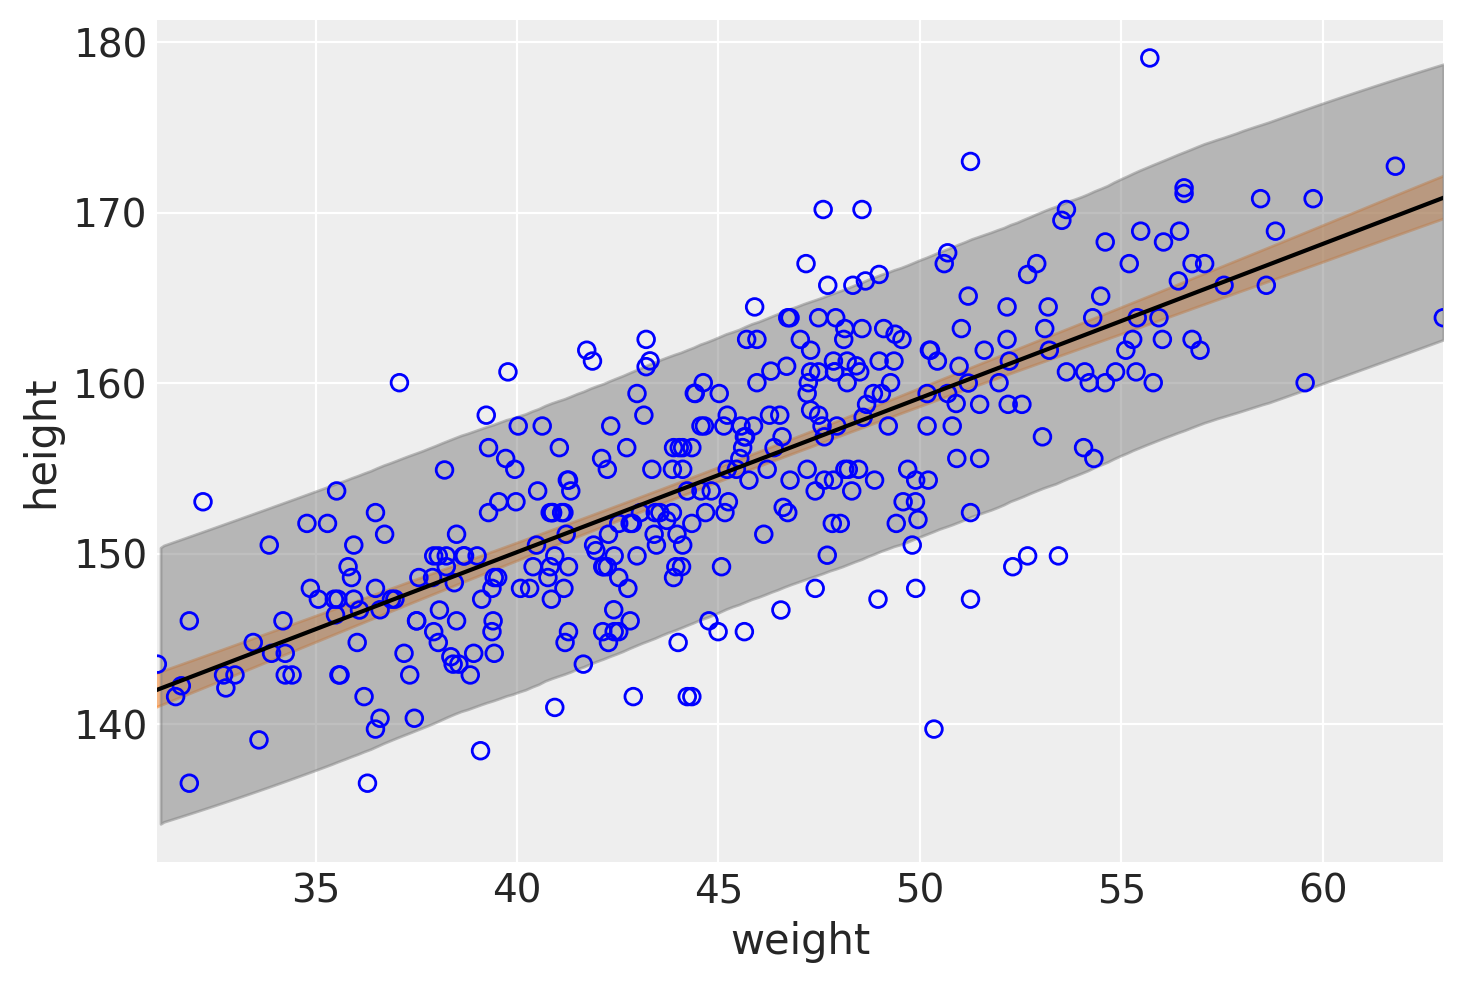

In [44]:
# samp_size = 1000
# slice_rate = int(len(trace_4_3["posterior"]["draw"]) / samp_size)
# thin_data = trace_4_3.sel(draw=slice(None, None, slice_rate))
with m4_3:
    height_pred_full = pm.sample_posterior_predictive(trace_4_3)

print(height_pred_full["posterior_predictive"]["height"].shape)
ax = az.plot_hdi(weight_seq, mu_pred.T)
az.plot_hdi(d2.weight, height_pred_full.posterior_predictive["height"], ax=ax, hdi_prob=0.89, color="grey")
plt.scatter(d2.weight, d2.height, marker="o", color="none", edgecolors="blue")
plt.plot(weight_seq, mu_mean, "k")
plt.xlabel("weight")
plt.ylabel("height")
plt.xlim(d2.weight.min(), d2.weight.max());

#### Rethinking: Two kinds of uncertainty.

In the previous section, we encountered uncertainty both within the parameter values as well as uncertainty in the sampling process. *These are distinct concepts even though they are both very similar, and even blend together, in the posterior predictive simulation.*

The **posterior distribution** is *a ranking of the relative plausibilities of every possible combination* of parameter values. On the other hand, the **distribution of simulated outcomes** samples, such as height, is instead a *distribution of Gaussian random variables* that were *processed through some sampling variation*.

The *sampling variation* we've used to generate our simulated outcomes is an assumption we've made about our model, so it isn't more (or less) objective than the posterior distribution itself. Although both kinds of uncertainty matter, it's important to remember the distinctions between them because they depend on different model assumptions.

#### Code 4.63

Now we will generate heights from the posterior *manually* rather than relying on PyMC's automated function, `pymc.sample_posterior()`. Instead of restricting ourselves to the input values, we will pass an array of equally spaced weights values called `weight_seg`.

In [45]:
#####################################################
## The manual way of generating a posterior sample ##
#####################################################

weight_seq = np.arange(25, 71)
post_samples = []
for _ in range(1000):  # number of samples from the posterior
    i = height_rng.integers(len(data_4_3)) # Generates a random integer which is to be the index
    mu_pr = data_4_3["a"][i].item(0) + data_4_3["b"][i].item(0) * (weight_seq - d2.weight.mean())
    sigma_pred = data_4_3["sigma"][i]
    post_samples.append(height_rng.normal(mu_pr, sigma_pred))

And if we want to create our own version of the `sim()` function in R, we can simply wrap these instructions in our own custom function and then store the results in our `post_samples` object by passing the necessary arguments:

In [46]:
# Creating our own `sim()` function:
def sim(dataset, x_col, val_range=list, n_samples=int, prior_1=str, prior_2=str, prior_3=str):
  post_samples = []
  for _ in range(n_samples):  # number of samples from the posterior
      rng = np.random.default_rng(123)
      i = rng.integers(len(dataset))
      mu_pr = dataset[prior_1][i].item(0) + dataset[prior_2][i].item(0) * (val_range - x_col.mean())
      sigma_pred = dataset[prior_3][i]
      post_samples.append(height_rng.normal(mu_pr, sigma_pred))

  return post_samples

In [47]:
# weight_seq = np.arange(25, 71)
post_samples = sim(
    dataset=data_4_3,
    x_col=d2["weight"],
    val_range=weight_seq,
    n_samples=3000,
    prior_1="a",
    prior_2="b",
    prior_3="sigma"
  )

/usr/local/lib/python3.10/dist-packages/arviz/plots/hdiplot.py:156: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  hdi_data = hdi(y, hdi_prob=hdi_prob, circular=circular, multimodal=False, **hdi_kwargs)
/usr/local/lib/python3.10/dist-packages/arviz/plots/hdiplot.py:156: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  hdi_data = hdi(y, hdi_prob=hdi_prob, circular=circular, multimodal=False, **hdi_kwargs)


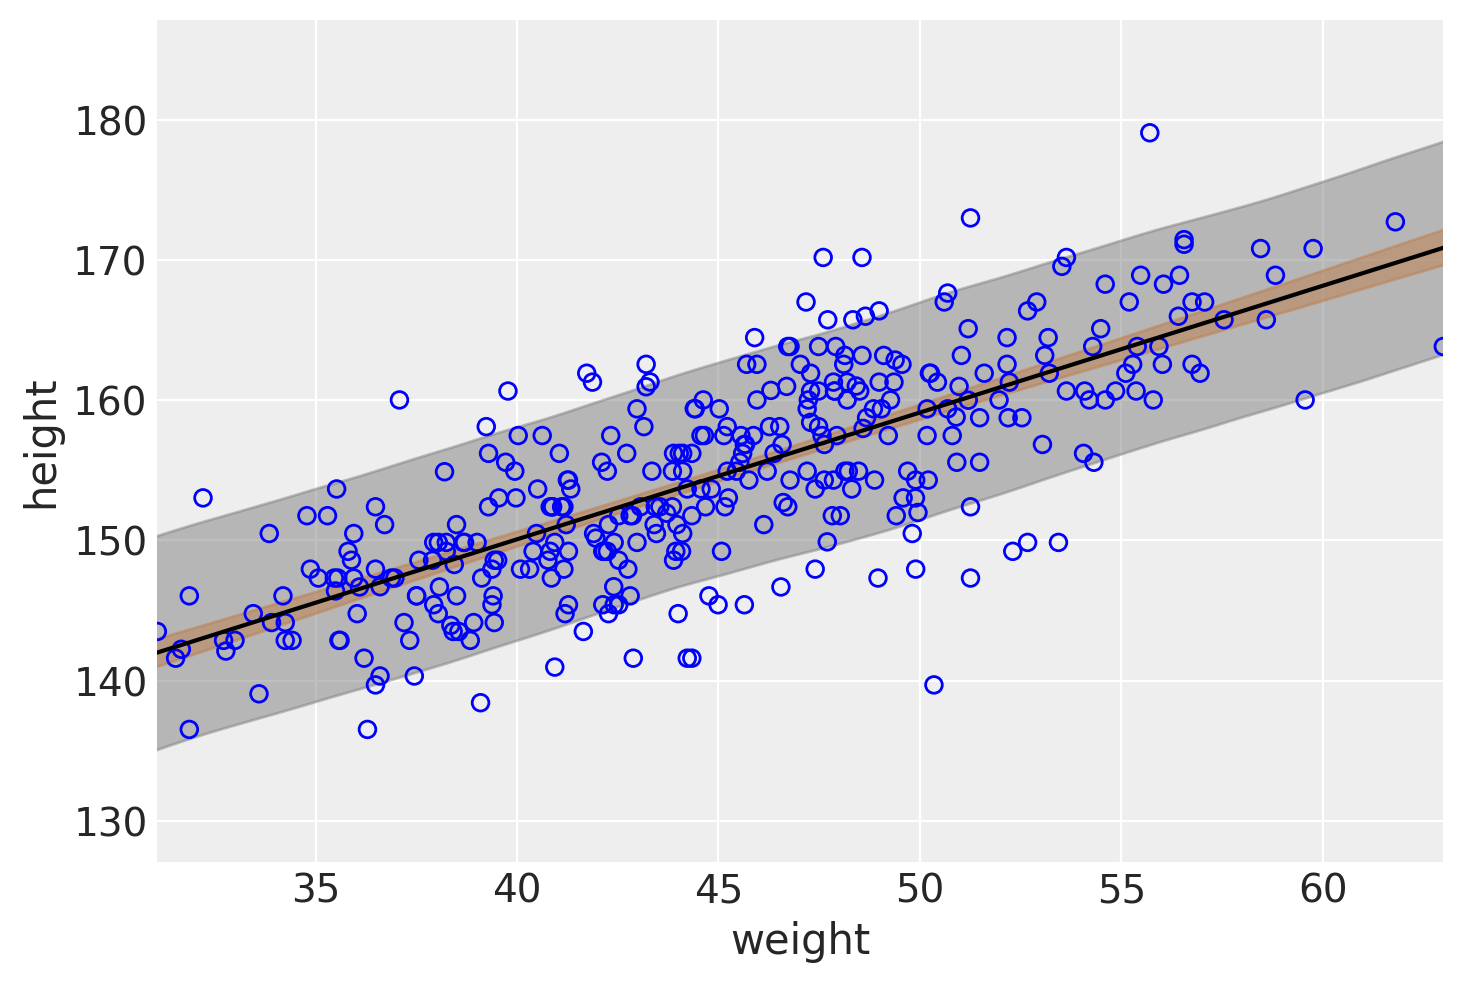

In [48]:
ax = az.plot_hdi(weight_seq, mu_pred.T, hdi_prob=0.89)
az.plot_hdi(weight_seq, np.array(post_samples), ax=ax, hdi_prob=0.89, color="grey")
plt.scatter(d2.weight, d2.height, marker="o", color="none", edgecolors="blue")
plt.plot(weight_seq, mu_mean, "k")
plt.xlabel("weight")
plt.ylabel("height")
plt.xlim(d2.weight.min(), d2.weight.max());

## *Section 4.5.* - Curves from lines.

With all the linear regression models we've built so far, each one assumed that a straight line perfectly described the relationship between the predictor and the target variable. That's cute. In this final section, we'll look at how to model outcomes that have a curved relationship with the predictors using two commonplace methods: **polynomial regression** and **b-splines**.

### 4.5.1. Polynomial Regression.

**Polynomial Regressions** are an easy way to build curved associations by using the power of varables - squares and cubes - as extra predictors. To understand how they work, let's bring back our original dataset which includes the heights of people 18 and younger.

#### Code 4.64

We have already loaded this dataset, check code 4.7 and 4.8.

In [49]:
d.head()

height     weight   age  male
0  151.765  47.825606  63.0     1
1  139.700  36.485807  63.0     0
2  136.525  31.864838  65.0     0
3  156.845  53.041914  41.0     1
4  145.415  41.276872  51.0     0

Text(0.5, 0, 'weight')

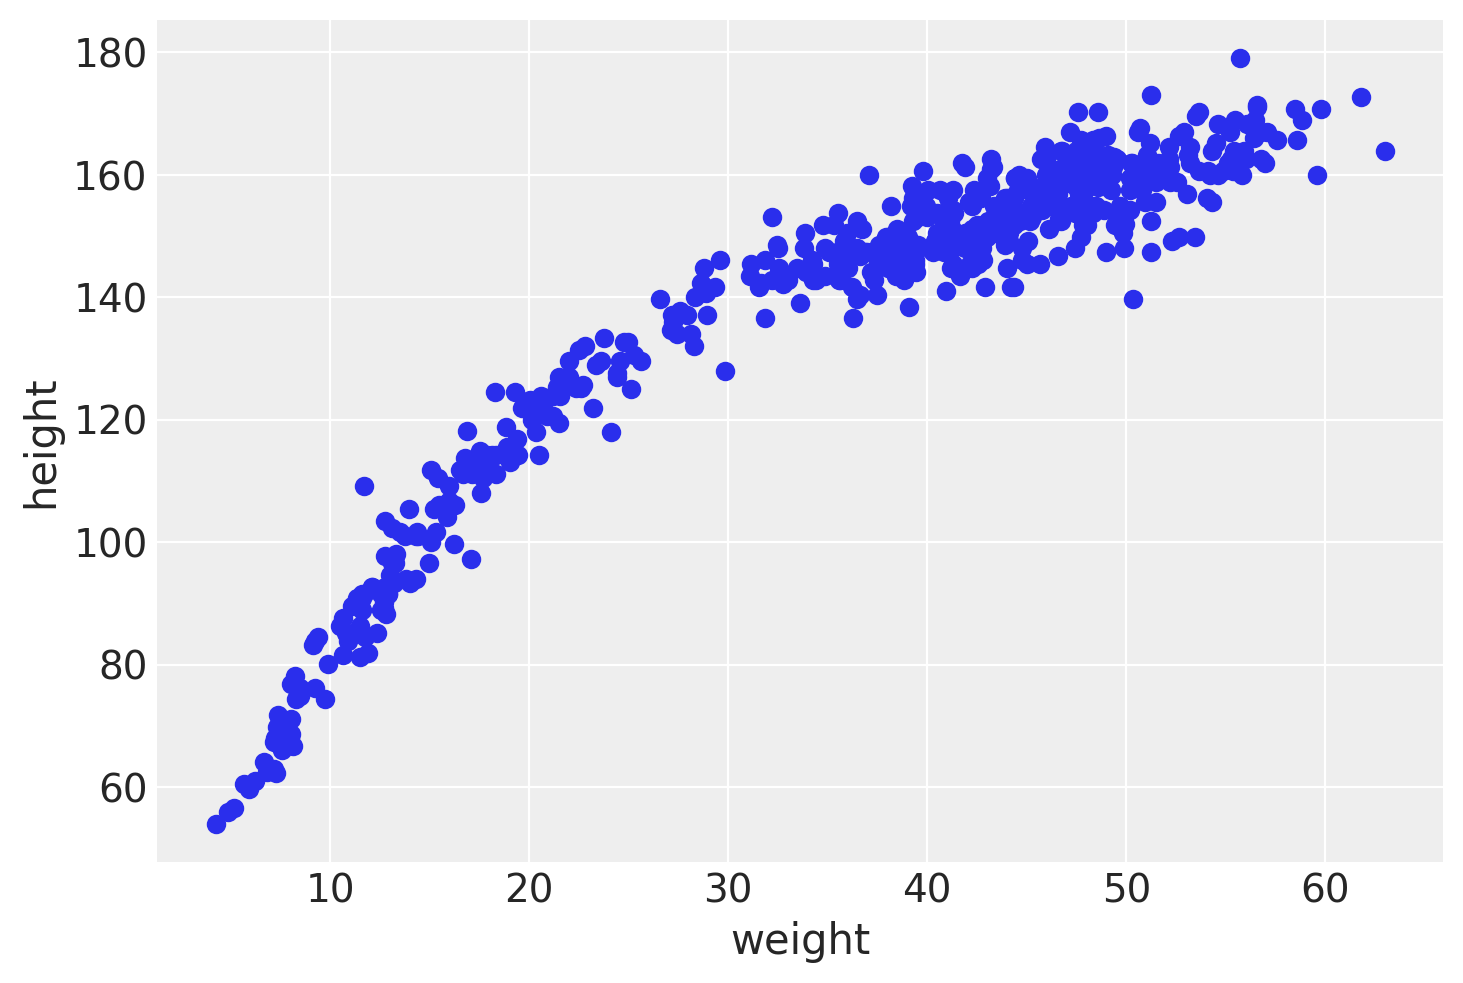

In [50]:
plt.scatter(d.weight, d.height)
plt.ylabel("height")
plt.xlabel("weight")

From our naked eye, we can already see a curved relation between height and weight when we consider the ENTIRE !Kung San population. The most common polynomial regression is that of a *parabolic model of the mean* where $w_i$ represents a specific weight value and $\mu_i$ represents the mean height for the distribution of associated height values to $x_i$:

$$ \mu_i = \alpha + \beta_1 w_i + \beta_2 w_i^2 $$

Note that our equation above is a **second-order parabolic polynomial**. If we break down our parabolic polynomial, the $\alpha + \beta_1 w_i$ part is the same linear regression of $w$ that we saw earlier, with the only difference being that we've added a "$1$" subscript to our $\beta$ parameter so that we can tell it apart from the new $\beta_2$ parameter. The additional expression (...$ + \beta_2 w_i^2 $) attempts to construct a parabola out of our given input variable $w_i$ (instead of allowing for a perfectly straight line) while $\beta_2$ is a new parameter that attempts to measure the curvature of the relationship.

Fitting parabolic polynomials to data is easy, but interpreting them can be tricky. The first thing we must do when fitting a parabolic model of height on weight is to standardize the predictor variable. We'll do this in two ways. The first method we can use is the all too familiar **Standard Scaler** that's often used in Machine Learning where $w_{new}$ can represent the standardized value:

$$ w_{new} = \frac{(w - \mu)}{\sigma} $$

**Standard Scaler** (also called **z-scores**) often works for most cases, but if we want to ensure that our standardized value is positive and works well for quadratic expressions, we can square our standardized value:

$$ w_{new} = \left( \frac{(w - \mu)}{\sigma} \right) ^2$$

Now to define the parabolic model, we simply need to modify the definition of $\mu_i$:

$h_i \sim \text{Normal}(\mu_i, \sigma) $ \[the likelihood \]

$ \mu_i = \alpha + \beta_1 w_i + \beta_2 w_i^2 $ \[the updated linear model / quadratic regression? \]

$ \alpha \sim \text{Normal}(178, 20) $ \[the $\alpha$ prior \]

$ \beta_1 \sim \text{Log-Normal}(0, 1) $ \[the old $\beta_1$ prior \]

$ \beta_2 \sim \text{Normal}(0, 1) $ \[the new $\beta_2$ prior \]

$ \sigma \sim \text{Uniform}(0, 50) $ \[the $\sigma$ prior \]

Notice how we've added a new $\beta_2$ prior to our Linear Model that is distributed normally, as opposed to our log-normal distribution that we saw in $\beta_1$. We've also made the small modification to our Linear model so that it represents a parabolic polynomial instead.


#### Code 4.65

In [51]:
d["weight_std"] = (d.weight - d.weight.mean()) / d.weight.std()
d["weight_std2"] = d.weight_std**2

with pm.Model() as m_4_5:
    a = pm.Normal("a", mu=178, sigma=100)
    b1 = pm.Lognormal("b1", mu=0, sigma=1)
    b2 = pm.Normal("b2", mu=0, sigma=1)
    sigma = pm.Uniform("sigma", lower=0, upper=50)
    mu = pm.Deterministic("mu", a + b1 * d["weight_std"] + b2 * d["weight_std2"])
    height = pm.Normal("height", mu=mu, sigma=sigma, observed=d.height.values)
    trace_4_5 = pm.sample(1000, tune=1000)

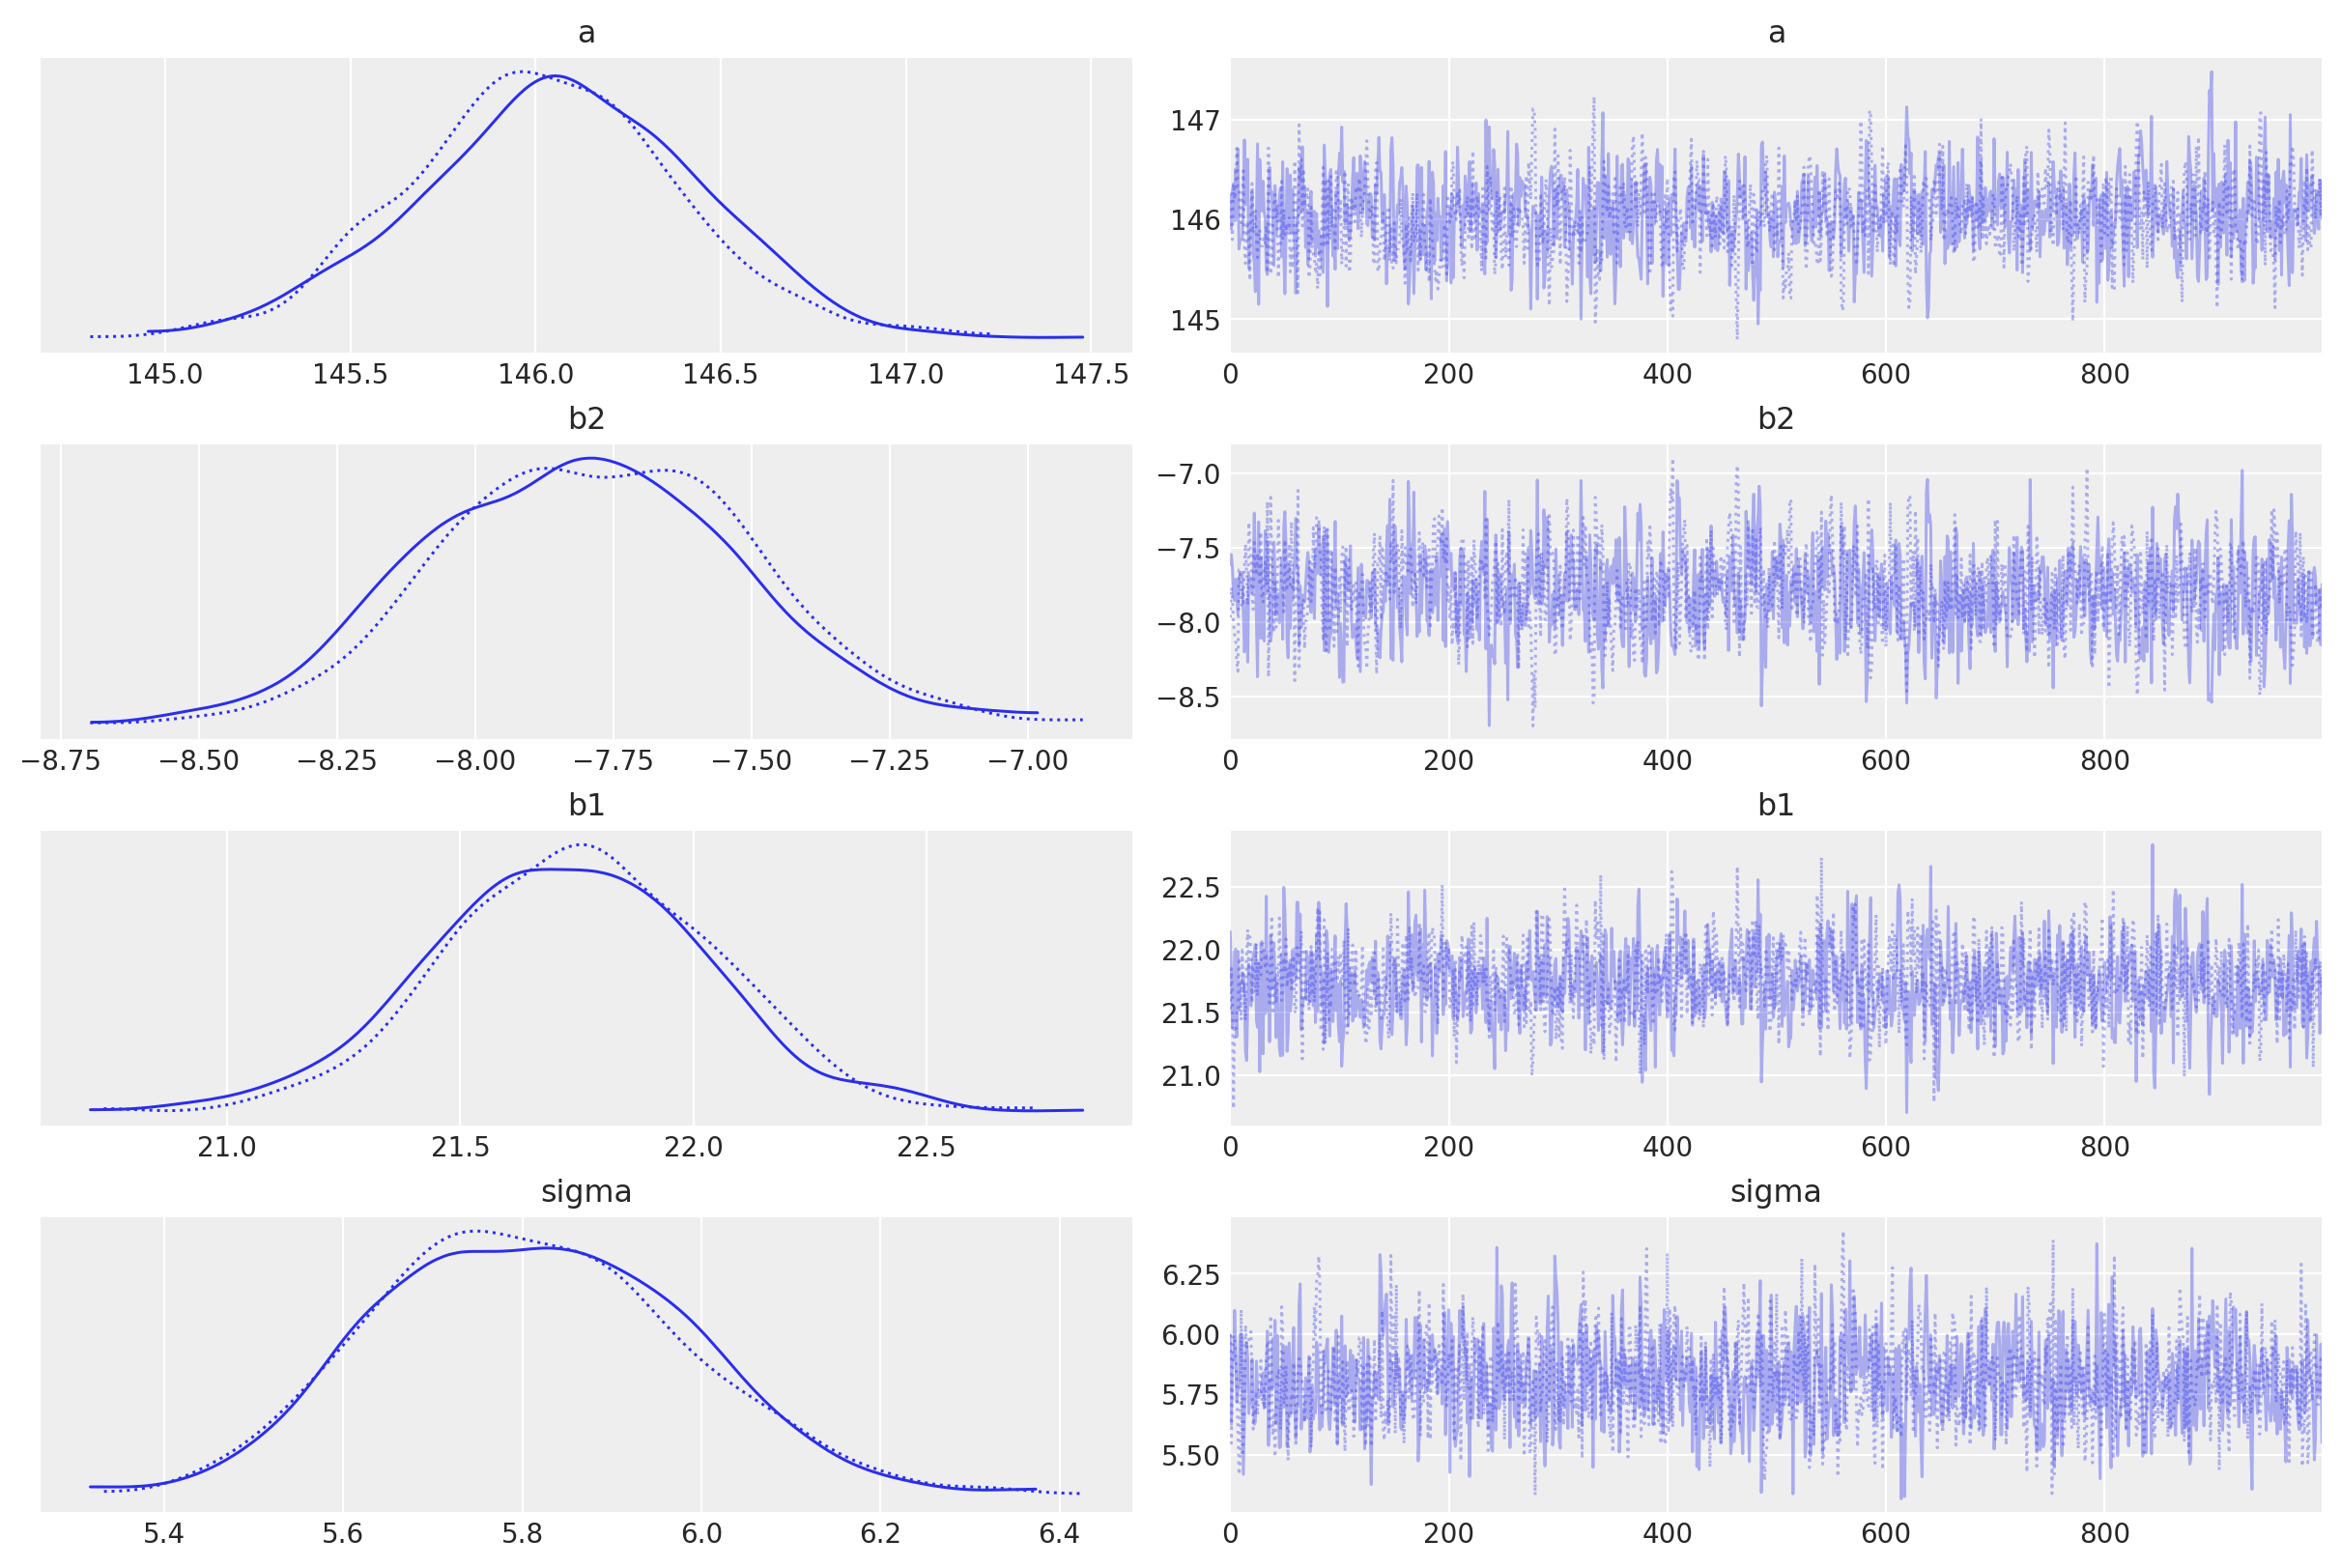

In [52]:
varnames = ["~mu"]
az.plot_trace(trace_4_5, varnames);

#### Code 4.66

Now that the relationship between `height` and `slope` is dependent on two slopes now, $\beta_1$ and $\beta_2$, it's now a little more harder to extract meaning from the table of coefficients.

In [53]:
az.summary(trace_4_5, varnames, kind="stats", round_to=2)

mean    sd  hdi_5.5%  hdi_94.5%
a      146.04  0.37    145.41     146.59
b2      -7.80  0.28     -8.22      -7.35
b1      21.74  0.29     21.30      22.21
sigma    5.81  0.18      5.52       6.08

#### Code 4.67

To tackle the low-hanging fruit, $\alpha$ is still considered the intercept, which tells us the expected value when the `weight` value is equal to its mean value ($w = \bar{w}$). However, with a polynomial regression, there's no guarantee that this still applies since there are now two predictor variables that we have to contend with. So to understand what's going on with these models, let's plot their mean relationship, the 89% interval of the mean, and their predictions.

In [54]:
trace_4_5

Inference data with groups:
	> posterior
	> sample_stats
	> observed_data

In [55]:
mu_pred = trace_4_5.posterior["mu"]
trace_4_5_thinned = trace_4_5.sel(draw=slice(None, None, 5))
with m_4_5:
    height_pred = pm.sample_posterior_predictive(trace_4_5_thinned)

#### Code 4.68

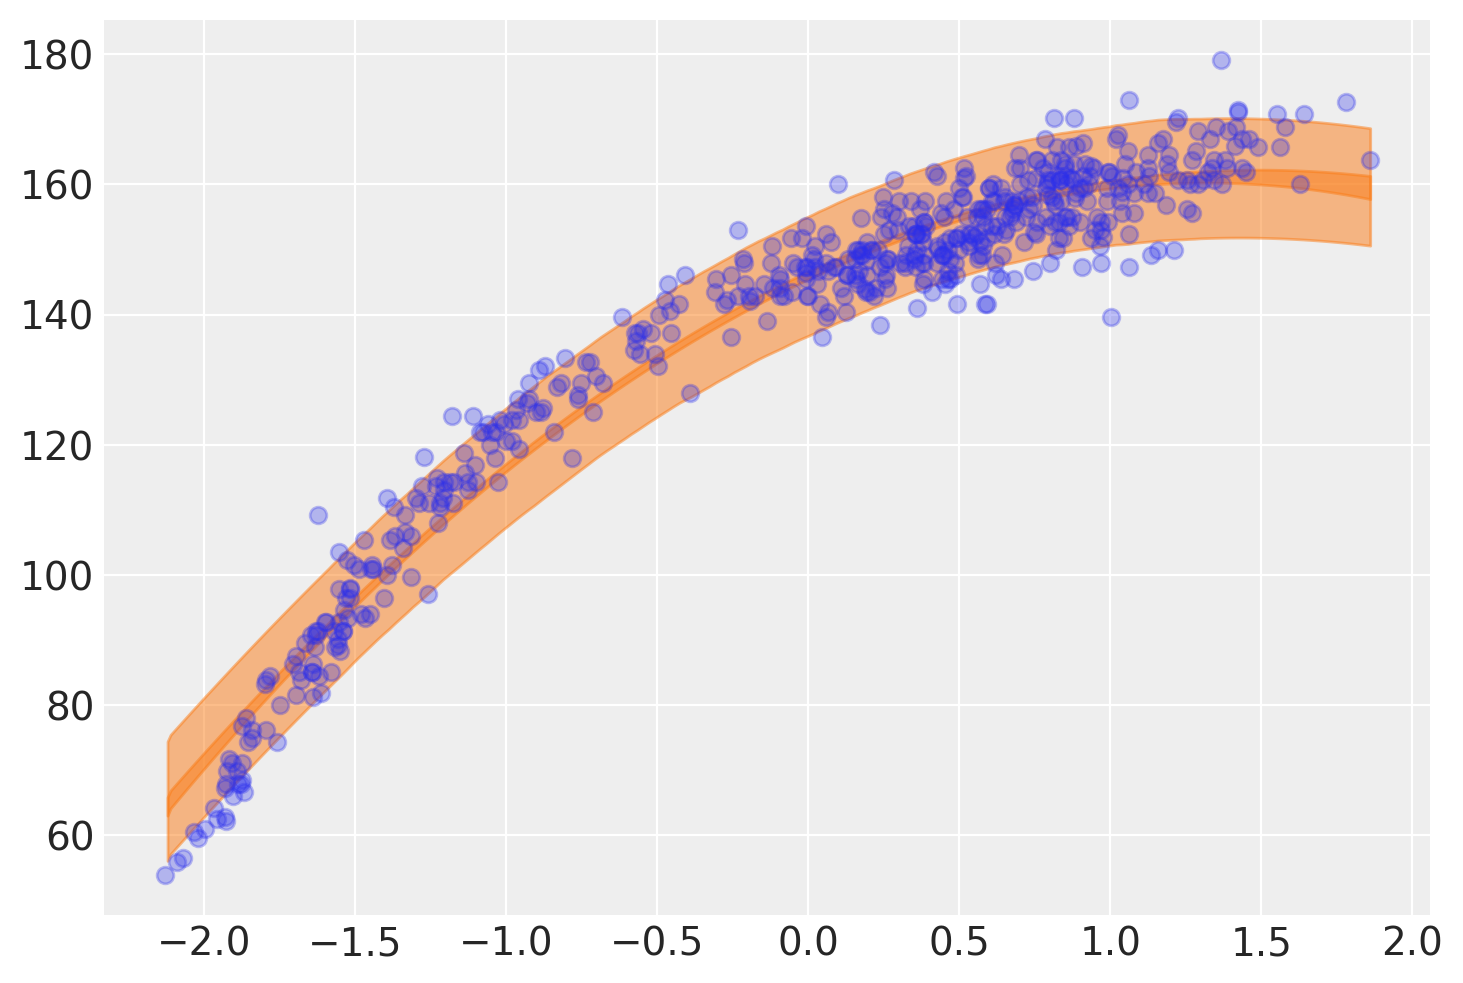

In [56]:
# Previous polynomial regression plot
ax = az.plot_hdi(d.weight_std, mu_pred, hdi_prob=0.89)
az.plot_hdi(d.weight_std, height_pred.posterior_predictive["height"], ax=ax, hdi_prob=0.89)
plt.scatter(d.weight_std, d.height, c="C0", alpha=0.3)

As we can see with our standard Linear model on the left-hand side of **Figure 4.11**, it does a poor job of predicting the weight values at the very low end of our dataset and around the middle/median. And if we compare this Linear model to the middle graph, which represents a **quadratic regression**, it does a much better job of finding a central path through our data.

#### Code 4.69

We will stack the weights to get a 2D array, this simplifies writing a model. Now we can compute the dot product between beta and the 2D-array

In [57]:
weight_m = np.vstack((d.weight_std, d.weight_std**2, d.weight_std**3))
weight_m

array([[ 8.29868948e-01,  5.94590878e-02, -2.54482930e-01, ...,
         1.25359437e+00, -1.87234364e+00,  1.14958904e+00],
       [ 6.88682470e-01,  3.53538312e-03,  6.47615617e-02, ...,
         1.57149885e+00,  3.50567069e+00,  1.32155496e+00],
       [ 5.71516197e-01,  2.10210655e-04, -1.64807120e-02, ...,
         1.97002211e+00, -6.56382021e+00,  1.51924510e+00]])

The right-most graph on **Figure 4.11** is an example of a **higher-order polynomial regression**, otherwise known as a **cubic regression**, on our weight values. The model for the cubic regression is the following:

$ h_{i} \sim \text{Normal}(\mu_{i}, \sigma) $

$ \mu_{i} = \alpha + \beta_{1}x_{1} + \beta_{2}x_{2}^2 + \beta_{3}x_{3}^3$

$ \alpha \sim \text{Normal}(178, 20) $

$ \beta_{1} \sim \text{Log-Normal}(0, 1) $

$ \beta_{2} \sim \text{Normal}(0, 1) $

$ \beta_{3} \sim \text{Normal}(0, 1) $

$ \sigma \sim \text{Uniform}(0, 50) $

In [58]:
# Cubic Regression:
with pm.Model() as m_4_6:
    a = pm.Normal("a", mu=178, sigma=100)
    b = pm.Normal("b", mu=0, sigma=10, shape=3)
    sigma = pm.Uniform("sigma", lower=0, upper=50)
    mu = pm.Deterministic("mu", a + pm.math.dot(b, weight_m))
    height = pm.Normal("height", mu=mu, sigma=sigma, observed=d.height.values)
    trace_4_6 = pm.sample(1000, tune=1000)


az.summary(trace_4_6, kind="stats")

mean     sd  hdi_5.5%  hdi_94.5%
a        146.718  0.315   146.200    147.188
b[0]      15.019  0.486    14.251     15.815
b[1]      -6.527  0.257    -6.928     -6.122
b[2]       3.598  0.229     3.225      3.949
sigma      4.852  0.151     4.602      5.085
...          ...    ...       ...        ...
mu[539]  141.436  0.366   140.866    142.032
mu[540]  160.470  0.372   159.913    161.071
mu[541]  162.376  0.456   161.692    163.134
mu[542]   72.097  0.646    71.019     73.099
mu[543]  160.824  0.385   160.245    161.457

[549 rows x 4 columns]

In [59]:
with m_4_6:
    height_pred_4_6 = pm.sample_posterior_predictive(trace_4_6)

In [60]:
mu_pred_4_6 = trace_4_6.posterior["mu"]

#### *Figure 4.11*

In [61]:
# Previous Linear Model
with pm.Model() as m4_3b_std:
    a = pm.Normal("a", mu=178, sigma=20)
    b_old = pm.Normal("b_old", mu=0, sigma=1)
    b = pm.Deterministic("b", pm.math.exp(b_old))
    sigma = pm.Uniform("sigma", 0, 50)
    mu = a + b * d["weight_std"] # Main difference between this and `m_4_5` is in this line
    height = pm.Normal("height", mu=mu, sigma=sigma, observed=d["height"].values)
    trace_4_3b_std = pm.sample(1000, tune=1000)

az.summary(trace_4_3b_std, kind="stats")

mean     sd  hdi_5.5%  hdi_94.5%
a      138.271  0.402   137.637    138.902
b_old    3.256  0.016     3.232      3.281
sigma    9.383  0.285     8.910      9.804
b       25.942  0.404    25.340     26.603

In [62]:
with m4_3b_std:
    height_pred_4_3b = pm.sample_posterior_predictive(trace_4_3b_std)

The main difference between the two pieces of PyMC code is the model specifications. In the first piece of code, `m4_3b_std`, the model assumes a linear relationship between weight and height, with the intercept, $\alpha$, being normally distributed while the slope, $\beta$, being *log*-normally distributed. The weight variable `d["weight_std"]` is standardized before being used in the model, meaning it has mean of 0 and a standard deviation of 1.

In the second piece of code, `m_4_5`, the **polynomial** (or **quadratic regression**) model includes two predictors, `d["weight_std"]` and `d["weight_std2"]`, and assumes a linear relationship between these predictors and height, with normally distributed intercept `a`, and normally distributed slopes `b1` and `b2`. Like the `m4_3b_std` model, `b1` is sampled from a log-normal distribution to ensure that it is positive, while `b2` is sampled from a normal distribution. The model also includes a uniform prior on the residual standard deviation sigma.

And with our last piece of code on the far right, we can see that our **cubic regression model** `m_4_6` adds a small modification to the middle, quadratic regression by adding another parameter to the linear model, $\beta_{3}x_{i}^3$, so that the curve is more flexible and fits the data better.

Although these models fit the data better and make good "geocentric" descriptions of our sampled data, it's unclear whether they make a lot of sense. We'll come across two issues with this model that will be the subject of the latter problems but are important enough for us to mention quickly now:

- *Issue 1*: A better fit to the model may not necessarily lead to a better model (i.e. overfitting). We'll go over this in more depth in Chapter 7.
- *Issue 2*: The model contains no biological information, therefore we cannot learn any causal relationships between height and weight. We'll deal with this issue more in chapter 16.

Also, the following numbers commented beside each line of plotting code explain what the code is actually plotting:

1. The blue scatterplot indicates our original height and weight values from the `d` dataset.
2. Our mean regression line captures the average from each distribution of plausible mean values for every weight value indicated by the black line.
3. Lastly, the more-expansive grey boundaries capture the simulated heights that our model expects from 89% of the actual heights in the population for each weight value.

Text(0.4, -0.05, 'Figure 4.11. Polynomial regressions of height on weight (standardized) \n     for the full !Kung data. In each plot, the raw data are shown by the circles. \n     The solid curves show the path of $\\mu$ in each model, and the shaded regions \n     show 89% interval of the mean (close to the solid curve) and the 89% interval \n     of predictions (wider). Left: Linear Regression. Middle: A second order \n     polynomial, a parabolic or quadratic regression. Right: A third order \n     polynomial, a cubic regression.')

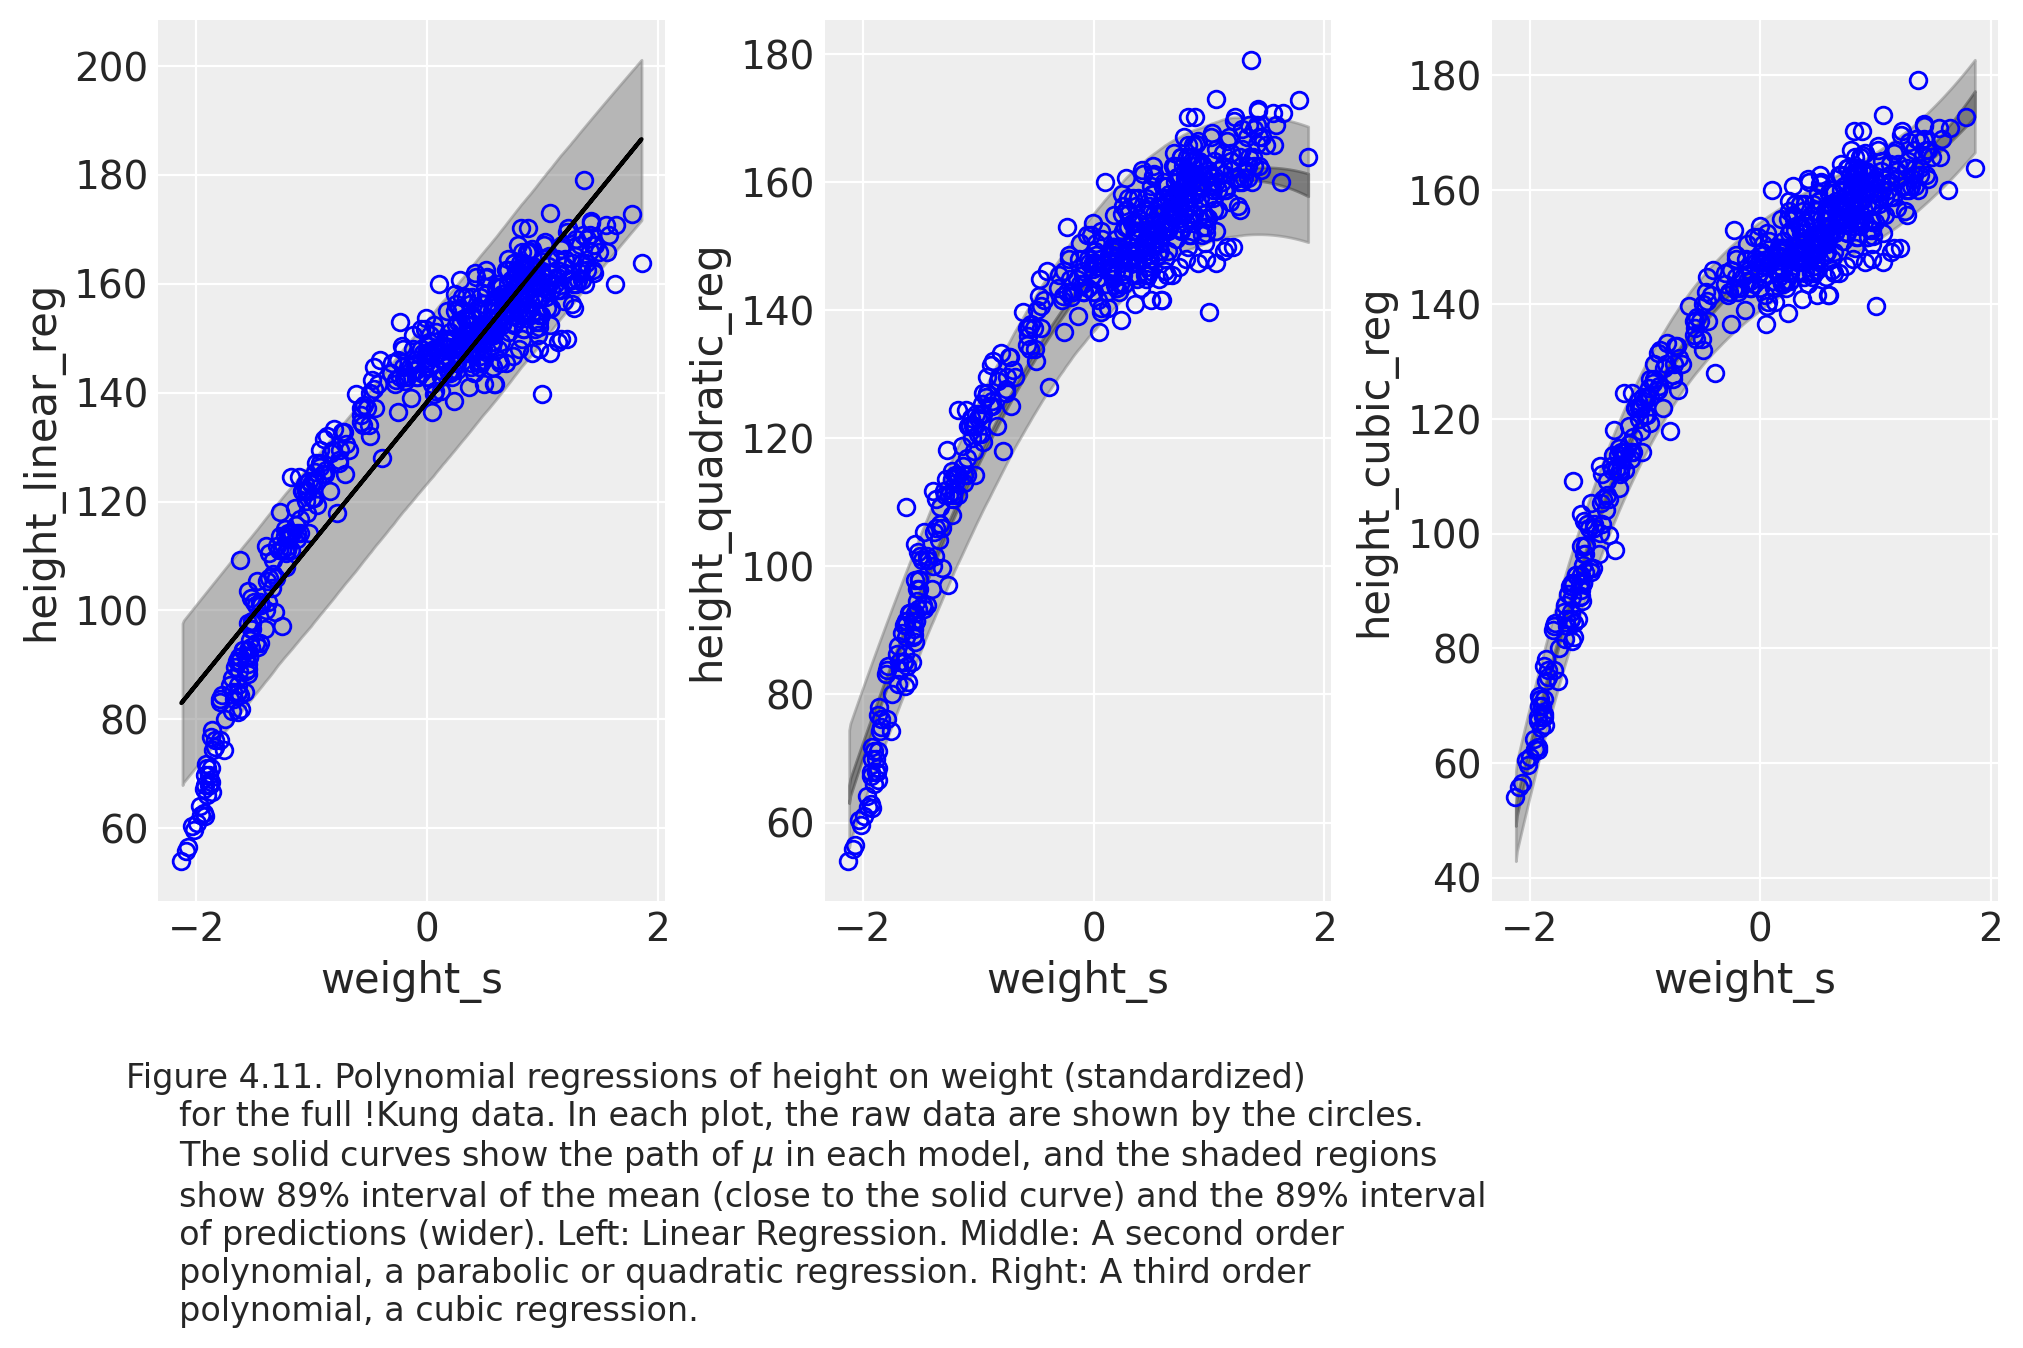

In [63]:
_, ax = plt.subplots(1, 3, figsize=(10, 5))

az.plot_hdi(d["weight_std"], height_pred_4_3b.posterior_predictive["height"], ax=ax[0], hdi_prob=0.89, color="grey") #3
ax[0].plot(d["weight_std"], d["height"], marker="o", color="none", markeredgecolor="blue") # 1 orig scatter
ax[0].plot(
    d["weight_std"],
    trace_4_3b_std.posterior["a"].mean().item(0)
    + trace_4_3b_std.posterior["b"].mean().item(0)
    * d["weight_std"],
    c="black"
  ) #2 black mean line
ax[0].set_xlabel("weight_s")
ax[0].set_ylabel("height_linear_reg")

az.plot_hdi(d["weight_std"], mu_pred, ax=ax[1], hdi_prob=0.89, color="black") #2
az.plot_hdi(d["weight_std"], height_pred.posterior_predictive["height"], ax=ax[1], hdi_prob=0.89, color="grey") #3
ax[1].plot(d["weight_std"], d["height"], marker="o", color="none", markeredgecolor="blue") #1
ax[1].set_xlabel("weight_s")
ax[1].set_ylabel("height_quadratic_reg")

az.plot_hdi(d["weight_std"], mu_pred_4_6, ax=ax[2], hdi_prob=0.89, color="black") #2
az.plot_hdi(d["weight_std"], height_pred_4_6.posterior_predictive["height"], ax=ax[2], hdi_prob=0.89, color="grey") #3
ax[2].plot(d["weight_std"], d["height"], marker="o", color="none", markeredgecolor="blue") #1
ax[2].set_xlabel("weight_s")
ax[2].set_ylabel("height_cubic_reg")


plt.suptitle(
    x=0.4,
    y=-0.05,
    t="Figure 4.11. Polynomial regressions of height on weight (standardized) \n \
    for the full !Kung data. In each plot, the raw data are shown by the circles. \n \
    The solid curves show the path of $\mu$ in each model, and the shaded regions \n \
    show 89% interval of the mean (close to the solid curve) and the 89% interval \n \
    of predictions (wider). Left: Linear Regression. Middle: A second order \n \
    polynomial, a parabolic or quadratic regression. Right: A third order \n \
    polynomial, a cubic regression.",
    ma="left"
  )

#### Rethinking: Linear, additive, funky.

The parabolic model of $\mu_{i}$ is still a "linear model" of the mean, although the equation is clearly not a straight line. Unfortunately, the word "linear" means different things in different contexts, and other people use it differently in the same context. In this context, "linear" means that $\mu_{i}$ is a **linear function** of any one parameter. Linear models have the advantage of being easier to fit to data and are easier to interpret because these models assume that the parameters act independently on the mean.

However, they also have the disadvantage of being used thoughtlessly. When you have better prior knowledge on a particular topic, it's often easy to achieve better results than a linear model, which are generally "geocentric" devices for describing partial correlations. Therefore, we SHOULDN'T be satisfied with the phenomenological explanations they provide but instead should dig deeper to find more meaningful relationships.

#### Overthinking: Converting back to natural scale.

The x-axis of the plots in *Figure 4.11* have been standardized where the units are also often called **z-scores**. Now, if we wanted to plot the results of our estimates back to their natural scale after fitting our model to the data, all we have to do is to "turn off" the horizontal axis when we plot the raw data. What we mean by this is that we can swap the z-score values that were initially plotted in the x-axis by their natural scale equivalent by multiplying each standardized weight value by each possible z-score x-axis label ($[-2, -1, 0, 1, 2]$) and then adding the result by the mean of the standardized weight values.

These steps are essentially the *inverse of calculating the Standard Scaler* for each weight value.

#### Code 4.70 and 4.71

Text(0, 0.5, 'height')

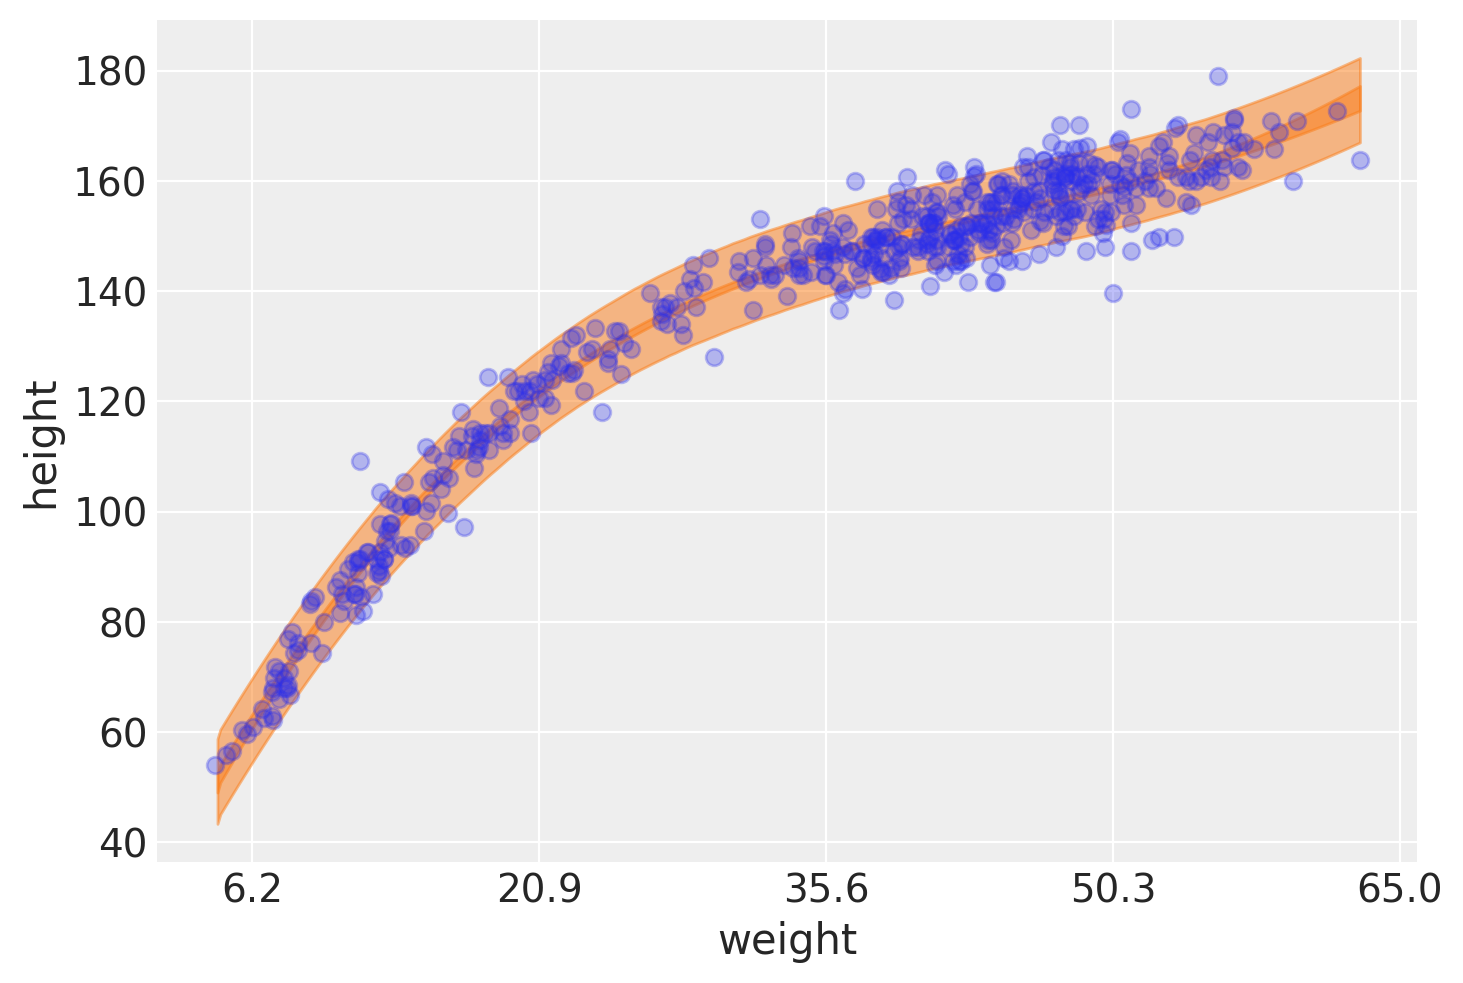

In [64]:
mu_pred = trace_4_6.posterior["mu"]
trace_4_6_thin = trace_4_6.sel(draw=slice(None, None, 5))
with m_4_6:
    height_pred = pm.sample_posterior_predictive(trace_4_6_thin)

ax = az.plot_hdi(d.weight_std, mu_pred, hdi_prob=0.89)
az.plot_hdi(d.weight_std, height_pred.posterior_predictive["height"], ax=ax, hdi_prob=0.89)
plt.scatter(d.weight_std, d.height, c="C0", alpha=0.3)

# convert x-axis back to original scale
at = np.arange(-2, 3)
labels = np.round(at * d.weight.std() + d.weight.mean(), 1)
plt.xticks(at, labels)
plt.xlabel("weight")
plt.ylabel("height")

### 4.5.2. Splines.

The second way to introduce a curve is to construct a **spline**, initially referred to as a long, thin piece of wood or metal that helps drafters and designers draw curves by anchoring it in a few places. In statistics, a spline is a smooth function built out of smaller component functions, similar to what we did with our quadratic (or cubic) regression models by adding a $\beta$ parameter to better fit the data.

In this instance, we'll use a **B-spline**, which is short for "basis" spline or "basis function," to divide a predictor variable, such as weight for human heights, into parts and assign each of them with a parameter that we can turn on or off to generate a wiggly curve. Similar to polynomial regressions, b-splines generate a new predictor variable using a linear model, identical to what we previously did with our mean heights parameter, $\mu_{i}$. However, the difference with b-splines is that they do not directly transform the predictor by squaring or cubing it but instead, by generating a new series of <u>synthetic predictor variables</u> which we represent with $\beta_{i, n}$ that specifically turn a parameter on or off within a range of the real predictor variable. Each of these synthetic predictor variables are what we call **basis functions**. We'll use b-splines, or **basis functions**, to introduce the concepts of splines in statistics because they force us to make important choices for building "wiggly" curves around data. However, there are many other types of splines out there that can automate a lot of the choices we make.

An example of a **B-spline Linear Model** is the following:

$$
\mu_{i} = \alpha + w_{1}\beta_{i, 1} + w_{2}\beta_{i, 2} + w_{3}\beta_{i, 3} + ...
$$

Where:

- $\beta_{i, n}$ is the $n$-th basis function's value on row $i$
- $w_n$ is the corresponding weight parameter for each basis function's value on a given row.

<img src="https://s3files.core77.com/blog/images/lead_n_spotlight/513238_spotlight_55368_G2vlVczoM.png" width=800 height=400>

#### Code 4.72

To demonstrate this technique, let's read data which records the first day of the cherry blossom blooming in Japan. The target variable we're interested in this context is the `doy`, which records the number of days that have passed in the new year. For example, the mean `doy` in our dataset is $104.9 → 105$, which translates roughly to April 15th ($105 - 31 (Mar) - 28 (Feb) - 31 (Jan)$). In addition, the recorded `year's for cherry blossom dates run between 812 to 2015 CE in our dataset.

In [65]:
# d = pd.read_csv("Data/cherry_blossoms.csv")
# nans are not treated as in the book

cb_path = "https://raw.githubusercontent.com/pymc-devs/pymc-resources/main/Rethinking_2/Data/cherry_blossoms.csv"
cb = pd.read_csv(cb_path)
az.summary(cb.dropna().to_dict(orient="list"), kind="stats")

mean       sd  hdi_5.5%  hdi_94.5%
year        1533.395  291.123   1123.00    1978.00
doy          104.921    6.258     95.00     114.00
temp           6.100    0.683      5.00       7.13
temp_upper     6.938    0.812      5.57       7.98
temp_lower     5.264    0.762      4.12       6.40

Text(0, 0.5, 'day of first blossom')

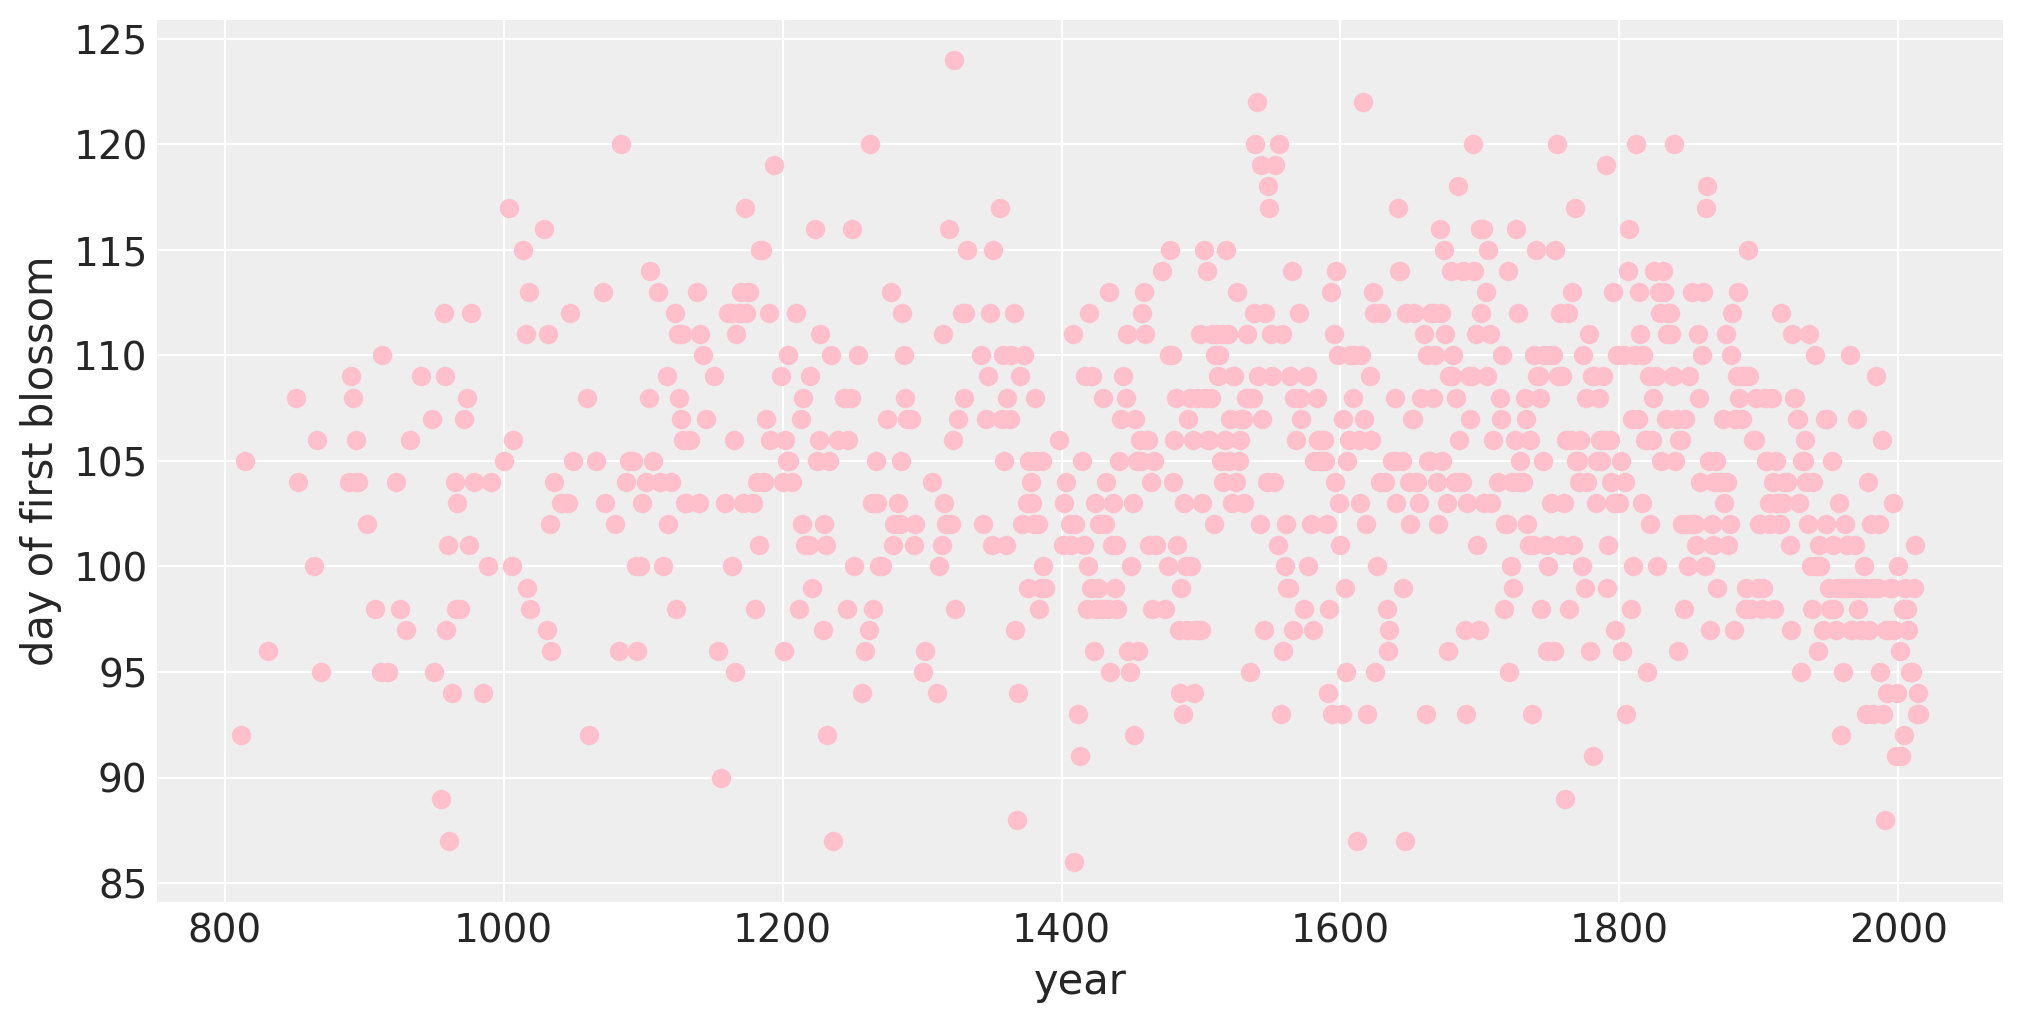

In [66]:
fig, ax = plt.subplots(figsize=(10, 5))
plt.scatter(cb.year, cb.doy, color="pink")
plt.xlabel("year")
plt.ylabel("day of first blossom")

Now the next question we have to ask is how we construct the basis functions for $\beta$? As we can see from **Figure 4.12** later, we've divided the full range of the horizontal axis (the `year`) into four parts, using pivot points called **knots** that we placed evenly at *quantiles* of year. These **knots** are represented as the $+$ symbols in the equation for our **B-spline Linear Model**and act as pivots or pegs in a pegboard for the different basis functions \( $\beta_{i, n}$ \) in our model. One thing to note is that even quantiles won't result in evenly spaced knots because there wasn't as much recorded data on blossom dates far into the past.

On the other hand, the synthetic variables themselves \($w_{n}\beta_{i, n}$\) represent the string in our pegboard for the transition from one point in the horizontal x-axis to the other. So, for example, if we look at the top plot for **Figure 4.12**,  the line at the top, which we'll call "basis #1" in knot #1, has a basis function and value of 1 while the line below, which we'll call "basis #2," has values of zero across the board. But when we move right to knot #2, basis #1's value has decreased to 0 while basis #2 has increased to a value of 1. The nice thing about these basis functions is that they limit their influence on a parameter to a local level yet preserve their impact on the prediction, such as with the point in the x-axis for the year 1200, where both basis functions have a non-zero value. This model contrasts polynomial regression, where the parameters influence the entire shape of the curve.

Now in the middle plot of **Figure 4.12**, we've multiplied each basis function ($\beta_{i, n}$) by their corresponding weight parameter \($w_{n}$\), which can be either a positive or a negative value. To make a prediction for this model \(let's use the year 1200 again\), we just need to add these weighted basis functions at that given year. So from the middle graph, we can see that the sum of basis #1 and #2 is only slightly above 0, which we've used to represent the mean.

And in the bottom plot, the spline is graphed as a 97\% posterior interval for $\mu$ over the raw data. We can see from spline that the trend seems to be steady throughout history until about the 1800's, where we see a considerable dip in the day blossoms begin to appear \(i.e. they bloom earlier in the year\). We can probably attribute this to the global warming spurned by the boom of the Industrial Revolution during that same period.

However, there's probably more to this story that we can investigate prior to the 1800s and we can explore it in 2 ways:

1. The first is to add more knots. More knots equals more flexibility in building the spline.
2 The second way is to swap out linear approximations for **higher-degree polynomials**. Let's explore this alternative in the following paragraphs.

<img src="https://i.pinimg.com/originals/a5/00/15/a500158160947cc08d757e63219d33d8.jpg" width=350 height=450>

#### *Figure 4.12*

In [67]:
# Plot 1 for basis function values
num_knots = 5
knot_list = np.quantile(cb.year, np.linspace(0, 1, num_knots))

B_spline_matrix = dmatrix(
    "bs(year, knots=knots, degree=3, include_intercept=True)-1",
    {"year": cb.year.values, "knots": knot_list[1:-1]},
)

In [68]:
# Plot 2 for basis functions * weight values (Ignore meaning for now)
with pm.Model() as m4_7ex:
    a_ex = pm.Normal("a", 100, 10)
    w_ex = pm.Normal("w", mu=0, sigma=10, shape=B_spline_matrix.shape[1])
    mu_ex = pm.Deterministic("mu", a_ex + pm.math.dot(np.asarray(B_spline_matrix, order="F"), w_ex.T))
    # mu = pm.Deterministic("mu", a + pm.math.dot(B.base, w.T))
    sigma_ex = pm.Exponential("sigma", 1)
    D_ex = pm.Normal("D", mu_ex, sigma_ex, observed=cb.doy.values)
    trace_m4_7ex = pm.sample(1000)

/usr/local/lib/python3.10/dist-packages/pymc/model.py:1402: ImputationWarning: Data in D contains missing values and will be automatically imputed from the sampling distribution.
  warnings.warn(impute_message, ImputationWarning)


Text(0.5, 0, 'Figure 4.12. Using B-splines to make local, linear approximations. \n     Top: Each basis functon is a variable that turns on specific ranges \n     of the prediction variable. At any given value on the horizontal axis, \n     e.g. 1200, only two have non-zero values. \n     Middle: Parameters called weights multiply the basis functions. The \n     spline at any given point is the sum of these weighted basis functions. \n     Bottom: The resulting B-Spline shown against the data. Each weight parameter \n     determines the slope in a specific range of the predictor variable.')

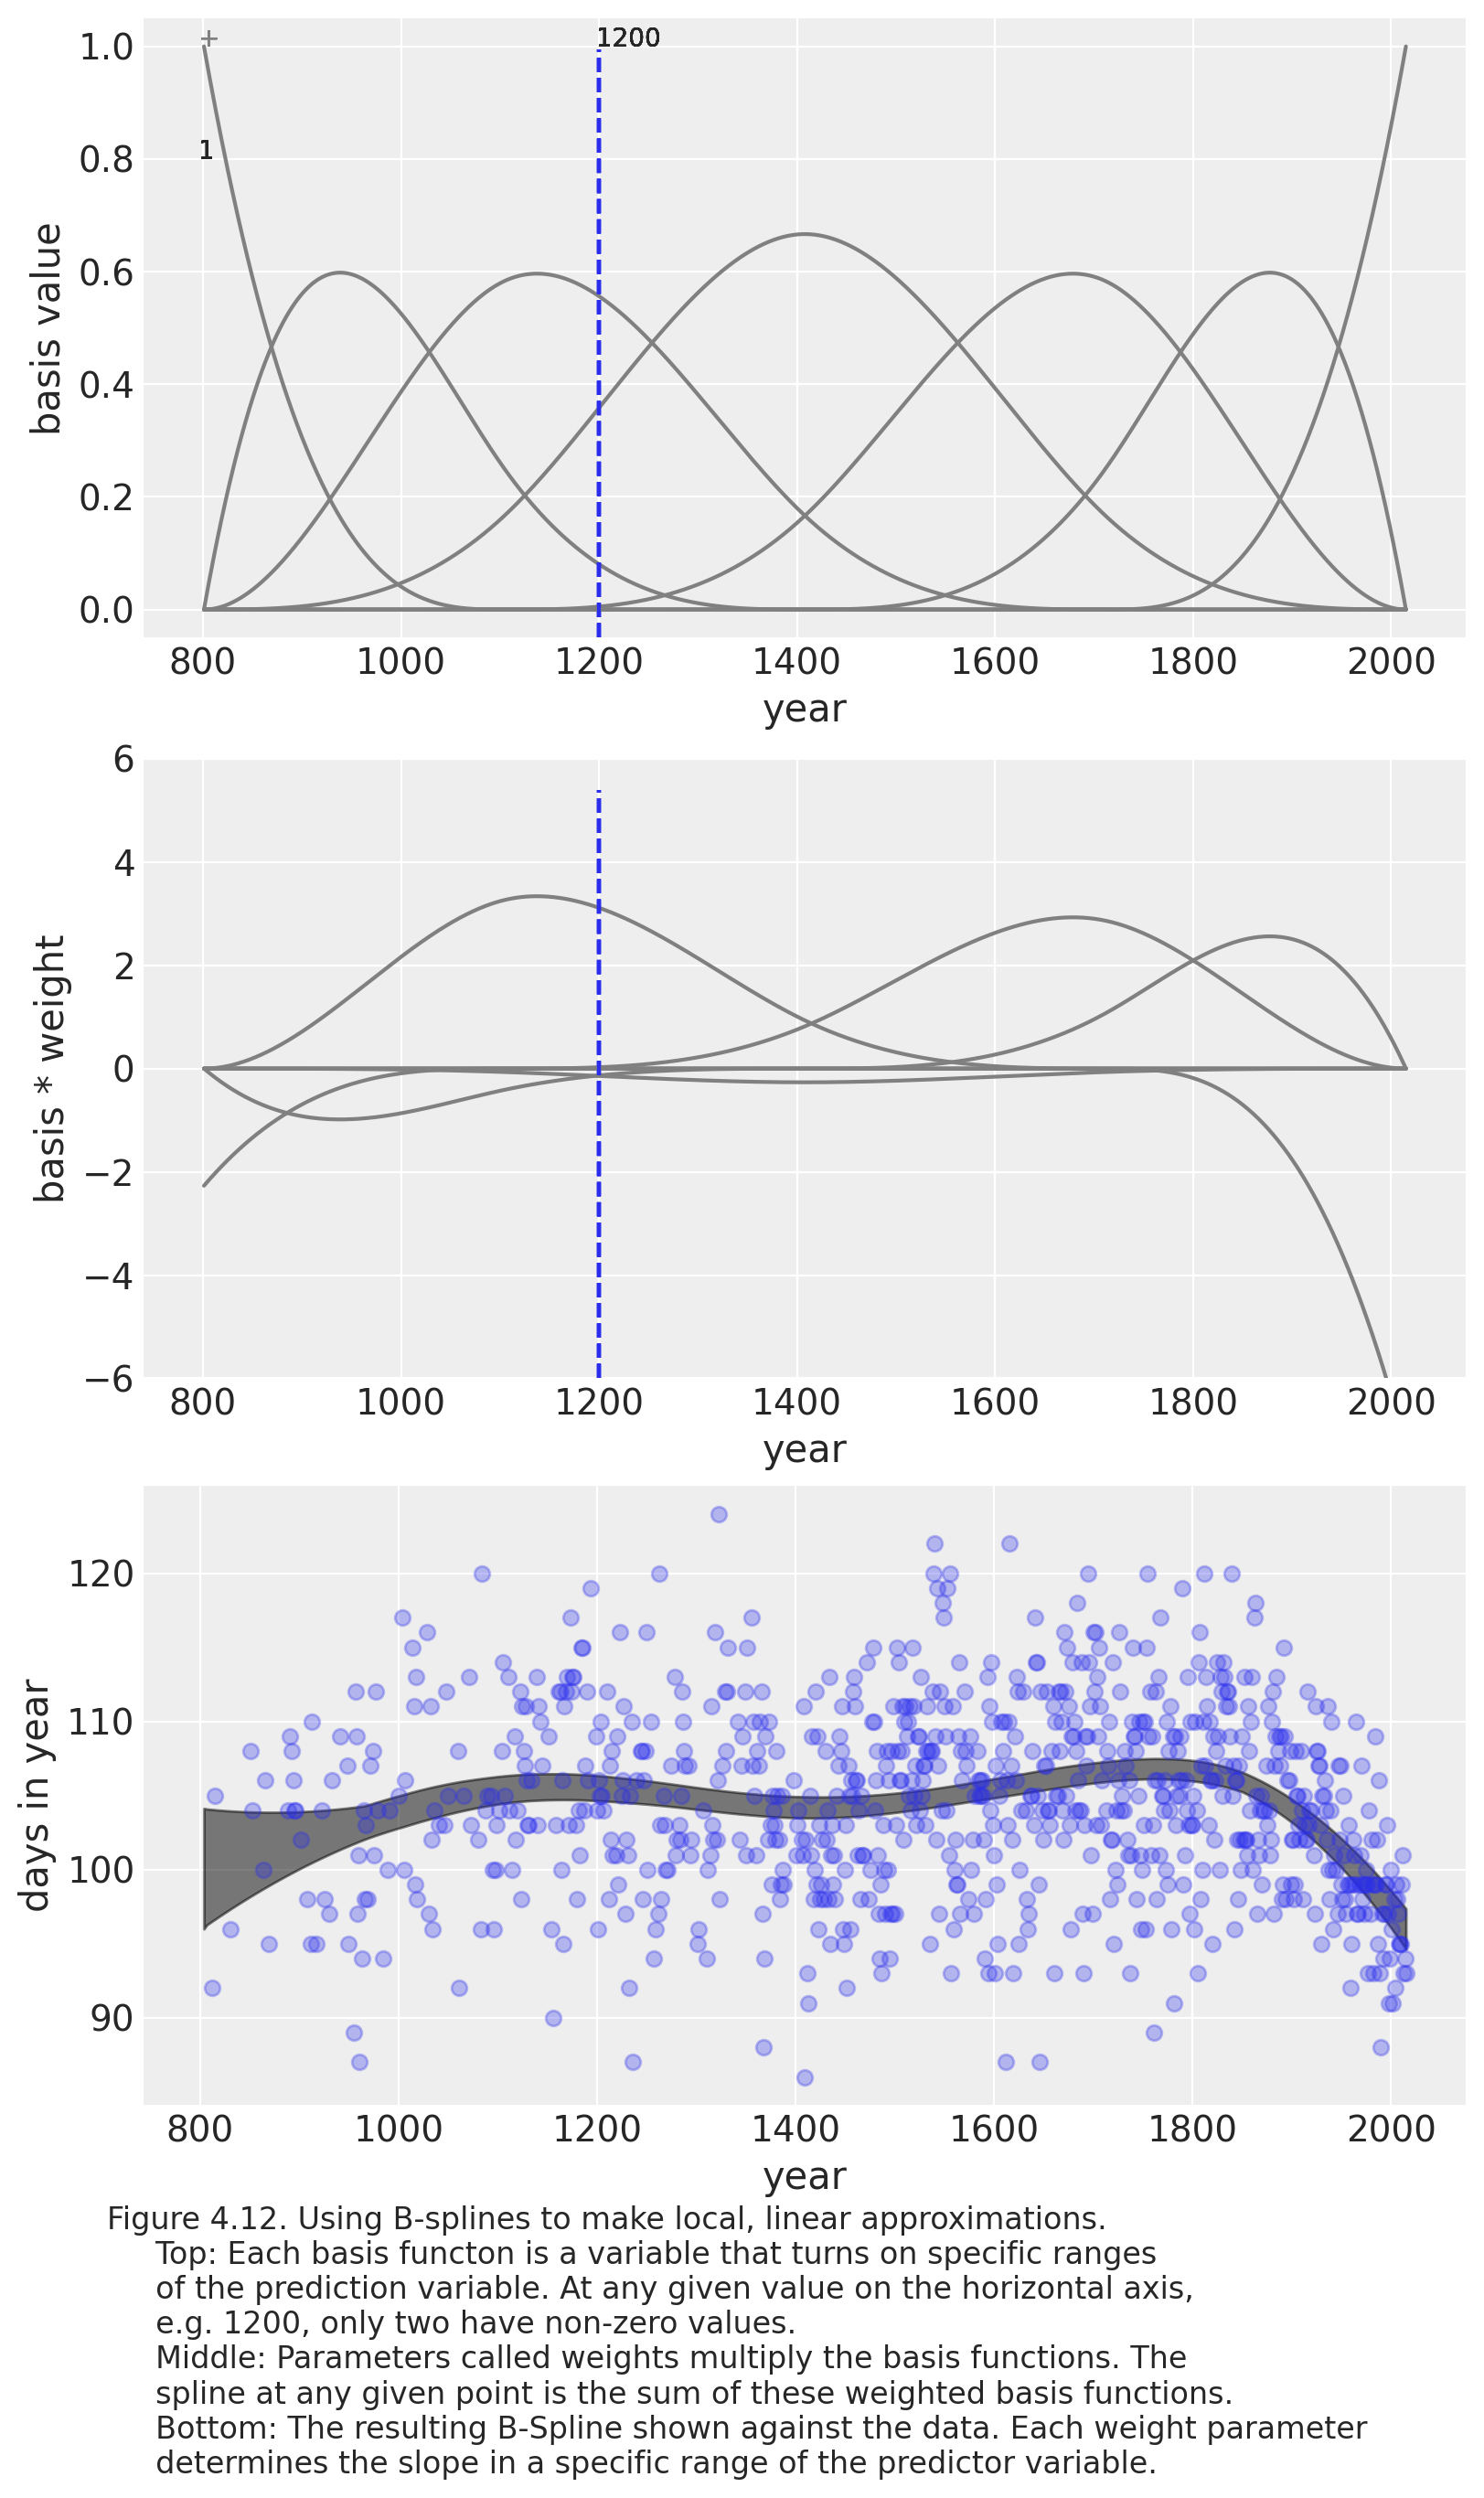

In [69]:
_, ax = plt.subplots(3, 1, figsize=(8, 12))

for i in range(B_spline_matrix.shape[1]):
  ax[0].plot(cb.year, (B_spline_matrix[:, i]), color="grey")
  ax[0].set_xlabel("year")
  ax[0].set_ylabel("basis value")
  ax[0].axvline(1200, ymin=0, ymax=0.95, ls="--")
  ax[0].text(x=1197, y=1, s="1200")
  ax[0].text(x=795, y=1, s="+", color="grey")
  ax[0].text(x=795, y=0.8, s="1")



wp_ex = trace_m4_7ex.posterior.w.mean(dim=["chain", "draw"])
for i in range(B_spline_matrix.shape[1]):
  ax[1].plot(cb.year, (wp_ex[i].item(0) * B_spline_matrix[:, i]), color="grey")
  ax[1].set_ylim(-6, 6)
  ax[1].set_xlabel("year")
  ax[1].set_ylabel("basis * weight")
  ax[1].axvline(1200, ymin=0, ymax=0.95, ls="--")

ax = az.plot_hdi(cb["year"], trace_m4_7ex.posterior["mu"], color="k")
ax.plot(cb.year, cb.doy, "o", alpha=0.3)
# fig = plt.gcf()
ax.set_xlabel("year")
ax.set_ylabel("days in year")

plt.suptitle(
    x=0.5,
    y=0,
    ma="left",
    t="Figure 4.12. Using B-splines to make local, linear approximations. \n \
    Top: Each basis functon is a variable that turns on specific ranges \n \
    of the prediction variable. At any given value on the horizontal axis, \n \
    e.g. 1200, only two have non-zero values. \n \
    Middle: Parameters called weights multiply the basis functions. The \n \
    spline at any given point is the sum of these weighted basis functions. \n \
    Bottom: The resulting B-Spline shown against the data. Each weight parameter \n \
    determines the slope in a specific range of the predictor variable."
  )

#### Code 4.73

To illustrate how we utilize **higher-degree polynomials**, let's first reproduce **Figure 4.12** and change the knots and degrees to new values of our choosing.

In theory, we can place the knots anywhere within the `year` x-axis, but instead, let's go with simplicity in this example by jumping from 5 knots to 15:

In [70]:
cb2 = cb.dropna(subset=["doy"])
num_knots = 15
knot_list = np.quantile(cb2.year, np.linspace(0, 1, num_knots))

#### Code 4.74

The choice we have to make is the polynomial degree which determines how basis functions combine and how the polynomials interact to produce the spline. \[For degree 1, two basis functions combine. For degree 2, three basis functions combine. For degree 3, four basis functions combine. \]?

Using the `patsy.dmatrix()` function, we can build a basis function for any list of knots and degrees. Let's start with building a basis function for a degree 3 \(cubic\) spline:

Here we will use `patsy` as a simple way of building the b-spline matrix. For more detail please read https://patsy.readthedocs.io/en/latest/spline-regression.html

In [71]:
# from patsy import dmatrix

B = dmatrix(
    "bs(year, knots=knots, degree=3, include_intercept=True)-1",
    {"year": cb2.year.values, "knots": knot_list[1:-1]},
)

In [72]:
print(f"The number of rows and columns for Matrix B: {B.shape} \n")
print(f"Here are the values stored in the matrix: \n {np.asarray(B)} \n\n")
print(f"And elow is what the object 'B' looks like when we print it: \n")
B

The number of rows and columns for Matrix B: (827, 17) 

Here are the values stored in the matrix: 
 [[1.00000000e+00 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [9.60357132e-01 3.93123025e-02 3.29836692e-04 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [7.66509476e-01 2.20745951e-01 1.25594810e-02 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.63307543e-03
  9.66474002e-02 9.01713418e-01]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 4.12525649e-04
  4.95772164e-02 9.50009495e-01]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 1.00000000e+00]] 


And elow is what the object 'B' looks like when we print it: 



DesignMatrix with shape (827, 17)
  Columns:
    ['bs(year, knots=knots, degree=3, include_intercept=True)[0]',
     'bs(year, knots=knots, degree=3, include_intercept=True)[1]',
     'bs(year, knots=knots, degree=3, include_intercept=True)[2]',
     'bs(year, knots=knots, degree=3, include_intercept=True)[3]',
     'bs(year, knots=knots, degree=3, include_intercept=True)[4]',
     'bs(year, knots=knots, degree=3, include_intercept=True)[5]',
     'bs(year, knots=knots, degree=3, include_intercept=True)[6]',
     'bs(year, knots=knots, degree=3, include_intercept=True)[7]',
     'bs(year, knots=knots, degree=3, include_intercept=True)[8]',
     'bs(year, knots=knots, degree=3, include_intercept=True)[9]',
     'bs(year, knots=knots, degree=3, include_intercept=True)[10]',
     'bs(year, knots=knots, degree=3, include_intercept=True)[11]',
     'bs(year, knots=knots, degree=3, include_intercept=True)[12]',
     'bs(year, knots=knots, degree=3, include_intercept=True)[13]',
     'bs(year

Let's decode what we did with matrix `B`. In our `B`-matrix, we associated each of the 17 columns in the matrix with a basis function that lists its prediction of the day the cherry blossoms bloom for a given year.

And in Code 4.75, we've plotted each basis function against the year:

#### Code 4.75

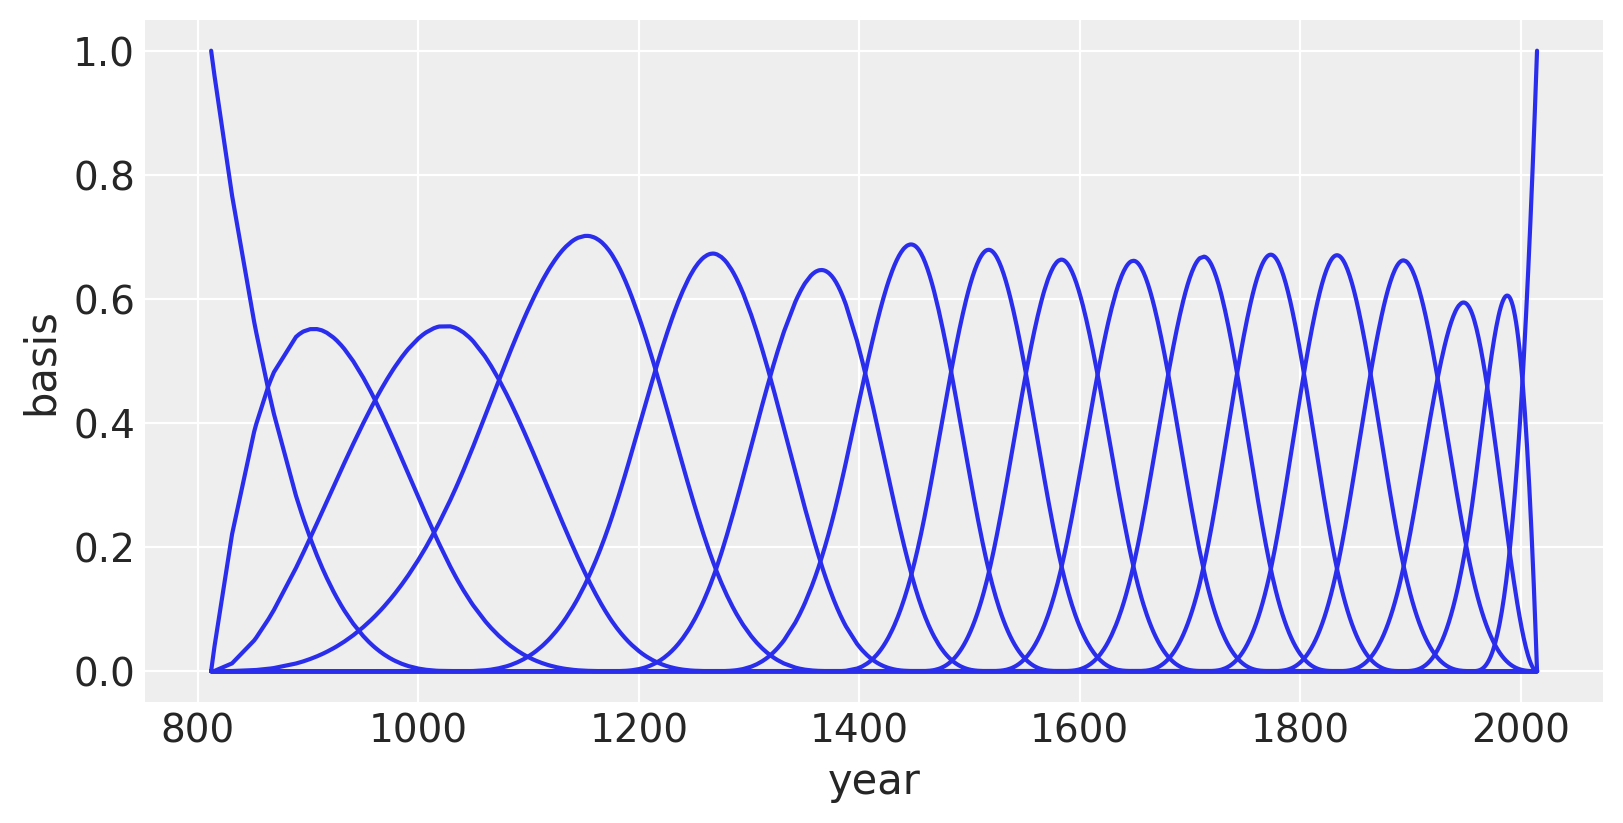

In [73]:
_, ax = plt.subplots(1, 1, figsize=(8, 4))
for i in range(B.shape[1]):
  ax.plot(cb2.year, (B[:, i]), color="C0")
  ax.set_xlabel("year")
  ax.set_ylabel("basis");

#### Exponential Distributions?? ####

Up to this point, all we've done is build a Linear Regeression with synthetic basis functions, but we've omitted the weights that usually come with a B-Spline Linear Model. To add the weights, we need first to define a model which includes an intercept to capture the average blossom day so that it's easier to define priors on the base weights. In doing so, we can conceive each weight as a deviation from the intercept.

In mathematical form, we can start with the probability of the data and the linear model:

$D_i \sim \text{Normal}(\mu_i, \sigma)$

$\mu_{i} = \alpha + \sum_{k=1}^K w_k  B_{k, i}$

<br>

And then, we can list our priors as we did with previous models:

$\alpha \sim \text{Normal}(100, 10)$

$w_j \sim \text{Normal}(0, 10)$

$\sigma \sim \text{Exponential}(1)$

<br>

This linear model is unlike anything we've encountered in the book. All it's doing is multiplying each basis value by a corresponding weight $w_k$ parameter and then adding up the $K$ of all those products, similar to what we displayed at the beginning of the section with our equation for B-spline Linear Models.

This is also our first time seeing an **Exponential Distribution** as a prior, which is helpful for "scale parameters," or parameters that must be positive. We can read our last prior, $\sigma$, as "exponential with a rate of 1." In this instance, what we mean by "rate" is that it represents the average deviation (from the mean??), and the average is also the inverse of the rate???.

So in the case of our exponential with a rate of 1, in this case we can think of it as  $1/1 = 1$, and if our rate were to be instead $\text{Exponential}(0.5)$, the mean would be $1/0.5 = 2$.

We'll be using exponential priors more often instead of uniform priors because it's more common to have a sense of the average deviation than the maximum?

Let's now actualize our model in Code 4.76:

#### Code 4.76 \(The B-Spline Linear Model\)

Note: if the model gets stalled instead of sampling try replacing

`mu = pm.Deterministic("mu", a + pm.math.dot(B.base, w.T))`

with:

`mu = pm.Deterministic("mu", a + pm.math.dot(np.asarray(B, order="F"), w.T))`

In [74]:
with pm.Model() as m4_7:
    a = pm.Normal("a", 100, 10)
    w = pm.Normal("w", mu=0, sigma=10, shape=B.shape[1])
    mu = pm.Deterministic("mu", a + pm.math.dot(np.asarray(B, order="F"), w.T))
    # mu = pm.Deterministic("mu", a + pm.math.dot(B.base, w.T))
    sigma = pm.Exponential("sigma", 1)
    D = pm.Normal("D", mu, sigma, observed=cb2.doy.values)
    trace_m4_7 = pm.sample(1000)

#### Code 4.77

Now let's plot the predictions for each of the basis functions in our model:

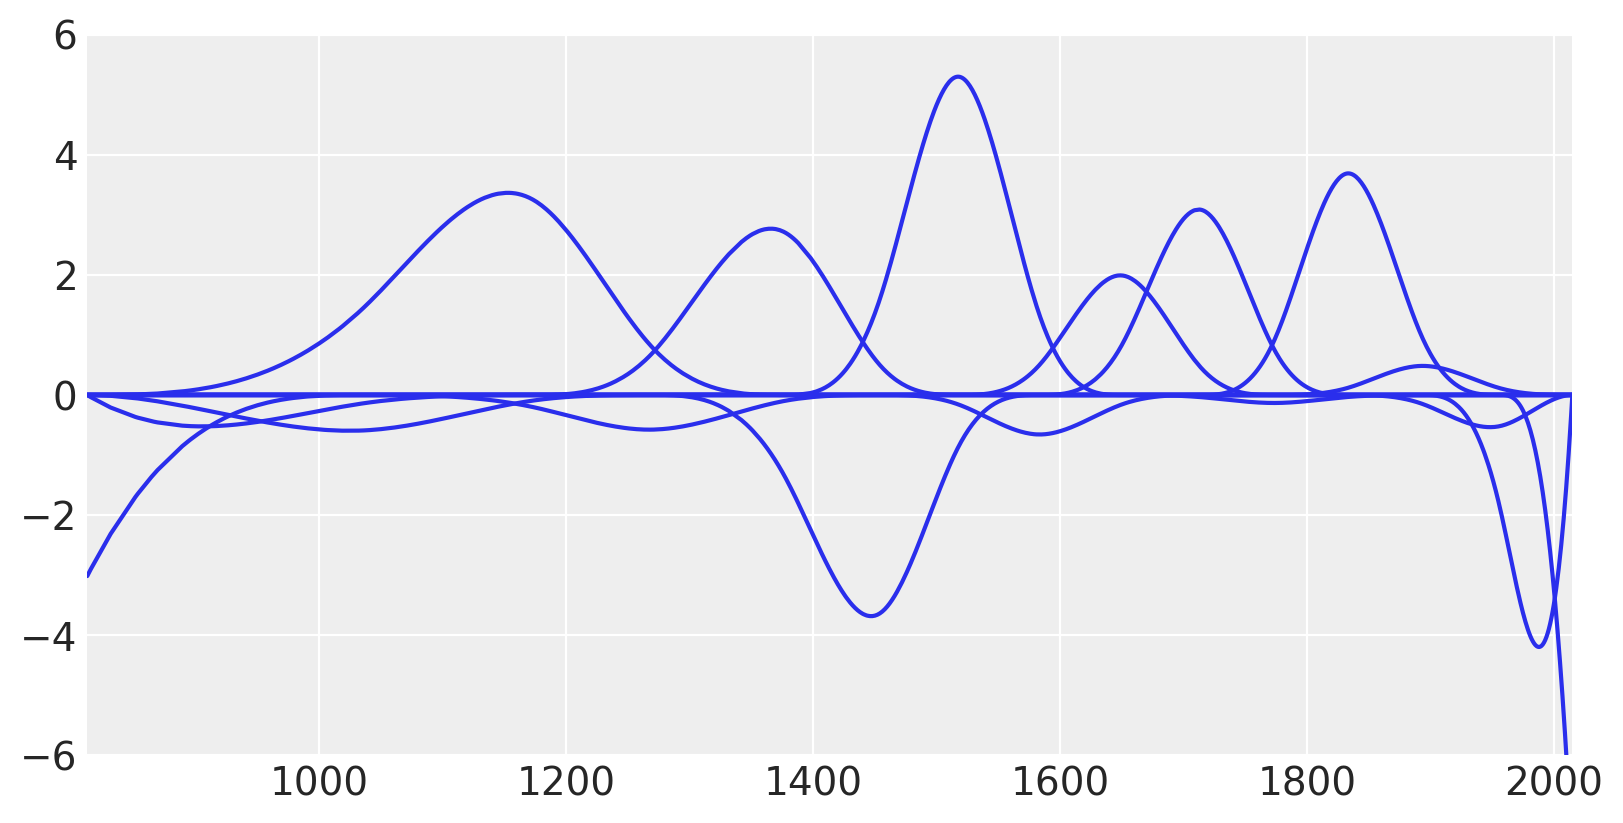

In [75]:
_, ax = plt.subplots(1, 1, figsize=(8, 4))
wp = trace_m4_7.posterior.w.mean(dim=["chain", "draw"])
for i in range(17):
  ax.plot(cb2.year, (wp[i].item(0) * B[:, i]), color="C0")
  ax.set_xlim(812, 2015)
  ax.set_ylim(-6, 6);

#### Code 4.78

In our plot in Code 4.77, notice how there are huge gaps in our basis functions' predictions around the year 1500. We'll investigate this huge delta in later chapters.

And with the plot in Code 4.78, we're plotting the 97% posterior interval for $\mu$ at each year:

Text(0, 0.5, 'days in year')

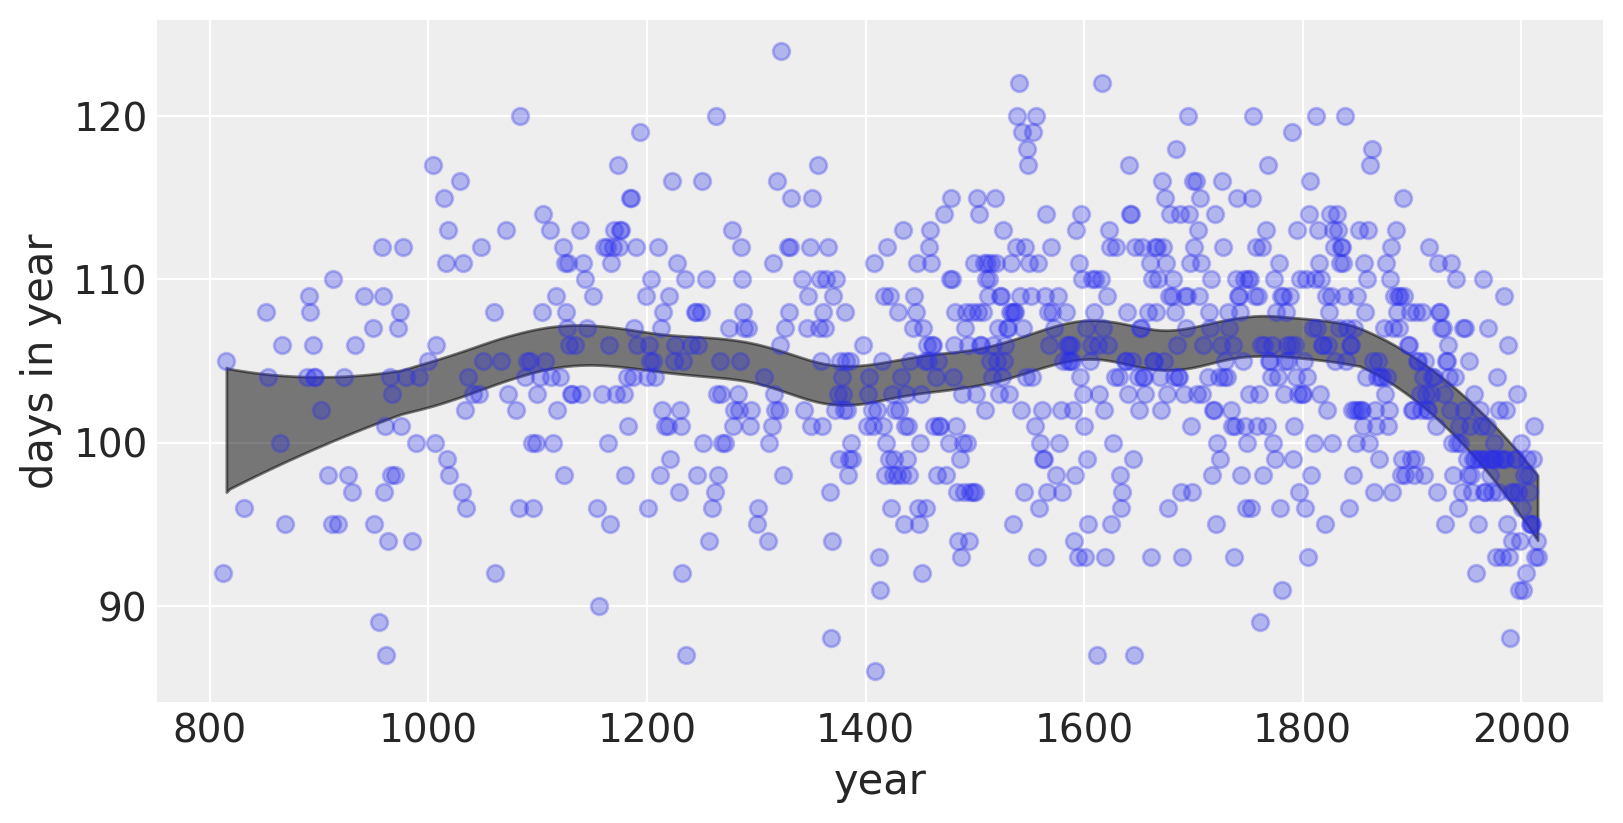

In [76]:
ax = az.plot_hdi(cb2.year, trace_m4_7.posterior["mu"], color="k")
ax.plot(cb2.year, cb2.doy, "o", alpha=0.3)
fig = plt.gcf()
fig.set_size_inches(8, 4)
ax.set_xlabel("year")
ax.set_ylabel("days in year")

In [77]:
# %load_ext watermark
# %watermark -n -u -v -iv -w -p aesara,aeppl,xarray

#### Overthinking: Matrix multiplication in the spline model.

In our B-spline model, it's important to note how we used **linear algebra** to multiply our matrix of basis function predictions with our distribution of weight values \( $B_{k, i} \cdot w_k$ \). To review the steps for matrix multiplication, what we did was we:

1. Multiplied each element of the vector $w$ by each value in the corresponding row \(remember each row is the output/prediction of our basis function \) of out B-spline matrix, $\beta$;
2. Then, we summed up each row's output, resulting in a vector of 827 values because our original $B$-matrix had a shape of 827 rows of values by 17 columns.

The result of our 827 values equates to a linear prediction of the day that the cherry blossoms will bloom for each year we have a record for in our dataset.

#### Code 4.79

In [78]:
with pm.Model() as m4_7alt:
    a = pm.Normal("a", mu=100, sigma=1)
    w = pm.Normal("w", mu=0, sigma=10, shape=B.shape[1])
    sigma = pm.Exponential("sigma", lam=1)
    mu = a + pm.math.dot(B, w)
    D = pm.Normal("D", mu=mu, sigma=sigma, observed=cb2.doy.values)

    map_estimate = pm.find_MAP(model=m4_7alt)
    trace = pm.sample(1000, tune=1000, start=map_estimate)

<ipython-input-78-bdc1d9635153>:9: FutureWarning: The `start` kwarg was renamed to `initvals` and can now do more. Please check the docstring.
  trace = pm.sample(1000, tune=1000, start=map_estimate)


### 4.5.3 Smooth functions for a rough world.

From the splines we just worked with in section 4.5, an entire class of models called **Generalized Additive Models \(GAMs\)** exist to predict an outcome variable using smooth functions of some predictor variable. The topic is deep enough to deserve its own book. We'll touch on this subject in later chapters of this text.